##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/models/modify/model_maker) simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

This notebook shows an end-to-end example that utilizes this Model Maker library to illustrate the adaption and conversion of a commonly-used image classification model to classify flowers on a mobile device.

## Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [2]:
!sudo apt -y install libportaudio2
!pip install -q tflite-model-maker

libportaudio2 is already the newest version (19.6.0-1build1).


0 upgraded, 0 newly installed, 0 to remove and 64 not upgraded.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 2.14.2 requires packaging>=22.0, but you have packaging 20.9 which is incompatible.
jupyterlab-server 2.27.3 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
scikit-image 0.24.0 requires packaging>=21, but you have packaging 20.9 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.8.4 which is incompatible.


Import the required packages.

In [3]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

2024-07-19 12:35:37.780503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want 

## Simple End-to-End Example

### Get the data path

Let's get some images to play with this simple end-to-end example. Hundreds of images is a good start for Model Maker while more data could achieve better accuracy.

In [4]:
image_path = tf.keras.utils.get_file(
      'flower_photos.tgz',
      'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      extract=True)
image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

    16384/228813984 [..............................] - ETA: 1s

  8396800/228813984 [>.............................] - ETA: 1s

 21856256/228813984 [=>............................] - ETA: 1s

 38297600/228813984 [====>.........................] - ETA: 0s

 54673408/228813984 [======>.......................] - ETA: 0s

 71237632/228813984 [========>.....................] - ETA: 0s

 83894272/228813984 [=========>....................] - ETA: 0s

 99934208/228813984 [============>.................] - ETA: 0s

116703232/228813984 [==============>...............] - ETA: 0s

133390336/228813984 [================>.............] - ETA: 0s

149667840/228813984 [==================>...........] - ETA: 0s

159391744/228813984 [===================>..........] - ETA: 0s

175267840/228813984 [=====================>........] - ETA: 0s

191897600/228813984 [========================>.....] - ETA: 0s

193372160/228813984 [========================>.....] - ETA: 0s

201334784/228813984 [=========================>....] - ETA: 0s

217309184/228813984 [===========================>..] - ETA: 0s

228818944/228813984 [==============================] - 1s 0us/step


228827136/228813984 [==============================] - 1s 0us/step


You could replace `image_path` with your own image folders. As for uploading data to colab, you could find the upload button in the left sidebar shown in the image below with the red rectangle. Just have a try to upload a zip file and unzip it. The root file path is the current path.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_image_classification.png" alt="Upload File" width="800" hspace="100">

If you prefer not to upload your images to the cloud, you could try to run the library locally following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) in GitHub.

### Run the example
The example just consists of 4 lines of code as shown below, each of which representing one step of the overall process.


Step 1.   Load input data specific to an on-device ML app. Split it into training data and testing data.

In [5]:
data = DataLoader.from_folder(image_path)
train_data, test_data = data.split(0.9)

INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


2024-07-19 12:35:44.285069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2024-07-19 12:35:44.285187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2024-07-19 12:35:44.285262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2024-07-19 12:35:44.285333: W tensorflow/stream_executor

Step 2. Customize the TensorFlow model.

In [6]:
model = image_classifier.create(train_data)

INFO:tensorflow:Retraining the models...


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   


 rasLayerV1V2)                                                   


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 5)                 6405      


Total params: 3,419,429


Trainable params: 6,405


Non-trainable params: 3,413,024


_________________________________________________________________


None
Epoch 1/5


  1/103 [..............................] - ETA: 3:14 - loss: 1.9430 - accuracy: 0.1562

  2/103 [..............................] - ETA: 19s - loss: 1.9163 - accuracy: 0.1406 

  3/103 [..............................] - ETA: 19s - loss: 1.8943 - accuracy: 0.1458

  4/103 [>.............................] - ETA: 20s - loss: 1.8609 - accuracy: 0.1719

  5/103 [>.............................] - ETA: 19s - loss: 1.7976 - accuracy: 0.2062

  6/103 [>.............................] - ETA: 19s - loss: 1.7528 - accuracy: 0.2240

  7/103 [=>............................] - ETA: 18s - loss: 1.7364 - accuracy: 0.2277

  8/103 [=>............................] - ETA: 18s - loss: 1.7226 - accuracy: 0.2461

  9/103 [=>............................] - ETA: 18s - loss: 1.6853 - accuracy: 0.2708

 10/103 [=>............................] - ETA: 18s - loss: 1.6233 - accuracy: 0.3219

 11/103 [==>...........................] - ETA: 18s - loss: 1.6169 - accuracy: 0.3239

 12/103 [==>...........................] - ETA: 18s - loss: 1.5846 - accuracy: 0.3411

 13/103 [==>...........................] - ETA: 17s - loss: 1.5462 - accuracy: 0.3630

 14/103 [===>..........................] - ETA: 17s - loss: 1.5156 - accuracy: 0.3795

 15/103 [===>..........................] - ETA: 17s - loss: 1.4925 - accuracy: 0.3958

 16/103 [===>..........................] - ETA: 17s - loss: 1.4670 - accuracy: 0.4082

 17/103 [===>..........................] - ETA: 16s - loss: 1.4425 - accuracy: 0.4210

 18/103 [====>.........................] - ETA: 16s - loss: 1.4291 - accuracy: 0.4340

 19/103 [====>.........................] - ETA: 16s - loss: 1.4057 - accuracy: 0.4523

 20/103 [====>.........................] - ETA: 16s - loss: 1.3852 - accuracy: 0.4656

 21/103 [=====>........................] - ETA: 16s - loss: 1.3714 - accuracy: 0.4732

 22/103 [=====>........................] - ETA: 15s - loss: 1.3452 - accuracy: 0.4872

 23/103 [=====>........................] - ETA: 15s - loss: 1.3216 - accuracy: 0.5014

 24/103 [=====>........................] - ETA: 15s - loss: 1.3065 - accuracy: 0.5130

 25/103 [======>.......................] - ETA: 15s - loss: 1.2912 - accuracy: 0.5200

 26/103 [======>.......................] - ETA: 14s - loss: 1.2790 - accuracy: 0.5276

 27/103 [======>.......................] - ETA: 14s - loss: 1.2599 - accuracy: 0.5405

 28/103 [=======>......................] - ETA: 14s - loss: 1.2505 - accuracy: 0.5480

 29/103 [=======>......................] - ETA: 14s - loss: 1.2366 - accuracy: 0.5560

 30/103 [=======>......................] - ETA: 14s - loss: 1.2225 - accuracy: 0.5646

 31/103 [========>.....................] - ETA: 13s - loss: 1.2115 - accuracy: 0.5716

 32/103 [========>.....................] - ETA: 13s - loss: 1.1981 - accuracy: 0.5801

 33/103 [========>.....................] - ETA: 13s - loss: 1.1827 - accuracy: 0.5900

 34/103 [========>.....................] - ETA: 13s - loss: 1.1718 - accuracy: 0.5965

 35/103 [=========>....................] - ETA: 13s - loss: 1.1623 - accuracy: 0.6000

 36/103 [=========>....................] - ETA: 12s - loss: 1.1528 - accuracy: 0.6068

 37/103 [=========>....................] - ETA: 12s - loss: 1.1404 - accuracy: 0.6157

 38/103 [==========>...................] - ETA: 12s - loss: 1.1285 - accuracy: 0.6225

 39/103 [==========>...................] - ETA: 12s - loss: 1.1241 - accuracy: 0.6250

 40/103 [==========>...................] - ETA: 12s - loss: 1.1141 - accuracy: 0.6305

 41/103 [==========>...................] - ETA: 11s - loss: 1.1050 - accuracy: 0.6349

 42/103 [===========>..................] - ETA: 11s - loss: 1.0979 - accuracy: 0.6384

 43/103 [===========>..................] - ETA: 11s - loss: 1.0906 - accuracy: 0.6446

 44/103 [===========>..................] - ETA: 11s - loss: 1.0842 - accuracy: 0.6491

 45/103 [============>.................] - ETA: 11s - loss: 1.0783 - accuracy: 0.6528

 46/103 [============>.................] - ETA: 10s - loss: 1.0681 - accuracy: 0.6590

 47/103 [============>.................] - ETA: 10s - loss: 1.0616 - accuracy: 0.6629

 48/103 [============>.................] - ETA: 10s - loss: 1.0540 - accuracy: 0.6673

 49/103 [=============>................] - ETA: 10s - loss: 1.0479 - accuracy: 0.6716

 50/103 [=============>................] - ETA: 10s - loss: 1.0423 - accuracy: 0.6737

 51/103 [=============>................] - ETA: 9s - loss: 1.0367 - accuracy: 0.6765 

 52/103 [==============>...............] - ETA: 9s - loss: 1.0316 - accuracy: 0.6779

 53/103 [==============>...............] - ETA: 9s - loss: 1.0271 - accuracy: 0.6804

 54/103 [==============>...............] - ETA: 9s - loss: 1.0227 - accuracy: 0.6829

 55/103 [===============>..............] - ETA: 9s - loss: 1.0180 - accuracy: 0.6841

 56/103 [===============>..............] - ETA: 8s - loss: 1.0121 - accuracy: 0.6875

 57/103 [===============>..............] - ETA: 8s - loss: 1.0076 - accuracy: 0.6908

 58/103 [===============>..............] - ETA: 8s - loss: 1.0034 - accuracy: 0.6934

 59/103 [================>.............] - ETA: 8s - loss: 0.9986 - accuracy: 0.6965

 60/103 [================>.............] - ETA: 8s - loss: 0.9930 - accuracy: 0.6995

 61/103 [================>.............] - ETA: 8s - loss: 0.9875 - accuracy: 0.7024

 62/103 [=================>............] - ETA: 7s - loss: 0.9826 - accuracy: 0.7051

 63/103 [=================>............] - ETA: 7s - loss: 0.9769 - accuracy: 0.7088

 64/103 [=================>............] - ETA: 7s - loss: 0.9750 - accuracy: 0.7095

 65/103 [=================>............] - ETA: 7s - loss: 0.9713 - accuracy: 0.7106

 66/103 [==================>...........] - ETA: 7s - loss: 0.9663 - accuracy: 0.7131

 67/103 [==================>...........] - ETA: 6s - loss: 0.9630 - accuracy: 0.7155

 68/103 [==================>...........] - ETA: 6s - loss: 0.9604 - accuracy: 0.7169

 69/103 [===================>..........] - ETA: 6s - loss: 0.9564 - accuracy: 0.7192

 70/103 [===================>..........] - ETA: 6s - loss: 0.9520 - accuracy: 0.7210

 71/103 [===================>..........] - ETA: 6s - loss: 0.9467 - accuracy: 0.7240

 72/103 [===================>..........] - ETA: 5s - loss: 0.9419 - accuracy: 0.7270

 73/103 [====================>.........] - ETA: 5s - loss: 0.9393 - accuracy: 0.7286

 74/103 [====================>.........] - ETA: 5s - loss: 0.9355 - accuracy: 0.7306

 75/103 [====================>.........] - ETA: 5s - loss: 0.9318 - accuracy: 0.7325

 76/103 [=====================>........] - ETA: 5s - loss: 0.9295 - accuracy: 0.7344

 77/103 [=====================>........] - ETA: 4s - loss: 0.9266 - accuracy: 0.7358

 78/103 [=====================>........] - ETA: 4s - loss: 0.9245 - accuracy: 0.7360

 79/103 [======================>.......] - ETA: 4s - loss: 0.9226 - accuracy: 0.7366

 80/103 [======================>.......] - ETA: 4s - loss: 0.9200 - accuracy: 0.7371

 81/103 [======================>.......] - ETA: 4s - loss: 0.9202 - accuracy: 0.7373

 82/103 [======================>.......] - ETA: 4s - loss: 0.9169 - accuracy: 0.7389

 83/103 [=======================>......] - ETA: 3s - loss: 0.9150 - accuracy: 0.7402

 84/103 [=======================>......] - ETA: 3s - loss: 0.9133 - accuracy: 0.7418

 85/103 [=======================>......] - ETA: 3s - loss: 0.9101 - accuracy: 0.7434

 86/103 [========================>.....] - ETA: 3s - loss: 0.9086 - accuracy: 0.7438

 87/103 [========================>.....] - ETA: 3s - loss: 0.9060 - accuracy: 0.7453

 88/103 [========================>.....] - ETA: 2s - loss: 0.9039 - accuracy: 0.7457

 89/103 [========================>.....] - ETA: 2s - loss: 0.9012 - accuracy: 0.7479

 90/103 [=========================>....] - ETA: 2s - loss: 0.8988 - accuracy: 0.7497

 91/103 [=========================>....] - ETA: 2s - loss: 0.8976 - accuracy: 0.7500

 92/103 [=========================>....] - ETA: 2s - loss: 0.8957 - accuracy: 0.7510

 93/103 [==========================>...] - ETA: 1s - loss: 0.8940 - accuracy: 0.7520

 94/103 [==========================>...] - ETA: 1s - loss: 0.8920 - accuracy: 0.7533

 95/103 [==========================>...] - ETA: 1s - loss: 0.8904 - accuracy: 0.7536

 96/103 [==========================>...] - ETA: 1s - loss: 0.8887 - accuracy: 0.7552

 97/103 [===========================>..] - ETA: 1s - loss: 0.8867 - accuracy: 0.7568

 98/103 [===========================>..] - ETA: 0s - loss: 0.8842 - accuracy: 0.7586

 99/103 [===========================>..] - ETA: 0s - loss: 0.8819 - accuracy: 0.7595

100/103 [============================>.] - ETA: 0s - loss: 0.8826 - accuracy: 0.7588

101/103 [============================>.] - ETA: 0s - loss: 0.8809 - accuracy: 0.7596

102/103 [============================>.] - ETA: 0s - loss: 0.8792 - accuracy: 0.7610

103/103 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.7621

103/103 [==============================] - 21s 190ms/step - loss: 0.8767 - accuracy: 0.7621


Epoch 2/5


  1/103 [..............................] - ETA: 22s - loss: 0.6397 - accuracy: 0.9062

  2/103 [..............................] - ETA: 18s - loss: 0.6365 - accuracy: 0.9219

  3/103 [..............................] - ETA: 17s - loss: 0.6680 - accuracy: 0.8854

  4/103 [>.............................] - ETA: 17s - loss: 0.6745 - accuracy: 0.8828

  5/103 [>.............................] - ETA: 17s - loss: 0.6597 - accuracy: 0.8938

  6/103 [>.............................] - ETA: 17s - loss: 0.6590 - accuracy: 0.9010

  7/103 [=>............................] - ETA: 17s - loss: 0.6743 - accuracy: 0.8884

  8/103 [=>............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.8828

  9/103 [=>............................] - ETA: 16s - loss: 0.6753 - accuracy: 0.8924

 10/103 [=>............................] - ETA: 16s - loss: 0.6654 - accuracy: 0.8969

 11/103 [==>...........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.8892

 12/103 [==>...........................] - ETA: 16s - loss: 0.6820 - accuracy: 0.8854

 13/103 [==>...........................] - ETA: 16s - loss: 0.6838 - accuracy: 0.8822

 14/103 [===>..........................] - ETA: 16s - loss: 0.6814 - accuracy: 0.8817

 15/103 [===>..........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.8792

 16/103 [===>..........................] - ETA: 15s - loss: 0.6811 - accuracy: 0.8809

 17/103 [===>..........................] - ETA: 15s - loss: 0.6805 - accuracy: 0.8824

 18/103 [====>.........................] - ETA: 15s - loss: 0.6848 - accuracy: 0.8802

 19/103 [====>.........................] - ETA: 15s - loss: 0.6854 - accuracy: 0.8799

 20/103 [====>.........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.8766

 21/103 [=====>........................] - ETA: 14s - loss: 0.6928 - accuracy: 0.8735

 22/103 [=====>........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.8736

 23/103 [=====>........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.8777

 24/103 [=====>........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.8802

 25/103 [======>.......................] - ETA: 14s - loss: 0.6792 - accuracy: 0.8825

 26/103 [======>.......................] - ETA: 14s - loss: 0.6780 - accuracy: 0.8810

 27/103 [======>.......................] - ETA: 13s - loss: 0.6750 - accuracy: 0.8854

 28/103 [=======>......................] - ETA: 13s - loss: 0.6790 - accuracy: 0.8817

 29/103 [=======>......................] - ETA: 13s - loss: 0.6777 - accuracy: 0.8825

 30/103 [=======>......................] - ETA: 13s - loss: 0.6770 - accuracy: 0.8833

 31/103 [========>.....................] - ETA: 13s - loss: 0.6783 - accuracy: 0.8831

 32/103 [========>.....................] - ETA: 12s - loss: 0.6765 - accuracy: 0.8848

 33/103 [========>.....................] - ETA: 12s - loss: 0.6730 - accuracy: 0.8873

 34/103 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.8888

 35/103 [=========>....................] - ETA: 12s - loss: 0.6700 - accuracy: 0.8902

 36/103 [=========>....................] - ETA: 12s - loss: 0.6695 - accuracy: 0.8915

 37/103 [=========>....................] - ETA: 11s - loss: 0.6683 - accuracy: 0.8927

 38/103 [==========>...................] - ETA: 11s - loss: 0.6667 - accuracy: 0.8939

 39/103 [==========>...................] - ETA: 11s - loss: 0.6685 - accuracy: 0.8942

 40/103 [==========>...................] - ETA: 11s - loss: 0.6667 - accuracy: 0.8961

 41/103 [==========>...................] - ETA: 11s - loss: 0.6666 - accuracy: 0.8941

 42/103 [===========>..................] - ETA: 11s - loss: 0.6656 - accuracy: 0.8958

 43/103 [===========>..................] - ETA: 10s - loss: 0.6655 - accuracy: 0.8953

 44/103 [===========>..................] - ETA: 10s - loss: 0.6677 - accuracy: 0.8942

 45/103 [============>.................] - ETA: 10s - loss: 0.6681 - accuracy: 0.8938

 46/103 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.8954

 47/103 [============>.................] - ETA: 10s - loss: 0.6660 - accuracy: 0.8943

 48/103 [============>.................] - ETA: 9s - loss: 0.6653 - accuracy: 0.8952 

 49/103 [=============>................] - ETA: 9s - loss: 0.6654 - accuracy: 0.8948

 50/103 [=============>................] - ETA: 9s - loss: 0.6646 - accuracy: 0.8956

 51/103 [=============>................] - ETA: 9s - loss: 0.6629 - accuracy: 0.8971

 52/103 [==============>...............] - ETA: 9s - loss: 0.6649 - accuracy: 0.8960

 53/103 [==============>...............] - ETA: 9s - loss: 0.6663 - accuracy: 0.8950

 54/103 [==============>...............] - ETA: 8s - loss: 0.6678 - accuracy: 0.8941

 55/103 [===============>..............] - ETA: 8s - loss: 0.6680 - accuracy: 0.8943

 56/103 [===============>..............] - ETA: 8s - loss: 0.6669 - accuracy: 0.8945

 57/103 [===============>..............] - ETA: 8s - loss: 0.6683 - accuracy: 0.8936

 58/103 [===============>..............] - ETA: 8s - loss: 0.6690 - accuracy: 0.8928

 59/103 [================>.............] - ETA: 7s - loss: 0.6687 - accuracy: 0.8925

 60/103 [================>.............] - ETA: 7s - loss: 0.6680 - accuracy: 0.8932

 61/103 [================>.............] - ETA: 7s - loss: 0.6665 - accuracy: 0.8945

 62/103 [=================>............] - ETA: 7s - loss: 0.6651 - accuracy: 0.8952

 63/103 [=================>............] - ETA: 7s - loss: 0.6633 - accuracy: 0.8963

 64/103 [=================>............] - ETA: 7s - loss: 0.6639 - accuracy: 0.8965

 65/103 [=================>............] - ETA: 6s - loss: 0.6638 - accuracy: 0.8962

 66/103 [==================>...........] - ETA: 6s - loss: 0.6622 - accuracy: 0.8968

 67/103 [==================>...........] - ETA: 6s - loss: 0.6615 - accuracy: 0.8974

 68/103 [==================>...........] - ETA: 6s - loss: 0.6616 - accuracy: 0.8971

 69/103 [===================>..........] - ETA: 6s - loss: 0.6612 - accuracy: 0.8976

 70/103 [===================>..........] - ETA: 5s - loss: 0.6599 - accuracy: 0.8987

 71/103 [===================>..........] - ETA: 5s - loss: 0.6586 - accuracy: 0.8988

 72/103 [===================>..........] - ETA: 5s - loss: 0.6579 - accuracy: 0.8984

 73/103 [====================>.........] - ETA: 5s - loss: 0.6582 - accuracy: 0.8981

 74/103 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.8991

 75/103 [====================>.........] - ETA: 5s - loss: 0.6570 - accuracy: 0.8992

 76/103 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.8988

 77/103 [=====================>........] - ETA: 4s - loss: 0.6566 - accuracy: 0.8994

 78/103 [=====================>........] - ETA: 4s - loss: 0.6570 - accuracy: 0.8990

 79/103 [======================>.......] - ETA: 4s - loss: 0.6585 - accuracy: 0.8979

 80/103 [======================>.......] - ETA: 4s - loss: 0.6579 - accuracy: 0.8977

 81/103 [======================>.......] - ETA: 3s - loss: 0.6600 - accuracy: 0.8962

 82/103 [======================>.......] - ETA: 3s - loss: 0.6592 - accuracy: 0.8963

 83/103 [=======================>......] - ETA: 3s - loss: 0.6598 - accuracy: 0.8961

 84/103 [=======================>......] - ETA: 3s - loss: 0.6598 - accuracy: 0.8958

 85/103 [=======================>......] - ETA: 3s - loss: 0.6592 - accuracy: 0.8963

 86/103 [========================>.....] - ETA: 3s - loss: 0.6599 - accuracy: 0.8953

 87/103 [========================>.....] - ETA: 2s - loss: 0.6603 - accuracy: 0.8955

 88/103 [========================>.....] - ETA: 2s - loss: 0.6601 - accuracy: 0.8956

 89/103 [========================>.....] - ETA: 2s - loss: 0.6597 - accuracy: 0.8957

 90/103 [=========================>....] - ETA: 2s - loss: 0.6596 - accuracy: 0.8955

 91/103 [=========================>....] - ETA: 2s - loss: 0.6596 - accuracy: 0.8956

 92/103 [=========================>....] - ETA: 1s - loss: 0.6591 - accuracy: 0.8961

 93/103 [==========================>...] - ETA: 1s - loss: 0.6591 - accuracy: 0.8962

 94/103 [==========================>...] - ETA: 1s - loss: 0.6591 - accuracy: 0.8966

 95/103 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.8964

 96/103 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.8968

 97/103 [===========================>..] - ETA: 1s - loss: 0.6587 - accuracy: 0.8969

 98/103 [===========================>..] - ETA: 0s - loss: 0.6579 - accuracy: 0.8973

 99/103 [===========================>..] - ETA: 0s - loss: 0.6571 - accuracy: 0.8977

100/103 [============================>.] - ETA: 0s - loss: 0.6584 - accuracy: 0.8963

101/103 [============================>.] - ETA: 0s - loss: 0.6584 - accuracy: 0.8960

102/103 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.8961

103/103 [==============================] - ETA: 0s - loss: 0.6579 - accuracy: 0.8962

103/103 [==============================] - 19s 181ms/step - loss: 0.6579 - accuracy: 0.8962


Epoch 3/5


  1/103 [..............................] - ETA: 20s - loss: 0.6028 - accuracy: 0.9062

  2/103 [..............................] - ETA: 17s - loss: 0.6051 - accuracy: 0.9062

  3/103 [..............................] - ETA: 17s - loss: 0.6199 - accuracy: 0.8958

  4/103 [>.............................] - ETA: 17s - loss: 0.6189 - accuracy: 0.9062

  5/103 [>.............................] - ETA: 17s - loss: 0.6072 - accuracy: 0.9187

  6/103 [>.............................] - ETA: 16s - loss: 0.6110 - accuracy: 0.9167

  7/103 [=>............................] - ETA: 16s - loss: 0.6279 - accuracy: 0.9152

  8/103 [=>............................] - ETA: 16s - loss: 0.6348 - accuracy: 0.9141

  9/103 [=>............................] - ETA: 16s - loss: 0.6200 - accuracy: 0.9236

 10/103 [=>............................] - ETA: 16s - loss: 0.6135 - accuracy: 0.9281

 11/103 [==>...........................] - ETA: 16s - loss: 0.6294 - accuracy: 0.9176

 12/103 [==>...........................] - ETA: 16s - loss: 0.6242 - accuracy: 0.9193

 13/103 [==>...........................] - ETA: 16s - loss: 0.6254 - accuracy: 0.9183

 14/103 [===>..........................] - ETA: 15s - loss: 0.6263 - accuracy: 0.9174

 15/103 [===>..........................] - ETA: 15s - loss: 0.6256 - accuracy: 0.9187

 16/103 [===>..........................] - ETA: 15s - loss: 0.6221 - accuracy: 0.9219

 17/103 [===>..........................] - ETA: 15s - loss: 0.6262 - accuracy: 0.9154

 18/103 [====>.........................] - ETA: 15s - loss: 0.6321 - accuracy: 0.9115

 19/103 [====>.........................] - ETA: 15s - loss: 0.6348 - accuracy: 0.9095

 20/103 [====>.........................] - ETA: 14s - loss: 0.6374 - accuracy: 0.9062

 21/103 [=====>........................] - ETA: 14s - loss: 0.6411 - accuracy: 0.9018

 22/103 [=====>........................] - ETA: 14s - loss: 0.6386 - accuracy: 0.9020

 23/103 [=====>........................] - ETA: 14s - loss: 0.6338 - accuracy: 0.9049

 24/103 [=====>........................] - ETA: 14s - loss: 0.6347 - accuracy: 0.9049

 25/103 [======>.......................] - ETA: 14s - loss: 0.6317 - accuracy: 0.9075

 26/103 [======>.......................] - ETA: 13s - loss: 0.6291 - accuracy: 0.9099

 27/103 [======>.......................] - ETA: 13s - loss: 0.6275 - accuracy: 0.9120

 28/103 [=======>......................] - ETA: 13s - loss: 0.6299 - accuracy: 0.9085

 29/103 [=======>......................] - ETA: 13s - loss: 0.6278 - accuracy: 0.9095

 30/103 [=======>......................] - ETA: 13s - loss: 0.6275 - accuracy: 0.9115

 31/103 [========>.....................] - ETA: 13s - loss: 0.6288 - accuracy: 0.9113

 32/103 [========>.....................] - ETA: 12s - loss: 0.6282 - accuracy: 0.9121

 33/103 [========>.....................] - ETA: 12s - loss: 0.6255 - accuracy: 0.9129

 34/103 [========>.....................] - ETA: 12s - loss: 0.6257 - accuracy: 0.9136

 35/103 [=========>....................] - ETA: 12s - loss: 0.6249 - accuracy: 0.9152

 36/103 [=========>....................] - ETA: 12s - loss: 0.6243 - accuracy: 0.9167

 37/103 [=========>....................] - ETA: 11s - loss: 0.6236 - accuracy: 0.9164

 38/103 [==========>...................] - ETA: 11s - loss: 0.6221 - accuracy: 0.9169

 39/103 [==========>...................] - ETA: 11s - loss: 0.6230 - accuracy: 0.9159

 40/103 [==========>...................] - ETA: 11s - loss: 0.6212 - accuracy: 0.9172

 41/103 [==========>...................] - ETA: 11s - loss: 0.6205 - accuracy: 0.9169

 42/103 [===========>..................] - ETA: 10s - loss: 0.6199 - accuracy: 0.9167

 43/103 [===========>..................] - ETA: 10s - loss: 0.6215 - accuracy: 0.9164

 44/103 [===========>..................] - ETA: 10s - loss: 0.6239 - accuracy: 0.9162

 45/103 [============>.................] - ETA: 10s - loss: 0.6238 - accuracy: 0.9181

 46/103 [============>.................] - ETA: 10s - loss: 0.6223 - accuracy: 0.9192

 47/103 [============>.................] - ETA: 10s - loss: 0.6236 - accuracy: 0.9162

 48/103 [============>.................] - ETA: 9s - loss: 0.6226 - accuracy: 0.9167 

 49/103 [=============>................] - ETA: 9s - loss: 0.6231 - accuracy: 0.9158

 50/103 [=============>................] - ETA: 9s - loss: 0.6230 - accuracy: 0.9156

 51/103 [=============>................] - ETA: 9s - loss: 0.6219 - accuracy: 0.9167

 52/103 [==============>...............] - ETA: 9s - loss: 0.6231 - accuracy: 0.9171

 53/103 [==============>...............] - ETA: 8s - loss: 0.6246 - accuracy: 0.9157

 54/103 [==============>...............] - ETA: 8s - loss: 0.6249 - accuracy: 0.9149

 55/103 [===============>..............] - ETA: 8s - loss: 0.6252 - accuracy: 0.9153

 56/103 [===============>..............] - ETA: 8s - loss: 0.6244 - accuracy: 0.9157

 57/103 [===============>..............] - ETA: 8s - loss: 0.6263 - accuracy: 0.9150

 58/103 [===============>..............] - ETA: 8s - loss: 0.6265 - accuracy: 0.9143

 59/103 [================>.............] - ETA: 7s - loss: 0.6278 - accuracy: 0.9137

 60/103 [================>.............] - ETA: 7s - loss: 0.6279 - accuracy: 0.9125

 61/103 [================>.............] - ETA: 7s - loss: 0.6267 - accuracy: 0.9134

 62/103 [=================>............] - ETA: 7s - loss: 0.6261 - accuracy: 0.9133

 63/103 [=================>............] - ETA: 7s - loss: 0.6244 - accuracy: 0.9147

 64/103 [=================>............] - ETA: 7s - loss: 0.6260 - accuracy: 0.9136

 65/103 [=================>............] - ETA: 6s - loss: 0.6261 - accuracy: 0.9135

 66/103 [==================>...........] - ETA: 6s - loss: 0.6250 - accuracy: 0.9138

 67/103 [==================>...........] - ETA: 6s - loss: 0.6249 - accuracy: 0.9142

 68/103 [==================>...........] - ETA: 6s - loss: 0.6248 - accuracy: 0.9145

 69/103 [===================>..........] - ETA: 6s - loss: 0.6247 - accuracy: 0.9153

 70/103 [===================>..........] - ETA: 5s - loss: 0.6240 - accuracy: 0.9156

 71/103 [===================>..........] - ETA: 5s - loss: 0.6227 - accuracy: 0.9164

 72/103 [===================>..........] - ETA: 5s - loss: 0.6216 - accuracy: 0.9175

 73/103 [====================>.........] - ETA: 5s - loss: 0.6220 - accuracy: 0.9170

 74/103 [====================>.........] - ETA: 5s - loss: 0.6220 - accuracy: 0.9172

 75/103 [====================>.........] - ETA: 5s - loss: 0.6216 - accuracy: 0.9175

 76/103 [=====================>........] - ETA: 4s - loss: 0.6214 - accuracy: 0.9178

 77/103 [=====================>........] - ETA: 4s - loss: 0.6210 - accuracy: 0.9176

 78/103 [=====================>........] - ETA: 4s - loss: 0.6207 - accuracy: 0.9175

 79/103 [======================>.......] - ETA: 4s - loss: 0.6218 - accuracy: 0.9169

 80/103 [======================>.......] - ETA: 4s - loss: 0.6215 - accuracy: 0.9164

 81/103 [======================>.......] - ETA: 3s - loss: 0.6240 - accuracy: 0.9151

 82/103 [======================>.......] - ETA: 3s - loss: 0.6238 - accuracy: 0.9154

 83/103 [=======================>......] - ETA: 3s - loss: 0.6242 - accuracy: 0.9149

 84/103 [=======================>......] - ETA: 3s - loss: 0.6243 - accuracy: 0.9148

 85/103 [=======================>......] - ETA: 3s - loss: 0.6234 - accuracy: 0.9158

 86/103 [========================>.....] - ETA: 3s - loss: 0.6244 - accuracy: 0.9153

 87/103 [========================>.....] - ETA: 2s - loss: 0.6246 - accuracy: 0.9156

 88/103 [========================>.....] - ETA: 2s - loss: 0.6246 - accuracy: 0.9155

 89/103 [========================>.....] - ETA: 2s - loss: 0.6242 - accuracy: 0.9161

 90/103 [=========================>....] - ETA: 2s - loss: 0.6234 - accuracy: 0.9167

 91/103 [=========================>....] - ETA: 2s - loss: 0.6239 - accuracy: 0.9166

 92/103 [=========================>....] - ETA: 1s - loss: 0.6238 - accuracy: 0.9164

 93/103 [==========================>...] - ETA: 1s - loss: 0.6243 - accuracy: 0.9160

 94/103 [==========================>...] - ETA: 1s - loss: 0.6242 - accuracy: 0.9162

 95/103 [==========================>...] - ETA: 1s - loss: 0.6245 - accuracy: 0.9158

 96/103 [==========================>...] - ETA: 1s - loss: 0.6246 - accuracy: 0.9160

 97/103 [===========================>..] - ETA: 1s - loss: 0.6243 - accuracy: 0.9156

 98/103 [===========================>..] - ETA: 0s - loss: 0.6235 - accuracy: 0.9161

 99/103 [===========================>..] - ETA: 0s - loss: 0.6229 - accuracy: 0.9167

100/103 [============================>.] - ETA: 0s - loss: 0.6239 - accuracy: 0.9159

101/103 [============================>.] - ETA: 0s - loss: 0.6239 - accuracy: 0.9152

102/103 [============================>.] - ETA: 0s - loss: 0.6238 - accuracy: 0.9151

103/103 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.9150

103/103 [==============================] - 18s 177ms/step - loss: 0.6233 - accuracy: 0.9150


Epoch 4/5


  1/103 [..............................] - ETA: 21s - loss: 0.5972 - accuracy: 0.9062

  2/103 [..............................] - ETA: 17s - loss: 0.5905 - accuracy: 0.9219

  3/103 [..............................] - ETA: 17s - loss: 0.6122 - accuracy: 0.9062

  4/103 [>.............................] - ETA: 18s - loss: 0.6122 - accuracy: 0.8984

  5/103 [>.............................] - ETA: 18s - loss: 0.5954 - accuracy: 0.9125

  6/103 [>.............................] - ETA: 17s - loss: 0.5954 - accuracy: 0.9167

  7/103 [=>............................] - ETA: 17s - loss: 0.6148 - accuracy: 0.9152

  8/103 [=>............................] - ETA: 17s - loss: 0.6233 - accuracy: 0.9141

  9/103 [=>............................] - ETA: 17s - loss: 0.6099 - accuracy: 0.9236

 10/103 [=>............................] - ETA: 17s - loss: 0.6030 - accuracy: 0.9250

 11/103 [==>...........................] - ETA: 16s - loss: 0.6099 - accuracy: 0.9176

 12/103 [==>...........................] - ETA: 16s - loss: 0.6092 - accuracy: 0.9193

 13/103 [==>...........................] - ETA: 16s - loss: 0.6072 - accuracy: 0.9207

 14/103 [===>..........................] - ETA: 16s - loss: 0.6084 - accuracy: 0.9241

 15/103 [===>..........................] - ETA: 16s - loss: 0.6063 - accuracy: 0.9250

 16/103 [===>..........................] - ETA: 16s - loss: 0.6068 - accuracy: 0.9258

 17/103 [===>..........................] - ETA: 15s - loss: 0.6061 - accuracy: 0.9265

 18/103 [====>.........................] - ETA: 15s - loss: 0.6094 - accuracy: 0.9219

 19/103 [====>.........................] - ETA: 15s - loss: 0.6100 - accuracy: 0.9211

 20/103 [====>.........................] - ETA: 15s - loss: 0.6115 - accuracy: 0.9187

 21/103 [=====>........................] - ETA: 15s - loss: 0.6143 - accuracy: 0.9167

 22/103 [=====>........................] - ETA: 14s - loss: 0.6113 - accuracy: 0.9162

 23/103 [=====>........................] - ETA: 14s - loss: 0.6081 - accuracy: 0.9185

 24/103 [=====>........................] - ETA: 14s - loss: 0.6106 - accuracy: 0.9141

 25/103 [======>.......................] - ETA: 14s - loss: 0.6084 - accuracy: 0.9150

 26/103 [======>.......................] - ETA: 14s - loss: 0.6058 - accuracy: 0.9183

 27/103 [======>.......................] - ETA: 13s - loss: 0.6034 - accuracy: 0.9201

 28/103 [=======>......................] - ETA: 13s - loss: 0.6065 - accuracy: 0.9185

 29/103 [=======>......................] - ETA: 13s - loss: 0.6047 - accuracy: 0.9192

 30/103 [=======>......................] - ETA: 13s - loss: 0.6036 - accuracy: 0.9219

 31/103 [========>.....................] - ETA: 13s - loss: 0.6057 - accuracy: 0.9204

 32/103 [========>.....................] - ETA: 13s - loss: 0.6050 - accuracy: 0.9209

 33/103 [========>.....................] - ETA: 12s - loss: 0.6035 - accuracy: 0.9214

 34/103 [========>.....................] - ETA: 12s - loss: 0.6021 - accuracy: 0.9210

 35/103 [=========>....................] - ETA: 12s - loss: 0.6028 - accuracy: 0.9205

 36/103 [=========>....................] - ETA: 12s - loss: 0.6015 - accuracy: 0.9219

 37/103 [=========>....................] - ETA: 12s - loss: 0.6004 - accuracy: 0.9223

 38/103 [==========>...................] - ETA: 11s - loss: 0.5998 - accuracy: 0.9227

 39/103 [==========>...................] - ETA: 11s - loss: 0.6018 - accuracy: 0.9223

 40/103 [==========>...................] - ETA: 11s - loss: 0.6005 - accuracy: 0.9234

 41/103 [==========>...................] - ETA: 11s - loss: 0.5987 - accuracy: 0.9253

 42/103 [===========>..................] - ETA: 11s - loss: 0.5977 - accuracy: 0.9256

 43/103 [===========>..................] - ETA: 11s - loss: 0.5999 - accuracy: 0.9259

 44/103 [===========>..................] - ETA: 10s - loss: 0.6017 - accuracy: 0.9254

 45/103 [============>.................] - ETA: 10s - loss: 0.6018 - accuracy: 0.9257

 46/103 [============>.................] - ETA: 10s - loss: 0.6013 - accuracy: 0.9253

 47/103 [============>.................] - ETA: 10s - loss: 0.6010 - accuracy: 0.9255

 48/103 [============>.................] - ETA: 10s - loss: 0.5993 - accuracy: 0.9264

 49/103 [=============>................] - ETA: 9s - loss: 0.5999 - accuracy: 0.9260 

 50/103 [=============>................] - ETA: 9s - loss: 0.5997 - accuracy: 0.9262

 51/103 [=============>................] - ETA: 9s - loss: 0.5989 - accuracy: 0.9271

 52/103 [==============>...............] - ETA: 9s - loss: 0.5999 - accuracy: 0.9267

 53/103 [==============>...............] - ETA: 9s - loss: 0.6008 - accuracy: 0.9263

 54/103 [==============>...............] - ETA: 8s - loss: 0.6017 - accuracy: 0.9253

 55/103 [===============>..............] - ETA: 8s - loss: 0.6024 - accuracy: 0.9250

 56/103 [===============>..............] - ETA: 8s - loss: 0.6020 - accuracy: 0.9252

 57/103 [===============>..............] - ETA: 8s - loss: 0.6031 - accuracy: 0.9243

 58/103 [===============>..............] - ETA: 8s - loss: 0.6038 - accuracy: 0.9240

 59/103 [================>.............] - ETA: 8s - loss: 0.6042 - accuracy: 0.9237

 60/103 [================>.............] - ETA: 7s - loss: 0.6030 - accuracy: 0.9240

 61/103 [================>.............] - ETA: 7s - loss: 0.6022 - accuracy: 0.9247

 62/103 [=================>............] - ETA: 7s - loss: 0.6013 - accuracy: 0.9254

 63/103 [=================>............] - ETA: 7s - loss: 0.6003 - accuracy: 0.9256

 64/103 [=================>............] - ETA: 7s - loss: 0.6014 - accuracy: 0.9253

 65/103 [=================>............] - ETA: 6s - loss: 0.6014 - accuracy: 0.9255

 66/103 [==================>...........] - ETA: 6s - loss: 0.6005 - accuracy: 0.9266

 67/103 [==================>...........] - ETA: 6s - loss: 0.6002 - accuracy: 0.9272

 68/103 [==================>...........] - ETA: 6s - loss: 0.6005 - accuracy: 0.9269

 69/103 [===================>..........] - ETA: 6s - loss: 0.6003 - accuracy: 0.9266

 70/103 [===================>..........] - ETA: 6s - loss: 0.6000 - accuracy: 0.9272

 71/103 [===================>..........] - ETA: 5s - loss: 0.5994 - accuracy: 0.9278

 72/103 [===================>..........] - ETA: 5s - loss: 0.5994 - accuracy: 0.9280

 73/103 [====================>.........] - ETA: 5s - loss: 0.6003 - accuracy: 0.9272

 74/103 [====================>.........] - ETA: 5s - loss: 0.6008 - accuracy: 0.9269

 75/103 [====================>.........] - ETA: 5s - loss: 0.6005 - accuracy: 0.9275

 76/103 [=====================>........] - ETA: 4s - loss: 0.6009 - accuracy: 0.9276

 77/103 [=====================>........] - ETA: 4s - loss: 0.6008 - accuracy: 0.9274

 78/103 [=====================>........] - ETA: 4s - loss: 0.6011 - accuracy: 0.9275

 79/103 [======================>.......] - ETA: 4s - loss: 0.6018 - accuracy: 0.9272

 80/103 [======================>.......] - ETA: 4s - loss: 0.6017 - accuracy: 0.9273

 81/103 [======================>.......] - ETA: 4s - loss: 0.6037 - accuracy: 0.9259

 82/103 [======================>.......] - ETA: 3s - loss: 0.6034 - accuracy: 0.9261

 83/103 [=======================>......] - ETA: 3s - loss: 0.6040 - accuracy: 0.9255

 84/103 [=======================>......] - ETA: 3s - loss: 0.6046 - accuracy: 0.9249

 85/103 [=======================>......] - ETA: 3s - loss: 0.6037 - accuracy: 0.9254

 86/103 [========================>.....] - ETA: 3s - loss: 0.6047 - accuracy: 0.9248

 87/103 [========================>.....] - ETA: 2s - loss: 0.6049 - accuracy: 0.9246

 88/103 [========================>.....] - ETA: 2s - loss: 0.6050 - accuracy: 0.9247

 89/103 [========================>.....] - ETA: 2s - loss: 0.6048 - accuracy: 0.9245

 90/103 [=========================>....] - ETA: 2s - loss: 0.6043 - accuracy: 0.9247

 91/103 [=========================>....] - ETA: 2s - loss: 0.6045 - accuracy: 0.9245

 92/103 [=========================>....] - ETA: 2s - loss: 0.6040 - accuracy: 0.9246

 93/103 [==========================>...] - ETA: 1s - loss: 0.6046 - accuracy: 0.9244

 94/103 [==========================>...] - ETA: 1s - loss: 0.6044 - accuracy: 0.9242

 95/103 [==========================>...] - ETA: 1s - loss: 0.6052 - accuracy: 0.9237

 96/103 [==========================>...] - ETA: 1s - loss: 0.6057 - accuracy: 0.9235

 97/103 [===========================>..] - ETA: 1s - loss: 0.6049 - accuracy: 0.9240

 98/103 [===========================>..] - ETA: 0s - loss: 0.6041 - accuracy: 0.9244

 99/103 [===========================>..] - ETA: 0s - loss: 0.6037 - accuracy: 0.9246

100/103 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.9244

101/103 [============================>.] - ETA: 0s - loss: 0.6043 - accuracy: 0.9242

102/103 [============================>.] - ETA: 0s - loss: 0.6043 - accuracy: 0.9243

103/103 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.9245

103/103 [==============================] - 19s 182ms/step - loss: 0.6040 - accuracy: 0.9245


Epoch 5/5


  1/103 [..............................] - ETA: 22s - loss: 0.5444 - accuracy: 0.9375

  2/103 [..............................] - ETA: 18s - loss: 0.5453 - accuracy: 0.9688

  3/103 [..............................] - ETA: 18s - loss: 0.5635 - accuracy: 0.9583

  4/103 [>.............................] - ETA: 17s - loss: 0.5733 - accuracy: 0.9453

  5/103 [>.............................] - ETA: 17s - loss: 0.5652 - accuracy: 0.9500

  6/103 [>.............................] - ETA: 17s - loss: 0.5687 - accuracy: 0.9375

  7/103 [=>............................] - ETA: 16s - loss: 0.5745 - accuracy: 0.9286

  8/103 [=>............................] - ETA: 16s - loss: 0.5846 - accuracy: 0.9258

  9/103 [=>............................] - ETA: 16s - loss: 0.5745 - accuracy: 0.9306

 10/103 [=>............................] - ETA: 16s - loss: 0.5695 - accuracy: 0.9375

 11/103 [==>...........................] - ETA: 16s - loss: 0.5761 - accuracy: 0.9318

 12/103 [==>...........................] - ETA: 16s - loss: 0.5782 - accuracy: 0.9323

 13/103 [==>...........................] - ETA: 15s - loss: 0.5781 - accuracy: 0.9327

 14/103 [===>..........................] - ETA: 15s - loss: 0.5806 - accuracy: 0.9353

 15/103 [===>..........................] - ETA: 15s - loss: 0.5799 - accuracy: 0.9375

 16/103 [===>..........................] - ETA: 15s - loss: 0.5809 - accuracy: 0.9336

 17/103 [===>..........................] - ETA: 15s - loss: 0.5834 - accuracy: 0.9338

 18/103 [====>.........................] - ETA: 15s - loss: 0.5898 - accuracy: 0.9288

 19/103 [====>.........................] - ETA: 14s - loss: 0.5907 - accuracy: 0.9276

 20/103 [====>.........................] - ETA: 14s - loss: 0.5950 - accuracy: 0.9250

 21/103 [=====>........................] - ETA: 14s - loss: 0.5972 - accuracy: 0.9256

 22/103 [=====>........................] - ETA: 14s - loss: 0.5943 - accuracy: 0.9276

 23/103 [=====>........................] - ETA: 14s - loss: 0.5909 - accuracy: 0.9307

 24/103 [=====>........................] - ETA: 14s - loss: 0.5915 - accuracy: 0.9310

 25/103 [======>.......................] - ETA: 14s - loss: 0.5885 - accuracy: 0.9325

 26/103 [======>.......................] - ETA: 13s - loss: 0.5874 - accuracy: 0.9339

 27/103 [======>.......................] - ETA: 13s - loss: 0.5862 - accuracy: 0.9363

 28/103 [=======>......................] - ETA: 13s - loss: 0.5872 - accuracy: 0.9364

 29/103 [=======>......................] - ETA: 13s - loss: 0.5857 - accuracy: 0.9364

 30/103 [=======>......................] - ETA: 13s - loss: 0.5852 - accuracy: 0.9385

 31/103 [========>.....................] - ETA: 13s - loss: 0.5874 - accuracy: 0.9385

 32/103 [========>.....................] - ETA: 12s - loss: 0.5878 - accuracy: 0.9395

 33/103 [========>.....................] - ETA: 12s - loss: 0.5865 - accuracy: 0.9403

 34/103 [========>.....................] - ETA: 12s - loss: 0.5849 - accuracy: 0.9412

 35/103 [=========>....................] - ETA: 12s - loss: 0.5843 - accuracy: 0.9420

 36/103 [=========>....................] - ETA: 12s - loss: 0.5843 - accuracy: 0.9418

 37/103 [=========>....................] - ETA: 11s - loss: 0.5832 - accuracy: 0.9417

 38/103 [==========>...................] - ETA: 11s - loss: 0.5837 - accuracy: 0.9400

 39/103 [==========>...................] - ETA: 11s - loss: 0.5861 - accuracy: 0.9375

 40/103 [==========>...................] - ETA: 11s - loss: 0.5839 - accuracy: 0.9391

 41/103 [==========>...................] - ETA: 11s - loss: 0.5836 - accuracy: 0.9390

 42/103 [===========>..................] - ETA: 11s - loss: 0.5834 - accuracy: 0.9390

 43/103 [===========>..................] - ETA: 10s - loss: 0.5845 - accuracy: 0.9382

 44/103 [===========>..................] - ETA: 10s - loss: 0.5864 - accuracy: 0.9368

 45/103 [============>.................] - ETA: 10s - loss: 0.5863 - accuracy: 0.9368

 46/103 [============>.................] - ETA: 10s - loss: 0.5856 - accuracy: 0.9368

 47/103 [============>.................] - ETA: 10s - loss: 0.5871 - accuracy: 0.9348

 48/103 [============>.................] - ETA: 9s - loss: 0.5865 - accuracy: 0.9355 

 49/103 [=============>................] - ETA: 9s - loss: 0.5864 - accuracy: 0.9362

 50/103 [=============>................] - ETA: 9s - loss: 0.5857 - accuracy: 0.9375

 51/103 [=============>................] - ETA: 9s - loss: 0.5841 - accuracy: 0.9381

 52/103 [==============>...............] - ETA: 9s - loss: 0.5859 - accuracy: 0.9369

 53/103 [==============>...............] - ETA: 9s - loss: 0.5864 - accuracy: 0.9363

 54/103 [==============>...............] - ETA: 8s - loss: 0.5877 - accuracy: 0.9358

 55/103 [===============>..............] - ETA: 8s - loss: 0.5883 - accuracy: 0.9358

 56/103 [===============>..............] - ETA: 8s - loss: 0.5876 - accuracy: 0.9364

 57/103 [===============>..............] - ETA: 8s - loss: 0.5893 - accuracy: 0.9353

 58/103 [===============>..............] - ETA: 8s - loss: 0.5893 - accuracy: 0.9348

 59/103 [================>.............] - ETA: 7s - loss: 0.5903 - accuracy: 0.9338

 60/103 [================>.............] - ETA: 7s - loss: 0.5898 - accuracy: 0.9333

 61/103 [================>.............] - ETA: 7s - loss: 0.5889 - accuracy: 0.9339

 62/103 [=================>............] - ETA: 7s - loss: 0.5880 - accuracy: 0.9335

 63/103 [=================>............] - ETA: 7s - loss: 0.5868 - accuracy: 0.9340

 64/103 [=================>............] - ETA: 7s - loss: 0.5879 - accuracy: 0.9341

 65/103 [=================>............] - ETA: 6s - loss: 0.5888 - accuracy: 0.9332

 66/103 [==================>...........] - ETA: 6s - loss: 0.5878 - accuracy: 0.9342

 67/103 [==================>...........] - ETA: 6s - loss: 0.5875 - accuracy: 0.9347

 68/103 [==================>...........] - ETA: 6s - loss: 0.5875 - accuracy: 0.9347

 69/103 [===================>..........] - ETA: 6s - loss: 0.5866 - accuracy: 0.9357

 70/103 [===================>..........] - ETA: 5s - loss: 0.5865 - accuracy: 0.9357

 71/103 [===================>..........] - ETA: 5s - loss: 0.5856 - accuracy: 0.9362

 72/103 [===================>..........] - ETA: 5s - loss: 0.5850 - accuracy: 0.9362

 73/103 [====================>.........] - ETA: 5s - loss: 0.5860 - accuracy: 0.9354

 74/103 [====================>.........] - ETA: 5s - loss: 0.5861 - accuracy: 0.9354

 75/103 [====================>.........] - ETA: 5s - loss: 0.5857 - accuracy: 0.9354

 76/103 [=====================>........] - ETA: 4s - loss: 0.5862 - accuracy: 0.9354

 77/103 [=====================>........] - ETA: 4s - loss: 0.5861 - accuracy: 0.9351

 78/103 [=====================>........] - ETA: 4s - loss: 0.5862 - accuracy: 0.9351

 79/103 [======================>.......] - ETA: 4s - loss: 0.5864 - accuracy: 0.9351

 80/103 [======================>.......] - ETA: 4s - loss: 0.5866 - accuracy: 0.9352

 81/103 [======================>.......] - ETA: 3s - loss: 0.5884 - accuracy: 0.9340

 82/103 [======================>.......] - ETA: 3s - loss: 0.5883 - accuracy: 0.9341

 83/103 [=======================>......] - ETA: 3s - loss: 0.5889 - accuracy: 0.9334

 84/103 [=======================>......] - ETA: 3s - loss: 0.5891 - accuracy: 0.9330

 85/103 [=======================>......] - ETA: 3s - loss: 0.5881 - accuracy: 0.9338

 86/103 [========================>.....] - ETA: 3s - loss: 0.5884 - accuracy: 0.9331

 87/103 [========================>.....] - ETA: 2s - loss: 0.5892 - accuracy: 0.9332

 88/103 [========================>.....] - ETA: 2s - loss: 0.5889 - accuracy: 0.9339

 89/103 [========================>.....] - ETA: 2s - loss: 0.5888 - accuracy: 0.9336

 90/103 [=========================>....] - ETA: 2s - loss: 0.5884 - accuracy: 0.9344

 91/103 [=========================>....] - ETA: 2s - loss: 0.5887 - accuracy: 0.9344

 92/103 [=========================>....] - ETA: 1s - loss: 0.5887 - accuracy: 0.9341

 93/103 [==========================>...] - ETA: 1s - loss: 0.5894 - accuracy: 0.9338

 94/103 [==========================>...] - ETA: 1s - loss: 0.5887 - accuracy: 0.9345

 95/103 [==========================>...] - ETA: 1s - loss: 0.5888 - accuracy: 0.9345

 96/103 [==========================>...] - ETA: 1s - loss: 0.5897 - accuracy: 0.9339

 97/103 [===========================>..] - ETA: 1s - loss: 0.5899 - accuracy: 0.9336

 98/103 [===========================>..] - ETA: 0s - loss: 0.5892 - accuracy: 0.9337

 99/103 [===========================>..] - ETA: 0s - loss: 0.5892 - accuracy: 0.9337

100/103 [============================>.] - ETA: 0s - loss: 0.5897 - accuracy: 0.9334

101/103 [============================>.] - ETA: 0s - loss: 0.5903 - accuracy: 0.9332

102/103 [============================>.] - ETA: 0s - loss: 0.5905 - accuracy: 0.9329

103/103 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.9333

103/103 [==============================] - 18s 178ms/step - loss: 0.5901 - accuracy: 0.9333


Step 3. Evaluate the model.

In [7]:
loss, accuracy = model.evaluate(test_data)

 1/12 [=>............................] - ETA: 11s - loss: 0.5345 - accuracy: 0.9688

 2/12 [====>.........................] - ETA: 1s - loss: 0.5773 - accuracy: 0.9531 

 3/12 [======>.......................] - ETA: 1s - loss: 0.5873 - accuracy: 0.9375

 4/12 [=========>....................] - ETA: 1s - loss: 0.5842 - accuracy: 0.9453

 5/12 [===========>..................] - ETA: 1s - loss: 0.5856 - accuracy: 0.9438

 6/12 [==============>...............] - ETA: 1s - loss: 0.5857 - accuracy: 0.9375

 7/12 [================>.............] - ETA: 0s - loss: 0.6003 - accuracy: 0.9286

 8/12 [===================>..........] - ETA: 0s - loss: 0.5896 - accuracy: 0.9336

 9/12 [=====================>........] - ETA: 0s - loss: 0.5919 - accuracy: 0.9306

10/12 [========================>.....] - ETA: 0s - loss: 0.5916 - accuracy: 0.9312

11/12 [==========================>...] - ETA: 0s - loss: 0.5867 - accuracy: 0.9290

12/12 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.9292

12/12 [==============================] - 3s 178ms/step - loss: 0.5881 - accuracy: 0.9292


Step 4.  Export to TensorFlow Lite model.

Here, we export TensorFlow Lite model with [metadata](https://www.tensorflow.org/lite/models/convert/metadata) which provides a standard for model descriptions. The label file is embedded in metadata. The default post-training quantization technique is full integer quantization for the image classification task.

You could download it in the left sidebar same as the uploading part for your own use.

In [8]:
model.export(export_dir='.')

2024-07-19 12:37:27.493941: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpd1bsdt9a/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpd1bsdt9a/assets


2024-07-19 12:37:33.479905: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


2024-07-19 12:37:34.403650: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-07-19 12:37:34.403692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmpwzdivu4j/labels.txt


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmpwzdivu4j/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


After these simple 4 steps, we could further use TensorFlow Lite model file in on-device applications like in [image classification](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification) reference app.

## Detailed Process

Currently, we support several models such as  EfficientNet-Lite* models, MobileNetV2, ResNet50 as pre-trained models for image classification. But it is very flexible to add new pre-trained models to this library with just a few lines of code.


The following walks through this end-to-end example step by step to show more detail.

### Step 1: Load Input Data Specific to an On-device ML App

The flower dataset contains 3670 images belonging to 5 classes. Download the archive version of the dataset and untar it.

The dataset has the following directory structure:

<pre>
<b>flower_photos</b>
|__ <b>daisy</b>
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ <b>dandelion</b>
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...
|__ <b>roses</b>
    |______ 102501987_3cdb8e5394_n.jpg
    |______ 14982802401_a3dfb22afb.jpg
    |______ ...
|__ <b>sunflowers</b>
    |______ 12471791574_bb1be83df4.jpg
    |______ 15122112402_cafa41934f.jpg
    |______ ...
|__ <b>tulips</b>
    |______ 13976522214_ccec508fe7.jpg
    |______ 14487943607_651e8062a1_m.jpg
    |______ ...
</pre>

In [9]:
image_path = tf.keras.utils.get_file(
      'flower_photos.tgz',
      'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      extract=True)
image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

Use `DataLoader` class to load data.

As for `from_folder()` method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.

In [10]:
data = DataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [11]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Show 25 image examples with labels.

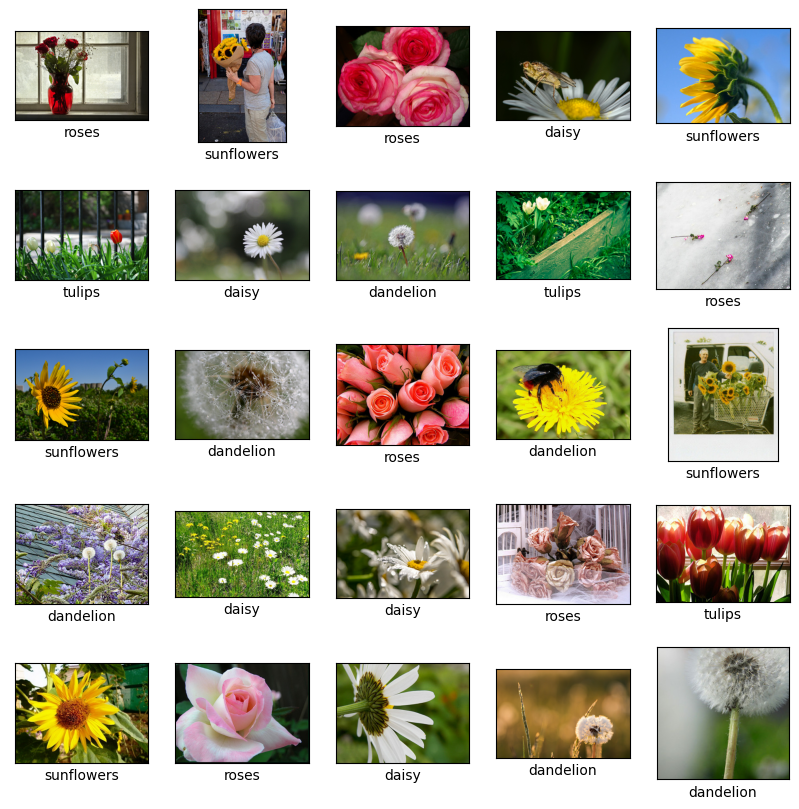

In [12]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 2: Customize the TensorFlow Model

Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0.


In [13]:
model = image_classifier.create(train_data, validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             3413024   


 KerasLayerV1V2)                                                 


 dropout_1 (Dropout)         (None, 1280)              0         


 dense_1 (Dense)             (None, 5)                 6405      


Total params: 3,419,429


Trainable params: 6,405


Non-trainable params: 3,413,024


_________________________________________________________________


None
Epoch 1/5


 1/91 [..............................] - ETA: 2:42 - loss: 1.6496 - accuracy: 0.2500

 2/91 [..............................] - ETA: 16s - loss: 1.6050 - accuracy: 0.2969 

 3/91 [..............................] - ETA: 16s - loss: 1.6025 - accuracy: 0.2917

 4/91 [>.............................] - ETA: 15s - loss: 1.5999 - accuracy: 0.3047

 5/91 [>.............................] - ETA: 15s - loss: 1.5843 - accuracy: 0.3250

 6/91 [>.............................] - ETA: 15s - loss: 1.5975 - accuracy: 0.3073

 7/91 [=>............................] - ETA: 15s - loss: 1.5658 - accuracy: 0.3259

 8/91 [=>............................] - ETA: 15s - loss: 1.5607 - accuracy: 0.3242

 9/91 [=>............................] - ETA: 14s - loss: 1.5316 - accuracy: 0.3299

10/91 [==>...........................] - ETA: 14s - loss: 1.4987 - accuracy: 0.3531

11/91 [==>...........................] - ETA: 14s - loss: 1.4844 - accuracy: 0.3665

12/91 [==>...........................] - ETA: 14s - loss: 1.4457 - accuracy: 0.3958

13/91 [===>..........................] - ETA: 14s - loss: 1.4121 - accuracy: 0.4183

14/91 [===>..........................] - ETA: 14s - loss: 1.3831 - accuracy: 0.4330

15/91 [===>..........................] - ETA: 13s - loss: 1.3575 - accuracy: 0.4500

16/91 [====>.........................] - ETA: 13s - loss: 1.3401 - accuracy: 0.4609

17/91 [====>.........................] - ETA: 13s - loss: 1.3179 - accuracy: 0.4761

18/91 [====>.........................] - ETA: 13s - loss: 1.3005 - accuracy: 0.4861

19/91 [=====>........................] - ETA: 13s - loss: 1.2834 - accuracy: 0.4984

20/91 [=====>........................] - ETA: 13s - loss: 1.2600 - accuracy: 0.5141

21/91 [=====>........................] - ETA: 12s - loss: 1.2469 - accuracy: 0.5193

22/91 [======>.......................] - ETA: 12s - loss: 1.2323 - accuracy: 0.5284

23/91 [======>.......................] - ETA: 12s - loss: 1.2113 - accuracy: 0.5408

24/91 [======>.......................] - ETA: 12s - loss: 1.1986 - accuracy: 0.5456

25/91 [=======>......................] - ETA: 12s - loss: 1.1817 - accuracy: 0.5550

26/91 [=======>......................] - ETA: 12s - loss: 1.1639 - accuracy: 0.5673

27/91 [=======>......................] - ETA: 11s - loss: 1.1484 - accuracy: 0.5787

28/91 [========>.....................] - ETA: 11s - loss: 1.1408 - accuracy: 0.5882

29/91 [========>.....................] - ETA: 11s - loss: 1.1277 - accuracy: 0.5959

30/91 [========>.....................] - ETA: 11s - loss: 1.1135 - accuracy: 0.6042

31/91 [=========>....................] - ETA: 11s - loss: 1.1015 - accuracy: 0.6119

32/91 [=========>....................] - ETA: 10s - loss: 1.0899 - accuracy: 0.6182

33/91 [=========>....................] - ETA: 10s - loss: 1.0801 - accuracy: 0.6222

34/91 [==========>...................] - ETA: 10s - loss: 1.0756 - accuracy: 0.6268

35/91 [==========>...................] - ETA: 10s - loss: 1.0714 - accuracy: 0.6313

36/91 [==========>...................] - ETA: 10s - loss: 1.0641 - accuracy: 0.6354

37/91 [===========>..................] - ETA: 9s - loss: 1.0547 - accuracy: 0.6427 

38/91 [===========>..................] - ETA: 9s - loss: 1.0494 - accuracy: 0.6472

39/91 [===========>..................] - ETA: 9s - loss: 1.0425 - accuracy: 0.6514

40/91 [============>.................] - ETA: 9s - loss: 1.0383 - accuracy: 0.6539

41/91 [============>.................] - ETA: 9s - loss: 1.0332 - accuracy: 0.6578

42/91 [============>.................] - ETA: 8s - loss: 1.0273 - accuracy: 0.6607

43/91 [=============>................] - ETA: 8s - loss: 1.0191 - accuracy: 0.6657

44/91 [=============>................] - ETA: 8s - loss: 1.0112 - accuracy: 0.6712

45/91 [=============>................] - ETA: 8s - loss: 1.0087 - accuracy: 0.6722

46/91 [==============>...............] - ETA: 8s - loss: 1.0046 - accuracy: 0.6753

47/91 [==============>...............] - ETA: 8s - loss: 0.9996 - accuracy: 0.6789

48/91 [==============>...............] - ETA: 7s - loss: 0.9913 - accuracy: 0.6849

49/91 [===============>..............] - ETA: 7s - loss: 0.9845 - accuracy: 0.6888

50/91 [===============>..............] - ETA: 7s - loss: 0.9779 - accuracy: 0.6919

51/91 [===============>..............] - ETA: 7s - loss: 0.9725 - accuracy: 0.6955

52/91 [================>.............] - ETA: 7s - loss: 0.9721 - accuracy: 0.6953

53/91 [================>.............] - ETA: 6s - loss: 0.9679 - accuracy: 0.6975

54/91 [================>.............] - ETA: 6s - loss: 0.9666 - accuracy: 0.6985

55/91 [=================>............] - ETA: 6s - loss: 0.9592 - accuracy: 0.7028

56/91 [=================>............] - ETA: 6s - loss: 0.9554 - accuracy: 0.7048

57/91 [=================>............] - ETA: 6s - loss: 0.9526 - accuracy: 0.7067

58/91 [==================>...........] - ETA: 6s - loss: 0.9511 - accuracy: 0.7080

59/91 [==================>...........] - ETA: 5s - loss: 0.9498 - accuracy: 0.7087

60/91 [==================>...........] - ETA: 5s - loss: 0.9460 - accuracy: 0.7115

61/91 [===================>..........] - ETA: 5s - loss: 0.9430 - accuracy: 0.7136

62/91 [===================>..........] - ETA: 5s - loss: 0.9410 - accuracy: 0.7147

63/91 [===================>..........] - ETA: 5s - loss: 0.9386 - accuracy: 0.7163

64/91 [====================>.........] - ETA: 4s - loss: 0.9358 - accuracy: 0.7192

65/91 [====================>.........] - ETA: 4s - loss: 0.9339 - accuracy: 0.7212

66/91 [====================>.........] - ETA: 4s - loss: 0.9337 - accuracy: 0.7221

67/91 [=====================>........] - ETA: 4s - loss: 0.9305 - accuracy: 0.7243

68/91 [=====================>........] - ETA: 4s - loss: 0.9253 - accuracy: 0.7284

69/91 [=====================>........] - ETA: 4s - loss: 0.9243 - accuracy: 0.7292

70/91 [======================>.......] - ETA: 3s - loss: 0.9216 - accuracy: 0.7312

71/91 [======================>.......] - ETA: 3s - loss: 0.9188 - accuracy: 0.7337

72/91 [======================>.......] - ETA: 3s - loss: 0.9156 - accuracy: 0.7361

73/91 [=======================>......] - ETA: 3s - loss: 0.9148 - accuracy: 0.7376

74/91 [=======================>......] - ETA: 3s - loss: 0.9104 - accuracy: 0.7403

75/91 [=======================>......] - ETA: 2s - loss: 0.9071 - accuracy: 0.7421

76/91 [========================>.....] - ETA: 2s - loss: 0.9047 - accuracy: 0.7426

77/91 [========================>.....] - ETA: 2s - loss: 0.9002 - accuracy: 0.7451

78/91 [========================>.....] - ETA: 2s - loss: 0.8978 - accuracy: 0.7468

79/91 [=========================>....] - ETA: 2s - loss: 0.8957 - accuracy: 0.7476

80/91 [=========================>....] - ETA: 2s - loss: 0.8939 - accuracy: 0.7496

81/91 [=========================>....] - ETA: 1s - loss: 0.8901 - accuracy: 0.7519

82/91 [==========================>...] - ETA: 1s - loss: 0.8875 - accuracy: 0.7530

83/91 [==========================>...] - ETA: 1s - loss: 0.8860 - accuracy: 0.7538

84/91 [==========================>...] - ETA: 1s - loss: 0.8822 - accuracy: 0.7560

85/91 [===========================>..] - ETA: 1s - loss: 0.8814 - accuracy: 0.7570

86/91 [===========================>..] - ETA: 0s - loss: 0.8791 - accuracy: 0.7591

87/91 [===========================>..] - ETA: 0s - loss: 0.8759 - accuracy: 0.7608

88/91 [============================>.] - ETA: 0s - loss: 0.8750 - accuracy: 0.7610

89/91 [============================>.] - ETA: 0s - loss: 0.8722 - accuracy: 0.7630

90/91 [============================>.] - ETA: 0s - loss: 0.8692 - accuracy: 0.7646

91/91 [==============================] - ETA: 0s - loss: 0.8667 - accuracy: 0.7658

91/91 [==============================] - 21s 212ms/step - loss: 0.8667 - accuracy: 0.7658 - val_loss: 0.6696 - val_accuracy: 0.8883


Epoch 2/5


 1/91 [..............................] - ETA: 19s - loss: 0.7877 - accuracy: 0.9062

 2/91 [..............................] - ETA: 15s - loss: 0.7400 - accuracy: 0.9062

 3/91 [..............................] - ETA: 15s - loss: 0.7083 - accuracy: 0.9062

 4/91 [>.............................] - ETA: 15s - loss: 0.7010 - accuracy: 0.8906

 5/91 [>.............................] - ETA: 15s - loss: 0.6909 - accuracy: 0.8938

 6/91 [>.............................] - ETA: 15s - loss: 0.6879 - accuracy: 0.8958

 7/91 [=>............................] - ETA: 14s - loss: 0.6792 - accuracy: 0.8973

 8/91 [=>............................] - ETA: 14s - loss: 0.6864 - accuracy: 0.8984

 9/91 [=>............................] - ETA: 14s - loss: 0.6839 - accuracy: 0.8958

10/91 [==>...........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.8906

11/91 [==>...........................] - ETA: 14s - loss: 0.6868 - accuracy: 0.8892

12/91 [==>...........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.8906

13/91 [===>..........................] - ETA: 13s - loss: 0.6764 - accuracy: 0.8918

14/91 [===>..........................] - ETA: 13s - loss: 0.6684 - accuracy: 0.8973

15/91 [===>..........................] - ETA: 13s - loss: 0.6649 - accuracy: 0.9000

16/91 [====>.........................] - ETA: 13s - loss: 0.6640 - accuracy: 0.8984

17/91 [====>.........................] - ETA: 13s - loss: 0.6679 - accuracy: 0.8971

18/91 [====>.........................] - ETA: 12s - loss: 0.6668 - accuracy: 0.8976

19/91 [=====>........................] - ETA: 12s - loss: 0.6689 - accuracy: 0.8947

20/91 [=====>........................] - ETA: 12s - loss: 0.6641 - accuracy: 0.9000

21/91 [=====>........................] - ETA: 12s - loss: 0.6634 - accuracy: 0.8988

22/91 [======>.......................] - ETA: 12s - loss: 0.6669 - accuracy: 0.8920

23/91 [======>.......................] - ETA: 12s - loss: 0.6650 - accuracy: 0.8913

24/91 [======>.......................] - ETA: 11s - loss: 0.6651 - accuracy: 0.8919

25/91 [=======>......................] - ETA: 11s - loss: 0.6660 - accuracy: 0.8913

26/91 [=======>......................] - ETA: 11s - loss: 0.6622 - accuracy: 0.8930

27/91 [=======>......................] - ETA: 11s - loss: 0.6587 - accuracy: 0.8947

28/91 [========>.....................] - ETA: 11s - loss: 0.6594 - accuracy: 0.8940

29/91 [========>.....................] - ETA: 10s - loss: 0.6561 - accuracy: 0.8976

30/91 [========>.....................] - ETA: 10s - loss: 0.6525 - accuracy: 0.9000

31/91 [=========>....................] - ETA: 10s - loss: 0.6506 - accuracy: 0.9022

32/91 [=========>....................] - ETA: 10s - loss: 0.6499 - accuracy: 0.9014

33/91 [=========>....................] - ETA: 10s - loss: 0.6532 - accuracy: 0.8987

34/91 [==========>...................] - ETA: 10s - loss: 0.6530 - accuracy: 0.8998

35/91 [==========>...................] - ETA: 9s - loss: 0.6559 - accuracy: 0.8982 

36/91 [==========>...................] - ETA: 9s - loss: 0.6565 - accuracy: 0.8993

37/91 [===========>..................] - ETA: 9s - loss: 0.6557 - accuracy: 0.9003

38/91 [===========>..................] - ETA: 9s - loss: 0.6566 - accuracy: 0.9013

39/91 [===========>..................] - ETA: 9s - loss: 0.6563 - accuracy: 0.9014

40/91 [============>.................] - ETA: 9s - loss: 0.6562 - accuracy: 0.9000

41/91 [============>.................] - ETA: 8s - loss: 0.6563 - accuracy: 0.9009

42/91 [============>.................] - ETA: 8s - loss: 0.6545 - accuracy: 0.9025

43/91 [=============>................] - ETA: 8s - loss: 0.6531 - accuracy: 0.9041

44/91 [=============>................] - ETA: 8s - loss: 0.6526 - accuracy: 0.9048

45/91 [=============>................] - ETA: 8s - loss: 0.6537 - accuracy: 0.9049

46/91 [==============>...............] - ETA: 8s - loss: 0.6552 - accuracy: 0.9049

47/91 [==============>...............] - ETA: 7s - loss: 0.6557 - accuracy: 0.9049

48/91 [==============>...............] - ETA: 7s - loss: 0.6540 - accuracy: 0.9062

49/91 [===============>..............] - ETA: 7s - loss: 0.6529 - accuracy: 0.9069

50/91 [===============>..............] - ETA: 7s - loss: 0.6516 - accuracy: 0.9069

51/91 [===============>..............] - ETA: 7s - loss: 0.6514 - accuracy: 0.9069

52/91 [================>.............] - ETA: 6s - loss: 0.6536 - accuracy: 0.9050

53/91 [================>.............] - ETA: 6s - loss: 0.6537 - accuracy: 0.9045

54/91 [================>.............] - ETA: 6s - loss: 0.6568 - accuracy: 0.9022

55/91 [=================>............] - ETA: 6s - loss: 0.6540 - accuracy: 0.9040

56/91 [=================>............] - ETA: 6s - loss: 0.6554 - accuracy: 0.9029

57/91 [=================>............] - ETA: 6s - loss: 0.6564 - accuracy: 0.9019

58/91 [==================>...........] - ETA: 5s - loss: 0.6578 - accuracy: 0.9014

59/91 [==================>...........] - ETA: 5s - loss: 0.6600 - accuracy: 0.8999

60/91 [==================>...........] - ETA: 5s - loss: 0.6604 - accuracy: 0.8995

61/91 [===================>..........] - ETA: 5s - loss: 0.6606 - accuracy: 0.8991

62/91 [===================>..........] - ETA: 5s - loss: 0.6613 - accuracy: 0.8982

63/91 [===================>..........] - ETA: 4s - loss: 0.6618 - accuracy: 0.8978

64/91 [====================>.........] - ETA: 4s - loss: 0.6615 - accuracy: 0.8975

65/91 [====================>.........] - ETA: 4s - loss: 0.6616 - accuracy: 0.8976

66/91 [====================>.........] - ETA: 4s - loss: 0.6644 - accuracy: 0.8963

67/91 [=====================>........] - ETA: 4s - loss: 0.6641 - accuracy: 0.8969

68/91 [=====================>........] - ETA: 4s - loss: 0.6625 - accuracy: 0.8980

69/91 [=====================>........] - ETA: 3s - loss: 0.6645 - accuracy: 0.8967

70/91 [======================>.......] - ETA: 3s - loss: 0.6645 - accuracy: 0.8964

71/91 [======================>.......] - ETA: 3s - loss: 0.6649 - accuracy: 0.8957

72/91 [======================>.......] - ETA: 3s - loss: 0.6648 - accuracy: 0.8963

73/91 [=======================>......] - ETA: 3s - loss: 0.6660 - accuracy: 0.8955

74/91 [=======================>......] - ETA: 3s - loss: 0.6643 - accuracy: 0.8965

75/91 [=======================>......] - ETA: 2s - loss: 0.6631 - accuracy: 0.8979

76/91 [========================>.....] - ETA: 2s - loss: 0.6638 - accuracy: 0.8968

77/91 [========================>.....] - ETA: 2s - loss: 0.6625 - accuracy: 0.8973

78/91 [========================>.....] - ETA: 2s - loss: 0.6615 - accuracy: 0.8974

79/91 [=========================>....] - ETA: 2s - loss: 0.6606 - accuracy: 0.8979

80/91 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.8977

81/91 [=========================>....] - ETA: 1s - loss: 0.6595 - accuracy: 0.8989

82/91 [==========================>...] - ETA: 1s - loss: 0.6592 - accuracy: 0.8994

83/91 [==========================>...] - ETA: 1s - loss: 0.6597 - accuracy: 0.8983

84/91 [==========================>...] - ETA: 1s - loss: 0.6584 - accuracy: 0.8988

85/91 [===========================>..] - ETA: 1s - loss: 0.6593 - accuracy: 0.8982

86/91 [===========================>..] - ETA: 0s - loss: 0.6594 - accuracy: 0.8975

87/91 [===========================>..] - ETA: 0s - loss: 0.6582 - accuracy: 0.8983

88/91 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.8977

89/91 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.8975

90/91 [============================>.] - ETA: 0s - loss: 0.6569 - accuracy: 0.8983

91/91 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.8987

91/91 [==============================] - 19s 204ms/step - loss: 0.6557 - accuracy: 0.8987 - val_loss: 0.6400 - val_accuracy: 0.9019


Epoch 3/5


 1/91 [..............................] - ETA: 19s - loss: 0.7316 - accuracy: 0.8750

 2/91 [..............................] - ETA: 16s - loss: 0.6734 - accuracy: 0.9062

 3/91 [..............................] - ETA: 16s - loss: 0.6749 - accuracy: 0.8958

 4/91 [>.............................] - ETA: 15s - loss: 0.6541 - accuracy: 0.9141

 5/91 [>.............................] - ETA: 16s - loss: 0.6465 - accuracy: 0.9187

 6/91 [>.............................] - ETA: 15s - loss: 0.6538 - accuracy: 0.9115

 7/91 [=>............................] - ETA: 15s - loss: 0.6420 - accuracy: 0.9107

 8/91 [=>............................] - ETA: 15s - loss: 0.6496 - accuracy: 0.9141

 9/91 [=>............................] - ETA: 15s - loss: 0.6462 - accuracy: 0.9236

10/91 [==>...........................] - ETA: 14s - loss: 0.6467 - accuracy: 0.9187

11/91 [==>...........................] - ETA: 14s - loss: 0.6446 - accuracy: 0.9176

12/91 [==>...........................] - ETA: 14s - loss: 0.6381 - accuracy: 0.9219

13/91 [===>..........................] - ETA: 14s - loss: 0.6347 - accuracy: 0.9207

14/91 [===>..........................] - ETA: 14s - loss: 0.6289 - accuracy: 0.9241

15/91 [===>..........................] - ETA: 13s - loss: 0.6280 - accuracy: 0.9250

16/91 [====>.........................] - ETA: 13s - loss: 0.6285 - accuracy: 0.9238

17/91 [====>.........................] - ETA: 13s - loss: 0.6313 - accuracy: 0.9210

18/91 [====>.........................] - ETA: 13s - loss: 0.6306 - accuracy: 0.9201

19/91 [=====>........................] - ETA: 13s - loss: 0.6322 - accuracy: 0.9161

20/91 [=====>........................] - ETA: 12s - loss: 0.6303 - accuracy: 0.9187

21/91 [=====>........................] - ETA: 12s - loss: 0.6333 - accuracy: 0.9182

22/91 [======>.......................] - ETA: 12s - loss: 0.6335 - accuracy: 0.9176

23/91 [======>.......................] - ETA: 12s - loss: 0.6312 - accuracy: 0.9171

24/91 [======>.......................] - ETA: 12s - loss: 0.6303 - accuracy: 0.9180

25/91 [=======>......................] - ETA: 11s - loss: 0.6295 - accuracy: 0.9175

26/91 [=======>......................] - ETA: 11s - loss: 0.6264 - accuracy: 0.9195

27/91 [=======>......................] - ETA: 11s - loss: 0.6252 - accuracy: 0.9201

28/91 [========>.....................] - ETA: 11s - loss: 0.6277 - accuracy: 0.9174

29/91 [========>.....................] - ETA: 11s - loss: 0.6247 - accuracy: 0.9203

30/91 [========>.....................] - ETA: 11s - loss: 0.6212 - accuracy: 0.9219

31/91 [=========>....................] - ETA: 10s - loss: 0.6212 - accuracy: 0.9224

32/91 [=========>....................] - ETA: 10s - loss: 0.6206 - accuracy: 0.9238

33/91 [=========>....................] - ETA: 10s - loss: 0.6240 - accuracy: 0.9205

34/91 [==========>...................] - ETA: 10s - loss: 0.6246 - accuracy: 0.9210

35/91 [==========>...................] - ETA: 10s - loss: 0.6295 - accuracy: 0.9187

36/91 [==========>...................] - ETA: 9s - loss: 0.6282 - accuracy: 0.9210 

37/91 [===========>..................] - ETA: 9s - loss: 0.6275 - accuracy: 0.9223

38/91 [===========>..................] - ETA: 9s - loss: 0.6286 - accuracy: 0.9227

39/91 [===========>..................] - ETA: 9s - loss: 0.6282 - accuracy: 0.9231

40/91 [============>.................] - ETA: 9s - loss: 0.6291 - accuracy: 0.9219

41/91 [============>.................] - ETA: 9s - loss: 0.6301 - accuracy: 0.9223

42/91 [============>.................] - ETA: 8s - loss: 0.6298 - accuracy: 0.9219

43/91 [=============>................] - ETA: 8s - loss: 0.6292 - accuracy: 0.9222

44/91 [=============>................] - ETA: 8s - loss: 0.6287 - accuracy: 0.9226

45/91 [=============>................] - ETA: 8s - loss: 0.6292 - accuracy: 0.9201

46/91 [==============>...............] - ETA: 8s - loss: 0.6291 - accuracy: 0.9198

47/91 [==============>...............] - ETA: 7s - loss: 0.6280 - accuracy: 0.9202

48/91 [==============>...............] - ETA: 7s - loss: 0.6261 - accuracy: 0.9219

49/91 [===============>..............] - ETA: 7s - loss: 0.6251 - accuracy: 0.9222

50/91 [===============>..............] - ETA: 7s - loss: 0.6240 - accuracy: 0.9225

51/91 [===============>..............] - ETA: 7s - loss: 0.6229 - accuracy: 0.9228

52/91 [================>.............] - ETA: 7s - loss: 0.6240 - accuracy: 0.9213

53/91 [================>.............] - ETA: 6s - loss: 0.6239 - accuracy: 0.9210

54/91 [================>.............] - ETA: 6s - loss: 0.6262 - accuracy: 0.9196

55/91 [=================>............] - ETA: 6s - loss: 0.6244 - accuracy: 0.9205

56/91 [=================>............] - ETA: 6s - loss: 0.6258 - accuracy: 0.9196

57/91 [=================>............] - ETA: 6s - loss: 0.6271 - accuracy: 0.9183

58/91 [==================>...........] - ETA: 5s - loss: 0.6289 - accuracy: 0.9165

59/91 [==================>...........] - ETA: 5s - loss: 0.6303 - accuracy: 0.9163

60/91 [==================>...........] - ETA: 5s - loss: 0.6295 - accuracy: 0.9167

61/91 [===================>..........] - ETA: 5s - loss: 0.6295 - accuracy: 0.9165

62/91 [===================>..........] - ETA: 5s - loss: 0.6295 - accuracy: 0.9163

63/91 [===================>..........] - ETA: 5s - loss: 0.6300 - accuracy: 0.9157

64/91 [====================>.........] - ETA: 4s - loss: 0.6308 - accuracy: 0.9155

65/91 [====================>.........] - ETA: 4s - loss: 0.6310 - accuracy: 0.9154

66/91 [====================>.........] - ETA: 4s - loss: 0.6331 - accuracy: 0.9134

67/91 [=====================>........] - ETA: 4s - loss: 0.6329 - accuracy: 0.9137

68/91 [=====================>........] - ETA: 4s - loss: 0.6320 - accuracy: 0.9141

69/91 [=====================>........] - ETA: 3s - loss: 0.6344 - accuracy: 0.9117

70/91 [======================>.......] - ETA: 3s - loss: 0.6343 - accuracy: 0.9112

71/91 [======================>.......] - ETA: 3s - loss: 0.6340 - accuracy: 0.9111

72/91 [======================>.......] - ETA: 3s - loss: 0.6343 - accuracy: 0.9102

73/91 [=======================>......] - ETA: 3s - loss: 0.6351 - accuracy: 0.9097

74/91 [=======================>......] - ETA: 3s - loss: 0.6339 - accuracy: 0.9105

75/91 [=======================>......] - ETA: 2s - loss: 0.6323 - accuracy: 0.9117

76/91 [========================>.....] - ETA: 2s - loss: 0.6324 - accuracy: 0.9112

77/91 [========================>.....] - ETA: 2s - loss: 0.6311 - accuracy: 0.9119

78/91 [========================>.....] - ETA: 2s - loss: 0.6307 - accuracy: 0.9127

79/91 [=========================>....] - ETA: 2s - loss: 0.6302 - accuracy: 0.9126

80/91 [=========================>....] - ETA: 1s - loss: 0.6309 - accuracy: 0.9121

81/91 [=========================>....] - ETA: 1s - loss: 0.6292 - accuracy: 0.9132

82/91 [==========================>...] - ETA: 1s - loss: 0.6288 - accuracy: 0.9135

83/91 [==========================>...] - ETA: 1s - loss: 0.6290 - accuracy: 0.9138

84/91 [==========================>...] - ETA: 1s - loss: 0.6277 - accuracy: 0.9144

85/91 [===========================>..] - ETA: 1s - loss: 0.6282 - accuracy: 0.9143

86/91 [===========================>..] - ETA: 0s - loss: 0.6292 - accuracy: 0.9139

87/91 [===========================>..] - ETA: 0s - loss: 0.6278 - accuracy: 0.9149

88/91 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.9148

89/91 [============================>.] - ETA: 0s - loss: 0.6276 - accuracy: 0.9157

90/91 [============================>.] - ETA: 0s - loss: 0.6266 - accuracy: 0.9167

91/91 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.9169

91/91 [==============================] - 19s 206ms/step - loss: 0.6261 - accuracy: 0.9169 - val_loss: 0.6257 - val_accuracy: 0.9019


Epoch 4/5


 1/91 [..............................] - ETA: 18s - loss: 0.6174 - accuracy: 0.9688

 2/91 [..............................] - ETA: 16s - loss: 0.6024 - accuracy: 0.9531

 3/91 [..............................] - ETA: 15s - loss: 0.5943 - accuracy: 0.9479

 4/91 [>.............................] - ETA: 15s - loss: 0.5916 - accuracy: 0.9453

 5/91 [>.............................] - ETA: 15s - loss: 0.5928 - accuracy: 0.9438

 6/91 [>.............................] - ETA: 14s - loss: 0.5925 - accuracy: 0.9427

 7/91 [=>............................] - ETA: 14s - loss: 0.5940 - accuracy: 0.9330

 8/91 [=>............................] - ETA: 14s - loss: 0.5993 - accuracy: 0.9375

 9/91 [=>............................] - ETA: 14s - loss: 0.5947 - accuracy: 0.9410

10/91 [==>...........................] - ETA: 14s - loss: 0.5920 - accuracy: 0.9438

11/91 [==>...........................] - ETA: 14s - loss: 0.5958 - accuracy: 0.9432

12/91 [==>...........................] - ETA: 13s - loss: 0.5954 - accuracy: 0.9401

13/91 [===>..........................] - ETA: 13s - loss: 0.5953 - accuracy: 0.9399

14/91 [===>..........................] - ETA: 13s - loss: 0.5898 - accuracy: 0.9420

15/91 [===>..........................] - ETA: 13s - loss: 0.5882 - accuracy: 0.9396

16/91 [====>.........................] - ETA: 13s - loss: 0.5930 - accuracy: 0.9355

17/91 [====>.........................] - ETA: 12s - loss: 0.5933 - accuracy: 0.9357

18/91 [====>.........................] - ETA: 12s - loss: 0.5913 - accuracy: 0.9375

19/91 [=====>........................] - ETA: 12s - loss: 0.5936 - accuracy: 0.9375

20/91 [=====>........................] - ETA: 12s - loss: 0.5943 - accuracy: 0.9375

21/91 [=====>........................] - ETA: 12s - loss: 0.5972 - accuracy: 0.9360

22/91 [======>.......................] - ETA: 12s - loss: 0.5966 - accuracy: 0.9375

23/91 [======>.......................] - ETA: 11s - loss: 0.5955 - accuracy: 0.9389

24/91 [======>.......................] - ETA: 11s - loss: 0.5953 - accuracy: 0.9401

25/91 [=======>......................] - ETA: 11s - loss: 0.5978 - accuracy: 0.9375

26/91 [=======>......................] - ETA: 11s - loss: 0.5947 - accuracy: 0.9387

27/91 [=======>......................] - ETA: 11s - loss: 0.5930 - accuracy: 0.9398

28/91 [========>.....................] - ETA: 11s - loss: 0.5958 - accuracy: 0.9364

29/91 [========>.....................] - ETA: 10s - loss: 0.5946 - accuracy: 0.9375

30/91 [========>.....................] - ETA: 10s - loss: 0.5925 - accuracy: 0.9385

31/91 [=========>....................] - ETA: 10s - loss: 0.5925 - accuracy: 0.9395

32/91 [=========>....................] - ETA: 10s - loss: 0.5913 - accuracy: 0.9414

33/91 [=========>....................] - ETA: 10s - loss: 0.5924 - accuracy: 0.9413

34/91 [==========>...................] - ETA: 9s - loss: 0.5926 - accuracy: 0.9421 

35/91 [==========>...................] - ETA: 9s - loss: 0.5955 - accuracy: 0.9411

36/91 [==========>...................] - ETA: 9s - loss: 0.5951 - accuracy: 0.9418

37/91 [===========>..................] - ETA: 9s - loss: 0.5947 - accuracy: 0.9409

38/91 [===========>..................] - ETA: 9s - loss: 0.5954 - accuracy: 0.9400

39/91 [===========>..................] - ETA: 9s - loss: 0.5946 - accuracy: 0.9407

40/91 [============>.................] - ETA: 8s - loss: 0.5949 - accuracy: 0.9398

41/91 [============>.................] - ETA: 8s - loss: 0.5946 - accuracy: 0.9398

42/91 [============>.................] - ETA: 8s - loss: 0.5941 - accuracy: 0.9397

43/91 [=============>................] - ETA: 8s - loss: 0.5932 - accuracy: 0.9390

44/91 [=============>................] - ETA: 8s - loss: 0.5923 - accuracy: 0.9396

45/91 [=============>................] - ETA: 8s - loss: 0.5931 - accuracy: 0.9389

46/91 [==============>...............] - ETA: 7s - loss: 0.5941 - accuracy: 0.9382

47/91 [==============>...............] - ETA: 7s - loss: 0.5945 - accuracy: 0.9382

48/91 [==============>...............] - ETA: 7s - loss: 0.5936 - accuracy: 0.9395

49/91 [===============>..............] - ETA: 7s - loss: 0.5930 - accuracy: 0.9394

50/91 [===============>..............] - ETA: 7s - loss: 0.5924 - accuracy: 0.9394

51/91 [===============>..............] - ETA: 7s - loss: 0.5917 - accuracy: 0.9393

52/91 [================>.............] - ETA: 6s - loss: 0.5941 - accuracy: 0.9381

53/91 [================>.............] - ETA: 6s - loss: 0.5937 - accuracy: 0.9381

54/91 [================>.............] - ETA: 6s - loss: 0.5967 - accuracy: 0.9358

55/91 [=================>............] - ETA: 6s - loss: 0.5948 - accuracy: 0.9369

56/91 [=================>............] - ETA: 6s - loss: 0.5966 - accuracy: 0.9364

57/91 [=================>............] - ETA: 5s - loss: 0.5979 - accuracy: 0.9353

58/91 [==================>...........] - ETA: 5s - loss: 0.5988 - accuracy: 0.9353

59/91 [==================>...........] - ETA: 5s - loss: 0.5998 - accuracy: 0.9343

60/91 [==================>...........] - ETA: 5s - loss: 0.6001 - accuracy: 0.9344

61/91 [===================>..........] - ETA: 5s - loss: 0.6006 - accuracy: 0.9339

62/91 [===================>..........] - ETA: 5s - loss: 0.6011 - accuracy: 0.9340

63/91 [===================>..........] - ETA: 4s - loss: 0.6012 - accuracy: 0.9330

64/91 [====================>.........] - ETA: 4s - loss: 0.6019 - accuracy: 0.9321

65/91 [====================>.........] - ETA: 4s - loss: 0.6024 - accuracy: 0.9322

66/91 [====================>.........] - ETA: 4s - loss: 0.6039 - accuracy: 0.9313

67/91 [=====================>........] - ETA: 4s - loss: 0.6033 - accuracy: 0.9319

68/91 [=====================>........] - ETA: 4s - loss: 0.6025 - accuracy: 0.9320

69/91 [=====================>........] - ETA: 3s - loss: 0.6045 - accuracy: 0.9307

70/91 [======================>.......] - ETA: 3s - loss: 0.6045 - accuracy: 0.9304

71/91 [======================>.......] - ETA: 3s - loss: 0.6050 - accuracy: 0.9305

72/91 [======================>.......] - ETA: 3s - loss: 0.6058 - accuracy: 0.9293

73/91 [=======================>......] - ETA: 3s - loss: 0.6063 - accuracy: 0.9285

74/91 [=======================>......] - ETA: 2s - loss: 0.6049 - accuracy: 0.9295

75/91 [=======================>......] - ETA: 2s - loss: 0.6038 - accuracy: 0.9304

76/91 [========================>.....] - ETA: 2s - loss: 0.6040 - accuracy: 0.9293

77/91 [========================>.....] - ETA: 2s - loss: 0.6027 - accuracy: 0.9302

78/91 [========================>.....] - ETA: 2s - loss: 0.6019 - accuracy: 0.9311

79/91 [=========================>....] - ETA: 2s - loss: 0.6021 - accuracy: 0.9308

80/91 [=========================>....] - ETA: 1s - loss: 0.6022 - accuracy: 0.9305

81/91 [=========================>....] - ETA: 1s - loss: 0.6011 - accuracy: 0.9309

82/91 [==========================>...] - ETA: 1s - loss: 0.6009 - accuracy: 0.9310

83/91 [==========================>...] - ETA: 1s - loss: 0.6011 - accuracy: 0.9307

84/91 [==========================>...] - ETA: 1s - loss: 0.5998 - accuracy: 0.9315

85/91 [===========================>..] - ETA: 1s - loss: 0.6007 - accuracy: 0.9309

86/91 [===========================>..] - ETA: 0s - loss: 0.6012 - accuracy: 0.9310

87/91 [===========================>..] - ETA: 0s - loss: 0.6004 - accuracy: 0.9310

88/91 [============================>.] - ETA: 0s - loss: 0.6005 - accuracy: 0.9311

89/91 [============================>.] - ETA: 0s - loss: 0.6003 - accuracy: 0.9315

90/91 [============================>.] - ETA: 0s - loss: 0.5994 - accuracy: 0.9323

91/91 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.9327

91/91 [==============================] - 18s 200ms/step - loss: 0.5985 - accuracy: 0.9327 - val_loss: 0.6170 - val_accuracy: 0.9101


Epoch 5/5


 1/91 [..............................] - ETA: 18s - loss: 0.5926 - accuracy: 0.9375

 2/91 [..............................] - ETA: 15s - loss: 0.5950 - accuracy: 0.9375

 3/91 [..............................] - ETA: 15s - loss: 0.5740 - accuracy: 0.9479

 4/91 [>.............................] - ETA: 14s - loss: 0.5800 - accuracy: 0.9453

 5/91 [>.............................] - ETA: 14s - loss: 0.5777 - accuracy: 0.9438

 6/91 [>.............................] - ETA: 14s - loss: 0.5828 - accuracy: 0.9375

 7/91 [=>............................] - ETA: 14s - loss: 0.5744 - accuracy: 0.9420

 8/91 [=>............................] - ETA: 14s - loss: 0.5839 - accuracy: 0.9453

 9/91 [=>............................] - ETA: 14s - loss: 0.5788 - accuracy: 0.9514

10/91 [==>...........................] - ETA: 14s - loss: 0.5790 - accuracy: 0.9531

11/91 [==>...........................] - ETA: 13s - loss: 0.5829 - accuracy: 0.9432

12/91 [==>...........................] - ETA: 13s - loss: 0.5801 - accuracy: 0.9453

13/91 [===>..........................] - ETA: 13s - loss: 0.5782 - accuracy: 0.9423

14/91 [===>..........................] - ETA: 13s - loss: 0.5705 - accuracy: 0.9464

15/91 [===>..........................] - ETA: 13s - loss: 0.5710 - accuracy: 0.9479

16/91 [====>.........................] - ETA: 13s - loss: 0.5732 - accuracy: 0.9453

17/91 [====>.........................] - ETA: 13s - loss: 0.5765 - accuracy: 0.9412

18/91 [====>.........................] - ETA: 12s - loss: 0.5766 - accuracy: 0.9375

19/91 [=====>........................] - ETA: 12s - loss: 0.5798 - accuracy: 0.9359

20/91 [=====>........................] - ETA: 12s - loss: 0.5806 - accuracy: 0.9375

21/91 [=====>........................] - ETA: 12s - loss: 0.5839 - accuracy: 0.9345

22/91 [======>.......................] - ETA: 12s - loss: 0.5843 - accuracy: 0.9361

23/91 [======>.......................] - ETA: 11s - loss: 0.5836 - accuracy: 0.9361

24/91 [======>.......................] - ETA: 11s - loss: 0.5834 - accuracy: 0.9362

25/91 [=======>......................] - ETA: 11s - loss: 0.5831 - accuracy: 0.9362

26/91 [=======>......................] - ETA: 11s - loss: 0.5815 - accuracy: 0.9363

27/91 [=======>......................] - ETA: 11s - loss: 0.5812 - accuracy: 0.9375

28/91 [========>.....................] - ETA: 11s - loss: 0.5829 - accuracy: 0.9353

29/91 [========>.....................] - ETA: 10s - loss: 0.5819 - accuracy: 0.9364

30/91 [========>.....................] - ETA: 10s - loss: 0.5787 - accuracy: 0.9375

31/91 [=========>....................] - ETA: 10s - loss: 0.5779 - accuracy: 0.9385

32/91 [=========>....................] - ETA: 10s - loss: 0.5770 - accuracy: 0.9404

33/91 [=========>....................] - ETA: 10s - loss: 0.5789 - accuracy: 0.9394

34/91 [==========>...................] - ETA: 10s - loss: 0.5811 - accuracy: 0.9384

35/91 [==========>...................] - ETA: 9s - loss: 0.5854 - accuracy: 0.9357 

36/91 [==========>...................] - ETA: 9s - loss: 0.5861 - accuracy: 0.9366

37/91 [===========>..................] - ETA: 9s - loss: 0.5851 - accuracy: 0.9383

38/91 [===========>..................] - ETA: 9s - loss: 0.5860 - accuracy: 0.9375

39/91 [===========>..................] - ETA: 9s - loss: 0.5854 - accuracy: 0.9383

40/91 [============>.................] - ETA: 8s - loss: 0.5856 - accuracy: 0.9391

41/91 [============>.................] - ETA: 8s - loss: 0.5862 - accuracy: 0.9383

42/91 [============>.................] - ETA: 8s - loss: 0.5864 - accuracy: 0.9375

43/91 [=============>................] - ETA: 8s - loss: 0.5855 - accuracy: 0.9382

44/91 [=============>................] - ETA: 8s - loss: 0.5857 - accuracy: 0.9382

45/91 [=============>................] - ETA: 8s - loss: 0.5873 - accuracy: 0.9368

46/91 [==============>...............] - ETA: 7s - loss: 0.5881 - accuracy: 0.9361

47/91 [==============>...............] - ETA: 7s - loss: 0.5885 - accuracy: 0.9362

48/91 [==============>...............] - ETA: 7s - loss: 0.5874 - accuracy: 0.9362

49/91 [===============>..............] - ETA: 7s - loss: 0.5868 - accuracy: 0.9362

50/91 [===============>..............] - ETA: 7s - loss: 0.5857 - accuracy: 0.9375

51/91 [===============>..............] - ETA: 7s - loss: 0.5849 - accuracy: 0.9381

52/91 [================>.............] - ETA: 6s - loss: 0.5870 - accuracy: 0.9369

53/91 [================>.............] - ETA: 6s - loss: 0.5870 - accuracy: 0.9375

54/91 [================>.............] - ETA: 6s - loss: 0.5894 - accuracy: 0.9352

55/91 [=================>............] - ETA: 6s - loss: 0.5874 - accuracy: 0.9364

56/91 [=================>............] - ETA: 6s - loss: 0.5896 - accuracy: 0.9358

57/91 [=================>............] - ETA: 6s - loss: 0.5913 - accuracy: 0.9342

58/91 [==================>...........] - ETA: 5s - loss: 0.5937 - accuracy: 0.9321

59/91 [==================>...........] - ETA: 5s - loss: 0.5941 - accuracy: 0.9327

60/91 [==================>...........] - ETA: 5s - loss: 0.5938 - accuracy: 0.9328

61/91 [===================>..........] - ETA: 5s - loss: 0.5940 - accuracy: 0.9324

62/91 [===================>..........] - ETA: 5s - loss: 0.5944 - accuracy: 0.9315

63/91 [===================>..........] - ETA: 4s - loss: 0.5949 - accuracy: 0.9306

64/91 [====================>.........] - ETA: 4s - loss: 0.5953 - accuracy: 0.9297

65/91 [====================>.........] - ETA: 4s - loss: 0.5961 - accuracy: 0.9293

66/91 [====================>.........] - ETA: 4s - loss: 0.5968 - accuracy: 0.9295

67/91 [=====================>........] - ETA: 4s - loss: 0.5963 - accuracy: 0.9305

68/91 [=====================>........] - ETA: 4s - loss: 0.5950 - accuracy: 0.9315

69/91 [=====================>........] - ETA: 3s - loss: 0.5967 - accuracy: 0.9298

70/91 [======================>.......] - ETA: 3s - loss: 0.5959 - accuracy: 0.9308

71/91 [======================>.......] - ETA: 3s - loss: 0.5961 - accuracy: 0.9309

72/91 [======================>.......] - ETA: 3s - loss: 0.5968 - accuracy: 0.9301

73/91 [=======================>......] - ETA: 3s - loss: 0.5974 - accuracy: 0.9298

74/91 [=======================>......] - ETA: 3s - loss: 0.5963 - accuracy: 0.9307

75/91 [=======================>......] - ETA: 2s - loss: 0.5948 - accuracy: 0.9317

76/91 [========================>.....] - ETA: 2s - loss: 0.5951 - accuracy: 0.9309

77/91 [========================>.....] - ETA: 2s - loss: 0.5937 - accuracy: 0.9318

78/91 [========================>.....] - ETA: 2s - loss: 0.5929 - accuracy: 0.9327

79/91 [=========================>....] - ETA: 2s - loss: 0.5930 - accuracy: 0.9328

80/91 [=========================>....] - ETA: 1s - loss: 0.5940 - accuracy: 0.9328

81/91 [=========================>....] - ETA: 1s - loss: 0.5929 - accuracy: 0.9336

82/91 [==========================>...] - ETA: 1s - loss: 0.5923 - accuracy: 0.9341

83/91 [==========================>...] - ETA: 1s - loss: 0.5926 - accuracy: 0.9341

84/91 [==========================>...] - ETA: 1s - loss: 0.5914 - accuracy: 0.9349

85/91 [===========================>..] - ETA: 1s - loss: 0.5921 - accuracy: 0.9335

86/91 [===========================>..] - ETA: 0s - loss: 0.5928 - accuracy: 0.9331

87/91 [===========================>..] - ETA: 0s - loss: 0.5920 - accuracy: 0.9332

88/91 [============================>.] - ETA: 0s - loss: 0.5919 - accuracy: 0.9332

89/91 [============================>.] - ETA: 0s - loss: 0.5916 - accuracy: 0.9336

90/91 [============================>.] - ETA: 0s - loss: 0.5911 - accuracy: 0.9337

91/91 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.9337

91/91 [==============================] - 18s 202ms/step - loss: 0.5905 - accuracy: 0.9337 - val_loss: 0.6125 - val_accuracy: 0.9128


Have a look at the detailed model structure.

In [14]:
model.summary()

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             3413024   


 KerasLayerV1V2)                                                 


 dropout_1 (Dropout)         (None, 1280)              0         


 dense_1 (Dense)             (None, 5)                 6405      


Total params: 3,419,429


Trainable params: 6,405


Non-trainable params: 3,413,024


_________________________________________________________________


### Step 3: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [15]:
loss, accuracy = model.evaluate(test_data)

 1/12 [=>............................] - ETA: 6s - loss: 0.6871 - accuracy: 0.8750

 2/12 [====>.........................] - ETA: 1s - loss: 0.6532 - accuracy: 0.8906

 3/12 [======>.......................] - ETA: 1s - loss: 0.6305 - accuracy: 0.8958

 4/12 [=========>....................] - ETA: 1s - loss: 0.6331 - accuracy: 0.8984

 5/12 [===========>..................] - ETA: 1s - loss: 0.6166 - accuracy: 0.9125

 6/12 [==============>...............] - ETA: 1s - loss: 0.6004 - accuracy: 0.9219

 7/12 [================>.............] - ETA: 0s - loss: 0.6188 - accuracy: 0.9107

 8/12 [===================>..........] - ETA: 0s - loss: 0.6303 - accuracy: 0.9023

 9/12 [=====================>........] - ETA: 0s - loss: 0.6220 - accuracy: 0.9097

10/12 [========================>.....] - ETA: 0s - loss: 0.6205 - accuracy: 0.9094

11/12 [==========================>...] - ETA: 0s - loss: 0.6263 - accuracy: 0.9091

12/12 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.9046

12/12 [==============================] - 2s 163ms/step - loss: 0.6336 - accuracy: 0.9046


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

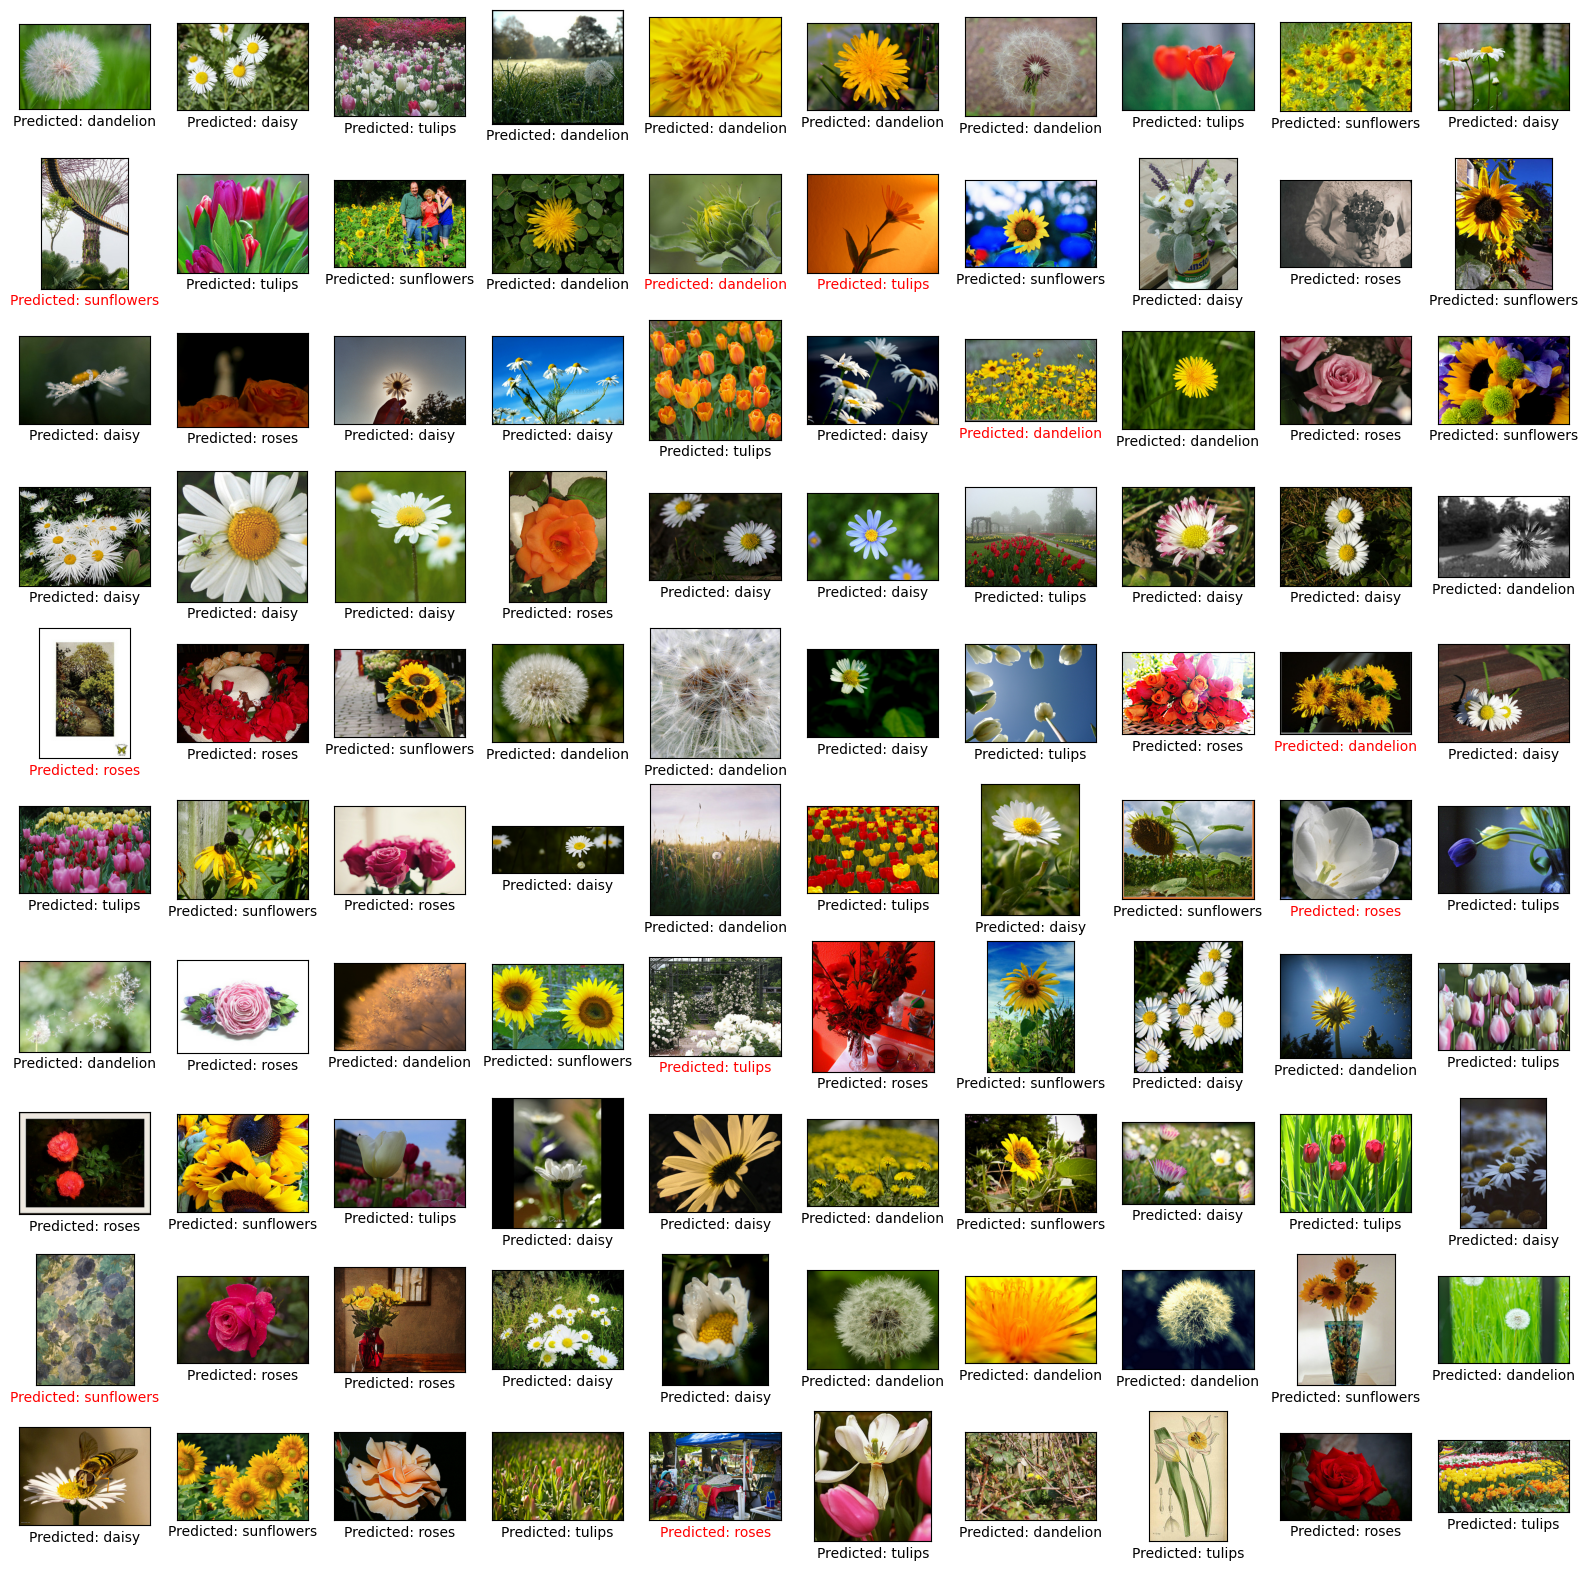

In [16]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 4: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/models/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is full integer quantization for the image classification task.

In [17]:
model.export(export_dir='.')

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp98j40l2h/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp98j40l2h/assets


2024-07-19 12:40:15.003017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-07-19 12:40:15.857528: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-07-19 12:40:15.857578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmp9hfynxdy/labels.txt


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmp9hfynxdy/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


See the image classification [examples guide](https://www.tensorflow.org/lite/examples/image_classification/overview) for more details about how to integrate the TensorFlow Lite model into mobile apps.

This model can be integrated into an Android or an iOS app using the [ImageClassifier API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

The allowed export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`

By default, it just exports TensorFlow Lite model with metadata. You can also selectively export different files. For instance, exporting only the label file as follows:

In [18]:
model.export(export_dir='.', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in ./labels.txt


INFO:tensorflow:Saving labels in ./labels.txt


You can also evaluate the tflite model with the `evaluate_tflite` method.

In [19]:
model.evaluate_tflite('model.tflite', test_data)

{'accuracy': 0.9128065395095368}

## Advanced Usage

The `create` function is the critical part of this library. It uses transfer learning with a pretrained model similar to the [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

The `create` function contains the following steps:

1.   Split the data into training, validation, testing data according to parameter `validation_ratio` and `test_ratio`. The default value of `validation_ratio` and `test_ratio` are `0.1` and `0.1`.
2.   Download a [Image Feature Vector](https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector) as the base model from TensorFlow Hub. The default pre-trained model is  EfficientNet-Lite0.
3.   Add a classifier head with a Dropout Layer with `dropout_rate` between head layer and pre-trained model. The default `dropout_rate` is the default `dropout_rate` value from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub.
4.   Preprocess the raw input data. Currently, preprocessing steps including normalizing the value of each image pixel to model input scale and resizing it to model input size.   EfficientNet-Lite0 have the input scale `[0, 1]` and the input image size `[224, 224, 3]`.
5.   Feed the data into the classifier model. By default, the training parameters such as training epochs, batch size, learning rate, momentum are the default values from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub. Only the classifier head is trained.


In this section, we describe several advanced topics, including switching to a different image classification model, changing the training hyperparameters etc.


## Customize Post-training quantization on the TensorFLow Lite model


[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.


Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

In [20]:
config = QuantizationConfig.for_float16()

Then we export the TensorFlow Lite model with such configuration.

In [21]:
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpj0o2n8ol/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpj0o2n8ol/assets


2024-07-19 12:47:14.901056: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Label file is inside the TFLite model with metadata.


2024-07-19 12:47:15.764806: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-07-19 12:47:15.764854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmpu6wou7r8/labels.txt


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmpu6wou7r8/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_fp16.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_fp16.tflite


In Colab, you can download the model named `model_fp16.tflite` from the left sidebar, same as the uploading part mentioned above.

## Change the model


### Change to the model that's supported in this library.

This library supports  EfficientNet-Lite models, MobileNetV2, ResNet50 by now. [EfficientNet-Lite](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite) are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. The default model is EfficientNet-Lite0.

We could switch model to MobileNetV2 by just setting parameter `model_spec` to the MobileNetV2 model specification in `create` method.

In [22]:
model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 hub_keras_layer_v1v2_2 (Hub  (None, 1280)             2257984   


 KerasLayerV1V2)                                                 


 dropout_2 (Dropout)         (None, 1280)              0         


 dense_2 (Dense)             (None, 5)                 6405      


Total params: 2,264,389


Trainable params: 6,405


Non-trainable params: 2,257,984


_________________________________________________________________


None
Epoch 1/5


 1/91 [..............................] - ETA: 4:05 - loss: 2.3007 - accuracy: 0.1250

 2/91 [..............................] - ETA: 13s - loss: 2.2311 - accuracy: 0.1719 

 3/91 [..............................] - ETA: 13s - loss: 2.0858 - accuracy: 0.1979

 4/91 [>.............................] - ETA: 13s - loss: 1.9612 - accuracy: 0.2266

 5/91 [>.............................] - ETA: 13s - loss: 1.9431 - accuracy: 0.2375

 6/91 [>.............................] - ETA: 13s - loss: 1.8584 - accuracy: 0.2656

 7/91 [=>............................] - ETA: 13s - loss: 1.8197 - accuracy: 0.3036

 8/91 [=>............................] - ETA: 13s - loss: 1.7681 - accuracy: 0.3203

 9/91 [=>............................] - ETA: 13s - loss: 1.7293 - accuracy: 0.3542

10/91 [==>...........................] - ETA: 13s - loss: 1.6794 - accuracy: 0.3750

11/91 [==>...........................] - ETA: 12s - loss: 1.6196 - accuracy: 0.4062

12/91 [==>...........................] - ETA: 12s - loss: 1.5698 - accuracy: 0.4271

13/91 [===>..........................] - ETA: 12s - loss: 1.5290 - accuracy: 0.4519

14/91 [===>..........................] - ETA: 12s - loss: 1.4718 - accuracy: 0.4777

15/91 [===>..........................] - ETA: 12s - loss: 1.4300 - accuracy: 0.5000

16/91 [====>.........................] - ETA: 12s - loss: 1.4149 - accuracy: 0.5039

17/91 [====>.........................] - ETA: 12s - loss: 1.3808 - accuracy: 0.5239

18/91 [====>.........................] - ETA: 11s - loss: 1.3660 - accuracy: 0.5295

19/91 [=====>........................] - ETA: 11s - loss: 1.3498 - accuracy: 0.5378

20/91 [=====>........................] - ETA: 11s - loss: 1.3287 - accuracy: 0.5469

21/91 [=====>........................] - ETA: 11s - loss: 1.3085 - accuracy: 0.5551

22/91 [======>.......................] - ETA: 11s - loss: 1.2929 - accuracy: 0.5639

23/91 [======>.......................] - ETA: 11s - loss: 1.2695 - accuracy: 0.5761

24/91 [======>.......................] - ETA: 11s - loss: 1.2585 - accuracy: 0.5833

25/91 [=======>......................] - ETA: 10s - loss: 1.2396 - accuracy: 0.5938

26/91 [=======>......................] - ETA: 10s - loss: 1.2232 - accuracy: 0.6022

27/91 [=======>......................] - ETA: 10s - loss: 1.2065 - accuracy: 0.6111

28/91 [========>.....................] - ETA: 10s - loss: 1.1930 - accuracy: 0.6183

29/91 [========>.....................] - ETA: 10s - loss: 1.1857 - accuracy: 0.6250

30/91 [========>.....................] - ETA: 10s - loss: 1.1685 - accuracy: 0.6344

31/91 [=========>....................] - ETA: 9s - loss: 1.1645 - accuracy: 0.6371 

32/91 [=========>....................] - ETA: 9s - loss: 1.1534 - accuracy: 0.6426

33/91 [=========>....................] - ETA: 9s - loss: 1.1460 - accuracy: 0.6468

34/91 [==========>...................] - ETA: 9s - loss: 1.1401 - accuracy: 0.6498

35/91 [==========>...................] - ETA: 9s - loss: 1.1338 - accuracy: 0.6536

36/91 [==========>...................] - ETA: 8s - loss: 1.1242 - accuracy: 0.6562

37/91 [===========>..................] - ETA: 8s - loss: 1.1179 - accuracy: 0.6605

38/91 [===========>..................] - ETA: 8s - loss: 1.1100 - accuracy: 0.6620

39/91 [===========>..................] - ETA: 8s - loss: 1.1018 - accuracy: 0.6667

40/91 [============>.................] - ETA: 8s - loss: 1.0998 - accuracy: 0.6680

41/91 [============>.................] - ETA: 8s - loss: 1.0887 - accuracy: 0.6738

42/91 [============>.................] - ETA: 7s - loss: 1.0894 - accuracy: 0.6749

43/91 [=============>................] - ETA: 7s - loss: 1.0814 - accuracy: 0.6788

44/91 [=============>................] - ETA: 7s - loss: 1.0729 - accuracy: 0.6832

45/91 [=============>................] - ETA: 7s - loss: 1.0716 - accuracy: 0.6833

46/91 [==============>...............] - ETA: 7s - loss: 1.0678 - accuracy: 0.6861

47/91 [==============>...............] - ETA: 7s - loss: 1.0609 - accuracy: 0.6902

48/91 [==============>...............] - ETA: 6s - loss: 1.0544 - accuracy: 0.6934

49/91 [===============>..............] - ETA: 6s - loss: 1.0477 - accuracy: 0.6971

50/91 [===============>..............] - ETA: 6s - loss: 1.0428 - accuracy: 0.6988

51/91 [===============>..............] - ETA: 6s - loss: 1.0378 - accuracy: 0.7010

52/91 [================>.............] - ETA: 6s - loss: 1.0344 - accuracy: 0.7019

53/91 [================>.............] - ETA: 6s - loss: 1.0278 - accuracy: 0.7040

54/91 [================>.............] - ETA: 5s - loss: 1.0248 - accuracy: 0.7054

55/91 [=================>............] - ETA: 5s - loss: 1.0205 - accuracy: 0.7091

56/91 [=================>............] - ETA: 5s - loss: 1.0167 - accuracy: 0.7109

57/91 [=================>............] - ETA: 5s - loss: 1.0148 - accuracy: 0.7122

58/91 [==================>...........] - ETA: 5s - loss: 1.0090 - accuracy: 0.7139

59/91 [==================>...........] - ETA: 5s - loss: 1.0064 - accuracy: 0.7145

60/91 [==================>...........] - ETA: 4s - loss: 1.0033 - accuracy: 0.7167

61/91 [===================>..........] - ETA: 4s - loss: 0.9993 - accuracy: 0.7188

62/91 [===================>..........] - ETA: 4s - loss: 0.9992 - accuracy: 0.7198

63/91 [===================>..........] - ETA: 4s - loss: 0.9936 - accuracy: 0.7227

64/91 [====================>.........] - ETA: 4s - loss: 0.9901 - accuracy: 0.7251

65/91 [====================>.........] - ETA: 4s - loss: 0.9868 - accuracy: 0.7274

66/91 [====================>.........] - ETA: 4s - loss: 0.9856 - accuracy: 0.7287

67/91 [=====================>........] - ETA: 3s - loss: 0.9838 - accuracy: 0.7295

68/91 [=====================>........] - ETA: 3s - loss: 0.9805 - accuracy: 0.7316

69/91 [=====================>........] - ETA: 3s - loss: 0.9816 - accuracy: 0.7305

70/91 [======================>.......] - ETA: 3s - loss: 0.9800 - accuracy: 0.7308

71/91 [======================>.......] - ETA: 3s - loss: 0.9780 - accuracy: 0.7306

72/91 [======================>.......] - ETA: 3s - loss: 0.9740 - accuracy: 0.7326

73/91 [=======================>......] - ETA: 2s - loss: 0.9719 - accuracy: 0.7346

74/91 [=======================>......] - ETA: 2s - loss: 0.9677 - accuracy: 0.7369

75/91 [=======================>......] - ETA: 2s - loss: 0.9640 - accuracy: 0.7387

76/91 [========================>.....] - ETA: 2s - loss: 0.9625 - accuracy: 0.7397

77/91 [========================>.....] - ETA: 2s - loss: 0.9588 - accuracy: 0.7415

78/91 [========================>.....] - ETA: 2s - loss: 0.9556 - accuracy: 0.7428

79/91 [=========================>....] - ETA: 1s - loss: 0.9529 - accuracy: 0.7445

80/91 [=========================>....] - ETA: 1s - loss: 0.9516 - accuracy: 0.7453

81/91 [=========================>....] - ETA: 1s - loss: 0.9474 - accuracy: 0.7473

82/91 [==========================>...] - ETA: 1s - loss: 0.9464 - accuracy: 0.7485

83/91 [==========================>...] - ETA: 1s - loss: 0.9442 - accuracy: 0.7500

84/91 [==========================>...] - ETA: 1s - loss: 0.9405 - accuracy: 0.7515

85/91 [===========================>..] - ETA: 0s - loss: 0.9418 - accuracy: 0.7515

86/91 [===========================>..] - ETA: 0s - loss: 0.9399 - accuracy: 0.7518

87/91 [===========================>..] - ETA: 0s - loss: 0.9363 - accuracy: 0.7540

88/91 [============================>.] - ETA: 0s - loss: 0.9349 - accuracy: 0.7550

89/91 [============================>.] - ETA: 0s - loss: 0.9308 - accuracy: 0.7570

90/91 [============================>.] - ETA: 0s - loss: 0.9275 - accuracy: 0.7583

91/91 [==============================] - ETA: 0s - loss: 0.9249 - accuracy: 0.7600

91/91 [==============================] - 20s 189ms/step - loss: 0.9249 - accuracy: 0.7600 - val_loss: 0.7334 - val_accuracy: 0.8801


Epoch 2/5


 1/91 [..............................] - ETA: 16s - loss: 0.9900 - accuracy: 0.7188

 2/91 [..............................] - ETA: 10s - loss: 0.8623 - accuracy: 0.7656

 3/91 [..............................] - ETA: 11s - loss: 0.7906 - accuracy: 0.8125

 4/91 [>.............................] - ETA: 12s - loss: 0.7598 - accuracy: 0.8359

 5/91 [>.............................] - ETA: 12s - loss: 0.7425 - accuracy: 0.8562

 6/91 [>.............................] - ETA: 12s - loss: 0.7304 - accuracy: 0.8646

 7/91 [=>............................] - ETA: 12s - loss: 0.7156 - accuracy: 0.8750

 8/91 [=>............................] - ETA: 12s - loss: 0.7097 - accuracy: 0.8828

 9/91 [=>............................] - ETA: 12s - loss: 0.7125 - accuracy: 0.8785

10/91 [==>...........................] - ETA: 12s - loss: 0.7138 - accuracy: 0.8813

11/91 [==>...........................] - ETA: 12s - loss: 0.7041 - accuracy: 0.8892

12/91 [==>...........................] - ETA: 11s - loss: 0.6959 - accuracy: 0.8932

13/91 [===>..........................] - ETA: 11s - loss: 0.6861 - accuracy: 0.8990

14/91 [===>..........................] - ETA: 11s - loss: 0.6780 - accuracy: 0.9040

15/91 [===>..........................] - ETA: 11s - loss: 0.6774 - accuracy: 0.9021

16/91 [====>.........................] - ETA: 11s - loss: 0.6840 - accuracy: 0.8965

17/91 [====>.........................] - ETA: 11s - loss: 0.6872 - accuracy: 0.8915

18/91 [====>.........................] - ETA: 11s - loss: 0.6914 - accuracy: 0.8854

19/91 [=====>........................] - ETA: 11s - loss: 0.6924 - accuracy: 0.8832

20/91 [=====>........................] - ETA: 11s - loss: 0.6928 - accuracy: 0.8813

21/91 [=====>........................] - ETA: 10s - loss: 0.6952 - accuracy: 0.8765

22/91 [======>.......................] - ETA: 10s - loss: 0.6951 - accuracy: 0.8778

23/91 [======>.......................] - ETA: 10s - loss: 0.6917 - accuracy: 0.8777

24/91 [======>.......................] - ETA: 10s - loss: 0.6933 - accuracy: 0.8776

25/91 [=======>......................] - ETA: 10s - loss: 0.6924 - accuracy: 0.8788

26/91 [=======>......................] - ETA: 10s - loss: 0.6884 - accuracy: 0.8798

27/91 [=======>......................] - ETA: 10s - loss: 0.6859 - accuracy: 0.8796

28/91 [========>.....................] - ETA: 9s - loss: 0.6851 - accuracy: 0.8795 

29/91 [========>.....................] - ETA: 9s - loss: 0.6876 - accuracy: 0.8761

30/91 [========>.....................] - ETA: 9s - loss: 0.6842 - accuracy: 0.8781

31/91 [=========>....................] - ETA: 9s - loss: 0.6893 - accuracy: 0.8740

32/91 [=========>....................] - ETA: 9s - loss: 0.6900 - accuracy: 0.8730

33/91 [=========>....................] - ETA: 9s - loss: 0.6921 - accuracy: 0.8712

34/91 [==========>...................] - ETA: 8s - loss: 0.6938 - accuracy: 0.8722

35/91 [==========>...................] - ETA: 8s - loss: 0.6960 - accuracy: 0.8723

36/91 [==========>...................] - ETA: 8s - loss: 0.6953 - accuracy: 0.8707

37/91 [===========>..................] - ETA: 8s - loss: 0.6976 - accuracy: 0.8691

38/91 [===========>..................] - ETA: 8s - loss: 0.7001 - accuracy: 0.8668

39/91 [===========>..................] - ETA: 8s - loss: 0.6977 - accuracy: 0.8686

40/91 [============>.................] - ETA: 7s - loss: 0.7005 - accuracy: 0.8641

41/91 [============>.................] - ETA: 7s - loss: 0.6992 - accuracy: 0.8651

42/91 [============>.................] - ETA: 7s - loss: 0.7022 - accuracy: 0.8631

43/91 [=============>................] - ETA: 7s - loss: 0.7021 - accuracy: 0.8619

44/91 [=============>................] - ETA: 7s - loss: 0.7010 - accuracy: 0.8622

45/91 [=============>................] - ETA: 7s - loss: 0.7014 - accuracy: 0.8618

46/91 [==============>...............] - ETA: 6s - loss: 0.7037 - accuracy: 0.8614

47/91 [==============>...............] - ETA: 6s - loss: 0.7021 - accuracy: 0.8617

48/91 [==============>...............] - ETA: 6s - loss: 0.7005 - accuracy: 0.8626

49/91 [===============>..............] - ETA: 6s - loss: 0.6998 - accuracy: 0.8635

50/91 [===============>..............] - ETA: 6s - loss: 0.6990 - accuracy: 0.8637

51/91 [===============>..............] - ETA: 6s - loss: 0.6976 - accuracy: 0.8652

52/91 [================>.............] - ETA: 6s - loss: 0.6983 - accuracy: 0.8648

53/91 [================>.............] - ETA: 5s - loss: 0.6984 - accuracy: 0.8644

54/91 [================>.............] - ETA: 5s - loss: 0.6999 - accuracy: 0.8628

55/91 [=================>............] - ETA: 5s - loss: 0.6994 - accuracy: 0.8636

56/91 [=================>............] - ETA: 5s - loss: 0.7006 - accuracy: 0.8633

57/91 [=================>............] - ETA: 5s - loss: 0.7022 - accuracy: 0.8624

58/91 [==================>...........] - ETA: 5s - loss: 0.7019 - accuracy: 0.8631

59/91 [==================>...........] - ETA: 5s - loss: 0.7023 - accuracy: 0.8633

60/91 [==================>...........] - ETA: 4s - loss: 0.7013 - accuracy: 0.8646

61/91 [===================>..........] - ETA: 4s - loss: 0.7005 - accuracy: 0.8648

62/91 [===================>..........] - ETA: 4s - loss: 0.7031 - accuracy: 0.8644

63/91 [===================>..........] - ETA: 4s - loss: 0.7020 - accuracy: 0.8661

64/91 [====================>.........] - ETA: 4s - loss: 0.7038 - accuracy: 0.8652

65/91 [====================>.........] - ETA: 4s - loss: 0.7037 - accuracy: 0.8659

66/91 [====================>.........] - ETA: 3s - loss: 0.7041 - accuracy: 0.8655

67/91 [=====================>........] - ETA: 3s - loss: 0.7028 - accuracy: 0.8657

68/91 [=====================>........] - ETA: 3s - loss: 0.7009 - accuracy: 0.8667

69/91 [=====================>........] - ETA: 3s - loss: 0.7030 - accuracy: 0.8641

70/91 [======================>.......] - ETA: 3s - loss: 0.7050 - accuracy: 0.8634

71/91 [======================>.......] - ETA: 3s - loss: 0.7058 - accuracy: 0.8631

72/91 [======================>.......] - ETA: 2s - loss: 0.7044 - accuracy: 0.8641

73/91 [=======================>......] - ETA: 2s - loss: 0.7051 - accuracy: 0.8639

74/91 [=======================>......] - ETA: 2s - loss: 0.7042 - accuracy: 0.8636

75/91 [=======================>......] - ETA: 2s - loss: 0.7024 - accuracy: 0.8650

76/91 [========================>.....] - ETA: 2s - loss: 0.7028 - accuracy: 0.8660

77/91 [========================>.....] - ETA: 2s - loss: 0.7015 - accuracy: 0.8665

78/91 [========================>.....] - ETA: 2s - loss: 0.6999 - accuracy: 0.8674

79/91 [=========================>....] - ETA: 1s - loss: 0.7002 - accuracy: 0.8675

80/91 [=========================>....] - ETA: 1s - loss: 0.7020 - accuracy: 0.8656

81/91 [=========================>....] - ETA: 1s - loss: 0.6995 - accuracy: 0.8673

82/91 [==========================>...] - ETA: 1s - loss: 0.6994 - accuracy: 0.8678

83/91 [==========================>...] - ETA: 1s - loss: 0.6998 - accuracy: 0.8667

84/91 [==========================>...] - ETA: 1s - loss: 0.6981 - accuracy: 0.8668

85/91 [===========================>..] - ETA: 0s - loss: 0.6989 - accuracy: 0.8662

86/91 [===========================>..] - ETA: 0s - loss: 0.6987 - accuracy: 0.8663

87/91 [===========================>..] - ETA: 0s - loss: 0.6974 - accuracy: 0.8671

88/91 [============================>.] - ETA: 0s - loss: 0.6974 - accuracy: 0.8675

89/91 [============================>.] - ETA: 0s - loss: 0.6961 - accuracy: 0.8683

90/91 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.8691

91/91 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.8698

91/91 [==============================] - 17s 184ms/step - loss: 0.6948 - accuracy: 0.8698 - val_loss: 0.6627 - val_accuracy: 0.9019


Epoch 3/5


 1/91 [..............................] - ETA: 18s - loss: 0.7828 - accuracy: 0.7812

 2/91 [..............................] - ETA: 14s - loss: 0.6984 - accuracy: 0.8594

 3/91 [..............................] - ETA: 14s - loss: 0.6589 - accuracy: 0.8854

 4/91 [>.............................] - ETA: 14s - loss: 0.6703 - accuracy: 0.8750

 5/91 [>.............................] - ETA: 14s - loss: 0.6806 - accuracy: 0.8687

 6/91 [>.............................] - ETA: 13s - loss: 0.6803 - accuracy: 0.8698

 7/91 [=>............................] - ETA: 13s - loss: 0.6692 - accuracy: 0.8750

 8/91 [=>............................] - ETA: 13s - loss: 0.6703 - accuracy: 0.8867

 9/91 [=>............................] - ETA: 13s - loss: 0.6628 - accuracy: 0.8924

10/91 [==>...........................] - ETA: 13s - loss: 0.6620 - accuracy: 0.8938

11/91 [==>...........................] - ETA: 13s - loss: 0.6570 - accuracy: 0.8977

12/91 [==>...........................] - ETA: 13s - loss: 0.6536 - accuracy: 0.9010

13/91 [===>..........................] - ETA: 12s - loss: 0.6528 - accuracy: 0.9038

14/91 [===>..........................] - ETA: 12s - loss: 0.6416 - accuracy: 0.9107

15/91 [===>..........................] - ETA: 12s - loss: 0.6425 - accuracy: 0.9104

16/91 [====>.........................] - ETA: 12s - loss: 0.6437 - accuracy: 0.9121

17/91 [====>.........................] - ETA: 12s - loss: 0.6495 - accuracy: 0.9062

18/91 [====>.........................] - ETA: 12s - loss: 0.6541 - accuracy: 0.9045

19/91 [=====>........................] - ETA: 11s - loss: 0.6544 - accuracy: 0.9062

20/91 [=====>........................] - ETA: 11s - loss: 0.6506 - accuracy: 0.9078

21/91 [=====>........................] - ETA: 11s - loss: 0.6479 - accuracy: 0.9107

22/91 [======>.......................] - ETA: 11s - loss: 0.6530 - accuracy: 0.9091

23/91 [======>.......................] - ETA: 11s - loss: 0.6495 - accuracy: 0.9117

24/91 [======>.......................] - ETA: 11s - loss: 0.6531 - accuracy: 0.9089

25/91 [=======>......................] - ETA: 10s - loss: 0.6515 - accuracy: 0.9100

26/91 [=======>......................] - ETA: 10s - loss: 0.6493 - accuracy: 0.9099

27/91 [=======>......................] - ETA: 10s - loss: 0.6482 - accuracy: 0.9086

28/91 [========>.....................] - ETA: 10s - loss: 0.6465 - accuracy: 0.9096

29/91 [========>.....................] - ETA: 10s - loss: 0.6494 - accuracy: 0.9073

30/91 [========>.....................] - ETA: 10s - loss: 0.6467 - accuracy: 0.9083

31/91 [=========>....................] - ETA: 9s - loss: 0.6519 - accuracy: 0.9052 

32/91 [=========>....................] - ETA: 9s - loss: 0.6502 - accuracy: 0.9062

33/91 [=========>....................] - ETA: 9s - loss: 0.6508 - accuracy: 0.9062

34/91 [==========>...................] - ETA: 9s - loss: 0.6543 - accuracy: 0.9035

35/91 [==========>...................] - ETA: 9s - loss: 0.6542 - accuracy: 0.9036

36/91 [==========>...................] - ETA: 9s - loss: 0.6520 - accuracy: 0.9036

37/91 [===========>..................] - ETA: 8s - loss: 0.6523 - accuracy: 0.9037

38/91 [===========>..................] - ETA: 8s - loss: 0.6533 - accuracy: 0.9030

39/91 [===========>..................] - ETA: 8s - loss: 0.6513 - accuracy: 0.9038

40/91 [============>.................] - ETA: 8s - loss: 0.6520 - accuracy: 0.9031

41/91 [============>.................] - ETA: 8s - loss: 0.6493 - accuracy: 0.9055

42/91 [============>.................] - ETA: 8s - loss: 0.6496 - accuracy: 0.9055

43/91 [=============>................] - ETA: 7s - loss: 0.6482 - accuracy: 0.9062

44/91 [=============>................] - ETA: 7s - loss: 0.6471 - accuracy: 0.9055

45/91 [=============>................] - ETA: 7s - loss: 0.6475 - accuracy: 0.9056

46/91 [==============>...............] - ETA: 7s - loss: 0.6508 - accuracy: 0.9049

47/91 [==============>...............] - ETA: 7s - loss: 0.6503 - accuracy: 0.9049

48/91 [==============>...............] - ETA: 7s - loss: 0.6490 - accuracy: 0.9049

49/91 [===============>..............] - ETA: 6s - loss: 0.6495 - accuracy: 0.9050

50/91 [===============>..............] - ETA: 6s - loss: 0.6487 - accuracy: 0.9056

51/91 [===============>..............] - ETA: 6s - loss: 0.6471 - accuracy: 0.9069

52/91 [================>.............] - ETA: 6s - loss: 0.6469 - accuracy: 0.9075

53/91 [================>.............] - ETA: 6s - loss: 0.6467 - accuracy: 0.9074

54/91 [================>.............] - ETA: 6s - loss: 0.6509 - accuracy: 0.9057

55/91 [=================>............] - ETA: 5s - loss: 0.6500 - accuracy: 0.9068

56/91 [=================>............] - ETA: 5s - loss: 0.6521 - accuracy: 0.9057

57/91 [=================>............] - ETA: 5s - loss: 0.6533 - accuracy: 0.9041

58/91 [==================>...........] - ETA: 5s - loss: 0.6523 - accuracy: 0.9046

59/91 [==================>...........] - ETA: 5s - loss: 0.6544 - accuracy: 0.9041

60/91 [==================>...........] - ETA: 5s - loss: 0.6542 - accuracy: 0.9042

61/91 [===================>..........] - ETA: 4s - loss: 0.6546 - accuracy: 0.9027

62/91 [===================>..........] - ETA: 4s - loss: 0.6536 - accuracy: 0.9032

63/91 [===================>..........] - ETA: 4s - loss: 0.6521 - accuracy: 0.9048

64/91 [====================>.........] - ETA: 4s - loss: 0.6524 - accuracy: 0.9053

65/91 [====================>.........] - ETA: 4s - loss: 0.6529 - accuracy: 0.9048

66/91 [====================>.........] - ETA: 4s - loss: 0.6530 - accuracy: 0.9048

67/91 [=====================>........] - ETA: 3s - loss: 0.6543 - accuracy: 0.9044

68/91 [=====================>........] - ETA: 3s - loss: 0.6545 - accuracy: 0.9040

69/91 [=====================>........] - ETA: 3s - loss: 0.6554 - accuracy: 0.9031

70/91 [======================>.......] - ETA: 3s - loss: 0.6573 - accuracy: 0.9013

71/91 [======================>.......] - ETA: 3s - loss: 0.6576 - accuracy: 0.9005

72/91 [======================>.......] - ETA: 3s - loss: 0.6564 - accuracy: 0.9010

73/91 [=======================>......] - ETA: 2s - loss: 0.6554 - accuracy: 0.9015

74/91 [=======================>......] - ETA: 2s - loss: 0.6548 - accuracy: 0.9016

75/91 [=======================>......] - ETA: 2s - loss: 0.6532 - accuracy: 0.9029

76/91 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.9034

77/91 [========================>.....] - ETA: 2s - loss: 0.6518 - accuracy: 0.9046

78/91 [========================>.....] - ETA: 2s - loss: 0.6507 - accuracy: 0.9054

79/91 [=========================>....] - ETA: 1s - loss: 0.6514 - accuracy: 0.9039

80/91 [=========================>....] - ETA: 1s - loss: 0.6519 - accuracy: 0.9043

81/91 [=========================>....] - ETA: 1s - loss: 0.6502 - accuracy: 0.9055

82/91 [==========================>...] - ETA: 1s - loss: 0.6510 - accuracy: 0.9055

83/91 [==========================>...] - ETA: 1s - loss: 0.6519 - accuracy: 0.9047

84/91 [==========================>...] - ETA: 1s - loss: 0.6510 - accuracy: 0.9048

85/91 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.9033

86/91 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.9026

87/91 [===========================>..] - ETA: 0s - loss: 0.6518 - accuracy: 0.9034

88/91 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.9034

89/91 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.9041

90/91 [============================>.] - ETA: 0s - loss: 0.6518 - accuracy: 0.9042

91/91 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.9038

91/91 [==============================] - 17s 189ms/step - loss: 0.6521 - accuracy: 0.9038 - val_loss: 0.6668 - val_accuracy: 0.9046


Epoch 4/5


 1/91 [..............................] - ETA: 17s - loss: 0.7245 - accuracy: 0.8438

 2/91 [..............................] - ETA: 15s - loss: 0.6894 - accuracy: 0.8750

 3/91 [..............................] - ETA: 14s - loss: 0.6789 - accuracy: 0.8854

 4/91 [>.............................] - ETA: 14s - loss: 0.6771 - accuracy: 0.8828

 5/91 [>.............................] - ETA: 14s - loss: 0.6830 - accuracy: 0.8813

 6/91 [>.............................] - ETA: 13s - loss: 0.6820 - accuracy: 0.8750

 7/91 [=>............................] - ETA: 13s - loss: 0.6712 - accuracy: 0.8839

 8/91 [=>............................] - ETA: 13s - loss: 0.6687 - accuracy: 0.8945

 9/91 [=>............................] - ETA: 13s - loss: 0.6668 - accuracy: 0.8924

10/91 [==>...........................] - ETA: 13s - loss: 0.6671 - accuracy: 0.8938

11/91 [==>...........................] - ETA: 13s - loss: 0.6602 - accuracy: 0.9006

12/91 [==>...........................] - ETA: 13s - loss: 0.6542 - accuracy: 0.9036

13/91 [===>..........................] - ETA: 13s - loss: 0.6450 - accuracy: 0.9062

14/91 [===>..........................] - ETA: 12s - loss: 0.6338 - accuracy: 0.9129

15/91 [===>..........................] - ETA: 12s - loss: 0.6359 - accuracy: 0.9125

16/91 [====>.........................] - ETA: 12s - loss: 0.6400 - accuracy: 0.9121

17/91 [====>.........................] - ETA: 12s - loss: 0.6466 - accuracy: 0.9062

18/91 [====>.........................] - ETA: 12s - loss: 0.6479 - accuracy: 0.9045

19/91 [=====>........................] - ETA: 12s - loss: 0.6497 - accuracy: 0.9030

20/91 [=====>........................] - ETA: 12s - loss: 0.6463 - accuracy: 0.9047

21/91 [=====>........................] - ETA: 11s - loss: 0.6422 - accuracy: 0.9062

22/91 [======>.......................] - ETA: 11s - loss: 0.6480 - accuracy: 0.9020

23/91 [======>.......................] - ETA: 11s - loss: 0.6447 - accuracy: 0.9049

24/91 [======>.......................] - ETA: 11s - loss: 0.6455 - accuracy: 0.9049

25/91 [=======>......................] - ETA: 11s - loss: 0.6448 - accuracy: 0.9050

26/91 [=======>......................] - ETA: 11s - loss: 0.6432 - accuracy: 0.9038

27/91 [=======>......................] - ETA: 10s - loss: 0.6410 - accuracy: 0.9062

28/91 [========>.....................] - ETA: 10s - loss: 0.6405 - accuracy: 0.9040

29/91 [========>.....................] - ETA: 10s - loss: 0.6410 - accuracy: 0.9030

30/91 [========>.....................] - ETA: 10s - loss: 0.6366 - accuracy: 0.9062

31/91 [=========>....................] - ETA: 10s - loss: 0.6419 - accuracy: 0.9032

32/91 [=========>....................] - ETA: 9s - loss: 0.6394 - accuracy: 0.9062 

33/91 [=========>....................] - ETA: 9s - loss: 0.6413 - accuracy: 0.9044

34/91 [==========>...................] - ETA: 9s - loss: 0.6405 - accuracy: 0.9053

35/91 [==========>...................] - ETA: 9s - loss: 0.6403 - accuracy: 0.9054

36/91 [==========>...................] - ETA: 9s - loss: 0.6401 - accuracy: 0.9054

37/91 [===========>..................] - ETA: 9s - loss: 0.6407 - accuracy: 0.9054

38/91 [===========>..................] - ETA: 8s - loss: 0.6404 - accuracy: 0.9071

39/91 [===========>..................] - ETA: 8s - loss: 0.6386 - accuracy: 0.9079

40/91 [============>.................] - ETA: 8s - loss: 0.6411 - accuracy: 0.9047

41/91 [============>.................] - ETA: 8s - loss: 0.6403 - accuracy: 0.9055

42/91 [============>.................] - ETA: 8s - loss: 0.6448 - accuracy: 0.9033

43/91 [=============>................] - ETA: 7s - loss: 0.6429 - accuracy: 0.9048

44/91 [=============>................] - ETA: 7s - loss: 0.6425 - accuracy: 0.9048

45/91 [=============>................] - ETA: 7s - loss: 0.6428 - accuracy: 0.9035

46/91 [==============>...............] - ETA: 7s - loss: 0.6460 - accuracy: 0.9029

47/91 [==============>...............] - ETA: 7s - loss: 0.6452 - accuracy: 0.9029

48/91 [==============>...............] - ETA: 7s - loss: 0.6436 - accuracy: 0.9043

49/91 [===============>..............] - ETA: 6s - loss: 0.6431 - accuracy: 0.9043

50/91 [===============>..............] - ETA: 6s - loss: 0.6412 - accuracy: 0.9050

51/91 [===============>..............] - ETA: 6s - loss: 0.6394 - accuracy: 0.9056

52/91 [================>.............] - ETA: 6s - loss: 0.6396 - accuracy: 0.9056

53/91 [================>.............] - ETA: 6s - loss: 0.6386 - accuracy: 0.9057

54/91 [================>.............] - ETA: 6s - loss: 0.6407 - accuracy: 0.9039

55/91 [=================>............] - ETA: 5s - loss: 0.6403 - accuracy: 0.9040

56/91 [=================>............] - ETA: 5s - loss: 0.6412 - accuracy: 0.9040

57/91 [=================>............] - ETA: 5s - loss: 0.6411 - accuracy: 0.9041

58/91 [==================>...........] - ETA: 5s - loss: 0.6414 - accuracy: 0.9046

59/91 [==================>...........] - ETA: 5s - loss: 0.6422 - accuracy: 0.9052

60/91 [==================>...........] - ETA: 5s - loss: 0.6415 - accuracy: 0.9057

61/91 [===================>..........] - ETA: 4s - loss: 0.6413 - accuracy: 0.9052

62/91 [===================>..........] - ETA: 4s - loss: 0.6428 - accuracy: 0.9047

63/91 [===================>..........] - ETA: 4s - loss: 0.6418 - accuracy: 0.9053

64/91 [====================>.........] - ETA: 4s - loss: 0.6426 - accuracy: 0.9053

65/91 [====================>.........] - ETA: 4s - loss: 0.6424 - accuracy: 0.9053

66/91 [====================>.........] - ETA: 4s - loss: 0.6427 - accuracy: 0.9048

67/91 [=====================>........] - ETA: 3s - loss: 0.6423 - accuracy: 0.9044

68/91 [=====================>........] - ETA: 3s - loss: 0.6427 - accuracy: 0.9044

69/91 [=====================>........] - ETA: 3s - loss: 0.6435 - accuracy: 0.9035

70/91 [======================>.......] - ETA: 3s - loss: 0.6436 - accuracy: 0.9036

71/91 [======================>.......] - ETA: 3s - loss: 0.6452 - accuracy: 0.9023

72/91 [======================>.......] - ETA: 3s - loss: 0.6442 - accuracy: 0.9032

73/91 [=======================>......] - ETA: 2s - loss: 0.6438 - accuracy: 0.9037

74/91 [=======================>......] - ETA: 2s - loss: 0.6427 - accuracy: 0.9041

75/91 [=======================>......] - ETA: 2s - loss: 0.6407 - accuracy: 0.9054

76/91 [========================>.....] - ETA: 2s - loss: 0.6410 - accuracy: 0.9050

77/91 [========================>.....] - ETA: 2s - loss: 0.6394 - accuracy: 0.9062

78/91 [========================>.....] - ETA: 2s - loss: 0.6386 - accuracy: 0.9062

79/91 [=========================>....] - ETA: 1s - loss: 0.6381 - accuracy: 0.9070

80/91 [=========================>....] - ETA: 1s - loss: 0.6386 - accuracy: 0.9066

81/91 [=========================>....] - ETA: 1s - loss: 0.6369 - accuracy: 0.9078

82/91 [==========================>...] - ETA: 1s - loss: 0.6370 - accuracy: 0.9074

83/91 [==========================>...] - ETA: 1s - loss: 0.6380 - accuracy: 0.9070

84/91 [==========================>...] - ETA: 1s - loss: 0.6374 - accuracy: 0.9070

85/91 [===========================>..] - ETA: 0s - loss: 0.6399 - accuracy: 0.9055

86/91 [===========================>..] - ETA: 0s - loss: 0.6389 - accuracy: 0.9062

87/91 [===========================>..] - ETA: 0s - loss: 0.6380 - accuracy: 0.9070

88/91 [============================>.] - ETA: 0s - loss: 0.6382 - accuracy: 0.9073

89/91 [============================>.] - ETA: 0s - loss: 0.6371 - accuracy: 0.9080

90/91 [============================>.] - ETA: 0s - loss: 0.6365 - accuracy: 0.9080

91/91 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.9083

91/91 [==============================] - 17s 191ms/step - loss: 0.6360 - accuracy: 0.9083 - val_loss: 0.6491 - val_accuracy: 0.9046


Epoch 5/5


 1/91 [..............................] - ETA: 15s - loss: 0.6290 - accuracy: 0.9375

 2/91 [..............................] - ETA: 13s - loss: 0.5943 - accuracy: 0.9531

 3/91 [..............................] - ETA: 14s - loss: 0.5920 - accuracy: 0.9583

 4/91 [>.............................] - ETA: 14s - loss: 0.5932 - accuracy: 0.9531

 5/91 [>.............................] - ETA: 14s - loss: 0.6008 - accuracy: 0.9500

 6/91 [>.............................] - ETA: 13s - loss: 0.6192 - accuracy: 0.9323

 7/91 [=>............................] - ETA: 13s - loss: 0.6171 - accuracy: 0.9196

 8/91 [=>............................] - ETA: 13s - loss: 0.6172 - accuracy: 0.9258

 9/91 [=>............................] - ETA: 13s - loss: 0.6134 - accuracy: 0.9306

10/91 [==>...........................] - ETA: 13s - loss: 0.6115 - accuracy: 0.9344

11/91 [==>...........................] - ETA: 12s - loss: 0.6073 - accuracy: 0.9347

12/91 [==>...........................] - ETA: 12s - loss: 0.6026 - accuracy: 0.9375

13/91 [===>..........................] - ETA: 12s - loss: 0.5987 - accuracy: 0.9399

14/91 [===>..........................] - ETA: 12s - loss: 0.5948 - accuracy: 0.9420

15/91 [===>..........................] - ETA: 12s - loss: 0.5958 - accuracy: 0.9396

16/91 [====>.........................] - ETA: 12s - loss: 0.6005 - accuracy: 0.9375

17/91 [====>.........................] - ETA: 11s - loss: 0.6087 - accuracy: 0.9320

18/91 [====>.........................] - ETA: 11s - loss: 0.6087 - accuracy: 0.9323

19/91 [=====>........................] - ETA: 11s - loss: 0.6081 - accuracy: 0.9326

20/91 [=====>........................] - ETA: 11s - loss: 0.6067 - accuracy: 0.9344

21/91 [=====>........................] - ETA: 11s - loss: 0.6067 - accuracy: 0.9330

22/91 [======>.......................] - ETA: 11s - loss: 0.6092 - accuracy: 0.9332

23/91 [======>.......................] - ETA: 10s - loss: 0.6080 - accuracy: 0.9348

24/91 [======>.......................] - ETA: 10s - loss: 0.6085 - accuracy: 0.9323

25/91 [=======>......................] - ETA: 10s - loss: 0.6083 - accuracy: 0.9312

26/91 [=======>......................] - ETA: 10s - loss: 0.6069 - accuracy: 0.9315

27/91 [=======>......................] - ETA: 10s - loss: 0.6053 - accuracy: 0.9317

28/91 [========>.....................] - ETA: 10s - loss: 0.6050 - accuracy: 0.9297

29/91 [========>.....................] - ETA: 9s - loss: 0.6037 - accuracy: 0.9321 

30/91 [========>.....................] - ETA: 9s - loss: 0.6025 - accuracy: 0.9323

31/91 [=========>....................] - ETA: 9s - loss: 0.6048 - accuracy: 0.9294

32/91 [=========>....................] - ETA: 9s - loss: 0.6037 - accuracy: 0.9297

33/91 [=========>....................] - ETA: 9s - loss: 0.6059 - accuracy: 0.9290

34/91 [==========>...................] - ETA: 9s - loss: 0.6086 - accuracy: 0.9265

35/91 [==========>...................] - ETA: 8s - loss: 0.6101 - accuracy: 0.9259

36/91 [==========>...................] - ETA: 8s - loss: 0.6116 - accuracy: 0.9236

37/91 [===========>..................] - ETA: 8s - loss: 0.6136 - accuracy: 0.9215

38/91 [===========>..................] - ETA: 8s - loss: 0.6135 - accuracy: 0.9227

39/91 [===========>..................] - ETA: 8s - loss: 0.6104 - accuracy: 0.9247

40/91 [============>.................] - ETA: 8s - loss: 0.6115 - accuracy: 0.9234

41/91 [============>.................] - ETA: 7s - loss: 0.6098 - accuracy: 0.9245

42/91 [============>.................] - ETA: 7s - loss: 0.6098 - accuracy: 0.9249

43/91 [=============>................] - ETA: 7s - loss: 0.6087 - accuracy: 0.9251

44/91 [=============>................] - ETA: 7s - loss: 0.6078 - accuracy: 0.9254

45/91 [=============>................] - ETA: 7s - loss: 0.6077 - accuracy: 0.9257

46/91 [==============>...............] - ETA: 7s - loss: 0.6092 - accuracy: 0.9246

47/91 [==============>...............] - ETA: 7s - loss: 0.6091 - accuracy: 0.9242

48/91 [==============>...............] - ETA: 6s - loss: 0.6085 - accuracy: 0.9238

49/91 [===============>..............] - ETA: 6s - loss: 0.6079 - accuracy: 0.9254

50/91 [===============>..............] - ETA: 6s - loss: 0.6065 - accuracy: 0.9262

51/91 [===============>..............] - ETA: 6s - loss: 0.6051 - accuracy: 0.9265

52/91 [================>.............] - ETA: 6s - loss: 0.6051 - accuracy: 0.9255

53/91 [================>.............] - ETA: 6s - loss: 0.6054 - accuracy: 0.9251

54/91 [================>.............] - ETA: 5s - loss: 0.6076 - accuracy: 0.9236

55/91 [=================>............] - ETA: 5s - loss: 0.6067 - accuracy: 0.9239

56/91 [=================>............] - ETA: 5s - loss: 0.6081 - accuracy: 0.9230

57/91 [=================>............] - ETA: 5s - loss: 0.6086 - accuracy: 0.9227

58/91 [==================>...........] - ETA: 5s - loss: 0.6093 - accuracy: 0.9219

59/91 [==================>...........] - ETA: 5s - loss: 0.6100 - accuracy: 0.9216

60/91 [==================>...........] - ETA: 4s - loss: 0.6096 - accuracy: 0.9224

61/91 [===================>..........] - ETA: 4s - loss: 0.6093 - accuracy: 0.9226

62/91 [===================>..........] - ETA: 4s - loss: 0.6095 - accuracy: 0.9224

63/91 [===================>..........] - ETA: 4s - loss: 0.6095 - accuracy: 0.9226

64/91 [====================>.........] - ETA: 4s - loss: 0.6104 - accuracy: 0.9224

65/91 [====================>.........] - ETA: 4s - loss: 0.6101 - accuracy: 0.9221

66/91 [====================>.........] - ETA: 4s - loss: 0.6108 - accuracy: 0.9209

67/91 [=====================>........] - ETA: 3s - loss: 0.6099 - accuracy: 0.9221

68/91 [=====================>........] - ETA: 3s - loss: 0.6097 - accuracy: 0.9223

69/91 [=====================>........] - ETA: 3s - loss: 0.6108 - accuracy: 0.9212

70/91 [======================>.......] - ETA: 3s - loss: 0.6125 - accuracy: 0.9210

71/91 [======================>.......] - ETA: 3s - loss: 0.6120 - accuracy: 0.9217

72/91 [======================>.......] - ETA: 3s - loss: 0.6116 - accuracy: 0.9223

73/91 [=======================>......] - ETA: 2s - loss: 0.6120 - accuracy: 0.9221

74/91 [=======================>......] - ETA: 2s - loss: 0.6107 - accuracy: 0.9223

75/91 [=======================>......] - ETA: 2s - loss: 0.6098 - accuracy: 0.9233

76/91 [========================>.....] - ETA: 2s - loss: 0.6101 - accuracy: 0.9235

77/91 [========================>.....] - ETA: 2s - loss: 0.6086 - accuracy: 0.9245

78/91 [========================>.....] - ETA: 2s - loss: 0.6076 - accuracy: 0.9251

79/91 [=========================>....] - ETA: 1s - loss: 0.6078 - accuracy: 0.9248

80/91 [=========================>....] - ETA: 1s - loss: 0.6092 - accuracy: 0.9242

81/91 [=========================>....] - ETA: 1s - loss: 0.6079 - accuracy: 0.9248

82/91 [==========================>...] - ETA: 1s - loss: 0.6079 - accuracy: 0.9249

83/91 [==========================>...] - ETA: 1s - loss: 0.6088 - accuracy: 0.9243

84/91 [==========================>...] - ETA: 1s - loss: 0.6086 - accuracy: 0.9241

85/91 [===========================>..] - ETA: 0s - loss: 0.6104 - accuracy: 0.9232

86/91 [===========================>..] - ETA: 0s - loss: 0.6101 - accuracy: 0.9230

87/91 [===========================>..] - ETA: 0s - loss: 0.6090 - accuracy: 0.9239

88/91 [============================>.] - ETA: 0s - loss: 0.6087 - accuracy: 0.9244

89/91 [============================>.] - ETA: 0s - loss: 0.6082 - accuracy: 0.9252

90/91 [============================>.] - ETA: 0s - loss: 0.6077 - accuracy: 0.9260

91/91 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.9258

91/91 [==============================] - 17s 185ms/step - loss: 0.6074 - accuracy: 0.9258 - val_loss: 0.6565 - val_accuracy: 0.8992


Evaluate the newly retrained MobileNetV2 model to see the accuracy and loss in testing data.

In [23]:
loss, accuracy = model.evaluate(test_data)

 1/12 [=>............................] - ETA: 6s - loss: 0.8286 - accuracy: 0.8125

 2/12 [====>.........................] - ETA: 1s - loss: 0.7373 - accuracy: 0.8594

 3/12 [======>.......................] - ETA: 1s - loss: 0.7087 - accuracy: 0.8646

 4/12 [=========>....................] - ETA: 1s - loss: 0.7313 - accuracy: 0.8594

 5/12 [===========>..................] - ETA: 1s - loss: 0.7226 - accuracy: 0.8625

 6/12 [==============>...............] - ETA: 1s - loss: 0.6966 - accuracy: 0.8698

 7/12 [================>.............] - ETA: 0s - loss: 0.6957 - accuracy: 0.8661

 8/12 [===================>..........] - ETA: 0s - loss: 0.7085 - accuracy: 0.8633

 9/12 [=====================>........] - ETA: 0s - loss: 0.6854 - accuracy: 0.8785

10/12 [========================>.....] - ETA: 0s - loss: 0.6933 - accuracy: 0.8719

11/12 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.8693

12/12 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.8665

12/12 [==============================] - 2s 154ms/step - loss: 0.6938 - accuracy: 0.8665


### Change to the model in TensorFlow Hub

Moreover, we could also switch to other new models that inputs an image and outputs a feature vector with TensorFlow Hub format.

As [Inception V3](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1) model as an example, we could define `inception_v3_spec` which is an object of [image_classifier.ModelSpec](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/ModelSpec) and contains the specification of the Inception V3 model.

We need to specify the model name `name`, the url of the TensorFlow Hub model `uri`. Meanwhile, the default value of `input_image_shape` is `[224, 224]`. We need to change it to `[299, 299]` for Inception V3 model.

In [24]:
inception_v3_spec = image_classifier.ModelSpec(
    uri='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1')
inception_v3_spec.input_image_shape = [299, 299]

Then, by setting parameter `model_spec` to `inception_v3_spec` in `create` method, we could retrain the Inception V3 model.

The remaining steps are exactly same and we could get a customized InceptionV3 TensorFlow Lite model in the end.

### Change your own custom model

If we'd like to use the custom model that's not in TensorFlow Hub, we should create and export [ModelSpec](https://www.tensorflow.org/hub/api_docs/python/hub/ModuleSpec) in TensorFlow Hub.

Then start to define `ModelSpec` object like the process above.

## Change the training hyperparameters
We could also change the training hyperparameters like `epochs`, `dropout_rate` and `batch_size` that could affect the model accuracy. The model parameters you can adjust are:


*   `epochs`: more epochs could achieve better accuracy until it converges but training for too many epochs may lead to overfitting.
*   `dropout_rate`: The rate for dropout, avoid overfitting. None by default.
*   `batch_size`: number of samples to use in one training step.  None by default.
*   `validation_data`: Validation data. If None, skips validation process. None by default.
*   `train_whole_model`: If true, the Hub module is trained together with the classification layer on top. Otherwise, only train the top classification layer. None by default.
*   `learning_rate`: Base learning rate. None by default.
*   `momentum`: a Python float forwarded to the optimizer. Only used when
      `use_hub_library` is True. None by default.
*   `shuffle`: Boolean, whether the data should be shuffled. False by default.
*   `use_augmentation`: Boolean, use data augmentation for preprocessing. False by default.
*   `use_hub_library`: Boolean, use `make_image_classifier_lib` from tensorflow hub to retrain the model. This training pipeline could achieve better performance for complicated dataset with many categories. True by default. 
*   `warmup_steps`: Number of warmup steps for warmup schedule on learning rate. If None, the default warmup_steps is used which is the total training steps in two epochs. Only used when `use_hub_library` is False. None by default.
*   `model_dir`: Optional, the location of the model checkpoint files. Only used when `use_hub_library` is False. None by default.

Parameters which are None by default like `epochs` will get the concrete default parameters in [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/02ab9b7d3455e99e97abecf43c5d598a5528e20c/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L54) from TensorFlow Hub library or  [train_image_classifier_lib](https://github.com/tensorflow/examples/blob/f0260433d133fd3cea4a920d1e53ecda07163aee/tensorflow_examples/lite/model_maker/core/task/train_image_classifier_lib.py#L61).

For example, we could train with more epochs.


In [25]:
model = image_classifier.create(train_data, validation_data=validation_data, epochs=10)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 hub_keras_layer_v1v2_3 (Hub  (None, 1280)             3413024   


 KerasLayerV1V2)                                                 


 dropout_3 (Dropout)         (None, 1280)              0         


 dense_3 (Dense)             (None, 5)                 6405      


Total params: 3,419,429


Trainable params: 6,405


Non-trainable params: 3,413,024


_________________________________________________________________


None
Epoch 1/10


 1/91 [..............................] - ETA: 2:37 - loss: 1.6581 - accuracy: 0.2188

 2/91 [..............................] - ETA: 15s - loss: 1.7278 - accuracy: 0.2500 

 3/91 [..............................] - ETA: 15s - loss: 1.7013 - accuracy: 0.2292

 4/91 [>.............................] - ETA: 15s - loss: 1.6720 - accuracy: 0.2500

 5/91 [>.............................] - ETA: 15s - loss: 1.6594 - accuracy: 0.2688

 6/91 [>.............................] - ETA: 15s - loss: 1.6294 - accuracy: 0.2865

 7/91 [=>............................] - ETA: 14s - loss: 1.5923 - accuracy: 0.2946

 8/91 [=>............................] - ETA: 14s - loss: 1.5711 - accuracy: 0.3164

 9/91 [=>............................] - ETA: 14s - loss: 1.5641 - accuracy: 0.3090

10/91 [==>...........................] - ETA: 14s - loss: 1.5373 - accuracy: 0.3313

11/91 [==>...........................] - ETA: 14s - loss: 1.5097 - accuracy: 0.3494

12/91 [==>...........................] - ETA: 13s - loss: 1.4779 - accuracy: 0.3698

13/91 [===>..........................] - ETA: 13s - loss: 1.4364 - accuracy: 0.4038

14/91 [===>..........................] - ETA: 13s - loss: 1.3994 - accuracy: 0.4308

15/91 [===>..........................] - ETA: 13s - loss: 1.3811 - accuracy: 0.4437

16/91 [====>.........................] - ETA: 13s - loss: 1.3595 - accuracy: 0.4551

17/91 [====>.........................] - ETA: 12s - loss: 1.3361 - accuracy: 0.4724

18/91 [====>.........................] - ETA: 12s - loss: 1.3215 - accuracy: 0.4844

19/91 [=====>........................] - ETA: 12s - loss: 1.3035 - accuracy: 0.4934

20/91 [=====>........................] - ETA: 12s - loss: 1.2860 - accuracy: 0.5063

21/91 [=====>........................] - ETA: 11s - loss: 1.2707 - accuracy: 0.5179

22/91 [======>.......................] - ETA: 11s - loss: 1.2572 - accuracy: 0.5227

23/91 [======>.......................] - ETA: 11s - loss: 1.2392 - accuracy: 0.5353

24/91 [======>.......................] - ETA: 11s - loss: 1.2217 - accuracy: 0.5443

25/91 [=======>......................] - ETA: 11s - loss: 1.2058 - accuracy: 0.5525

26/91 [=======>......................] - ETA: 11s - loss: 1.1905 - accuracy: 0.5649

27/91 [=======>......................] - ETA: 10s - loss: 1.1784 - accuracy: 0.5729

28/91 [========>.....................] - ETA: 10s - loss: 1.1682 - accuracy: 0.5815

29/91 [========>.....................] - ETA: 10s - loss: 1.1549 - accuracy: 0.5884

30/91 [========>.....................] - ETA: 10s - loss: 1.1407 - accuracy: 0.5969

31/91 [=========>....................] - ETA: 10s - loss: 1.1278 - accuracy: 0.6038

32/91 [=========>....................] - ETA: 10s - loss: 1.1200 - accuracy: 0.6084

33/91 [=========>....................] - ETA: 9s - loss: 1.1114 - accuracy: 0.6117 

34/91 [==========>...................] - ETA: 9s - loss: 1.1078 - accuracy: 0.6149

35/91 [==========>...................] - ETA: 9s - loss: 1.1060 - accuracy: 0.6152

36/91 [==========>...................] - ETA: 9s - loss: 1.0990 - accuracy: 0.6181

37/91 [===========>..................] - ETA: 9s - loss: 1.0879 - accuracy: 0.6258

38/91 [===========>..................] - ETA: 9s - loss: 1.0826 - accuracy: 0.6266

39/91 [===========>..................] - ETA: 8s - loss: 1.0731 - accuracy: 0.6322

40/91 [============>.................] - ETA: 8s - loss: 1.0700 - accuracy: 0.6352

41/91 [============>.................] - ETA: 8s - loss: 1.0629 - accuracy: 0.6387

42/91 [============>.................] - ETA: 8s - loss: 1.0565 - accuracy: 0.6421

43/91 [=============>................] - ETA: 8s - loss: 1.0484 - accuracy: 0.6453

44/91 [=============>................] - ETA: 8s - loss: 1.0434 - accuracy: 0.6484

45/91 [=============>................] - ETA: 7s - loss: 1.0402 - accuracy: 0.6507

46/91 [==============>...............] - ETA: 7s - loss: 1.0344 - accuracy: 0.6542

47/91 [==============>...............] - ETA: 7s - loss: 1.0295 - accuracy: 0.6569

48/91 [==============>...............] - ETA: 7s - loss: 1.0222 - accuracy: 0.6621

49/91 [===============>..............] - ETA: 7s - loss: 1.0151 - accuracy: 0.6665

50/91 [===============>..............] - ETA: 7s - loss: 1.0081 - accuracy: 0.6706

51/91 [===============>..............] - ETA: 6s - loss: 1.0016 - accuracy: 0.6752

52/91 [================>.............] - ETA: 6s - loss: 0.9987 - accuracy: 0.6761

53/91 [================>.............] - ETA: 6s - loss: 0.9943 - accuracy: 0.6787

54/91 [================>.............] - ETA: 6s - loss: 0.9899 - accuracy: 0.6817

55/91 [=================>............] - ETA: 6s - loss: 0.9827 - accuracy: 0.6864

56/91 [=================>............] - ETA: 6s - loss: 0.9788 - accuracy: 0.6886

57/91 [=================>............] - ETA: 5s - loss: 0.9756 - accuracy: 0.6908

58/91 [==================>...........] - ETA: 5s - loss: 0.9734 - accuracy: 0.6918

59/91 [==================>...........] - ETA: 5s - loss: 0.9723 - accuracy: 0.6928

60/91 [==================>...........] - ETA: 5s - loss: 0.9695 - accuracy: 0.6953

61/91 [===================>..........] - ETA: 5s - loss: 0.9652 - accuracy: 0.6983

62/91 [===================>..........] - ETA: 5s - loss: 0.9629 - accuracy: 0.6986

63/91 [===================>..........] - ETA: 4s - loss: 0.9598 - accuracy: 0.7004

64/91 [====================>.........] - ETA: 4s - loss: 0.9570 - accuracy: 0.7021

65/91 [====================>.........] - ETA: 4s - loss: 0.9529 - accuracy: 0.7048

66/91 [====================>.........] - ETA: 4s - loss: 0.9526 - accuracy: 0.7050

67/91 [=====================>........] - ETA: 4s - loss: 0.9486 - accuracy: 0.7080

68/91 [=====================>........] - ETA: 4s - loss: 0.9441 - accuracy: 0.7114

69/91 [=====================>........] - ETA: 3s - loss: 0.9417 - accuracy: 0.7129

70/91 [======================>.......] - ETA: 3s - loss: 0.9372 - accuracy: 0.7165

71/91 [======================>.......] - ETA: 3s - loss: 0.9343 - accuracy: 0.7179

72/91 [======================>.......] - ETA: 3s - loss: 0.9306 - accuracy: 0.7209

73/91 [=======================>......] - ETA: 3s - loss: 0.9292 - accuracy: 0.7226

74/91 [=======================>......] - ETA: 2s - loss: 0.9246 - accuracy: 0.7255

75/91 [=======================>......] - ETA: 2s - loss: 0.9210 - accuracy: 0.7287

76/91 [========================>.....] - ETA: 2s - loss: 0.9199 - accuracy: 0.7286

77/91 [========================>.....] - ETA: 2s - loss: 0.9156 - accuracy: 0.7321

78/91 [========================>.....] - ETA: 2s - loss: 0.9136 - accuracy: 0.7344

79/91 [=========================>....] - ETA: 2s - loss: 0.9105 - accuracy: 0.7362

80/91 [=========================>....] - ETA: 1s - loss: 0.9094 - accuracy: 0.7379

81/91 [=========================>....] - ETA: 1s - loss: 0.9052 - accuracy: 0.7400

82/91 [==========================>...] - ETA: 1s - loss: 0.9017 - accuracy: 0.7424

83/91 [==========================>...] - ETA: 1s - loss: 0.8997 - accuracy: 0.7440

84/91 [==========================>...] - ETA: 1s - loss: 0.8967 - accuracy: 0.7459

85/91 [===========================>..] - ETA: 1s - loss: 0.8959 - accuracy: 0.7467

86/91 [===========================>..] - ETA: 0s - loss: 0.8939 - accuracy: 0.7475

87/91 [===========================>..] - ETA: 0s - loss: 0.8907 - accuracy: 0.7493

88/91 [============================>.] - ETA: 0s - loss: 0.8894 - accuracy: 0.7504

89/91 [============================>.] - ETA: 0s - loss: 0.8868 - accuracy: 0.7521

90/91 [============================>.] - ETA: 0s - loss: 0.8833 - accuracy: 0.7542

91/91 [==============================] - ETA: 0s - loss: 0.8808 - accuracy: 0.7558

91/91 [==============================] - 20s 205ms/step - loss: 0.8808 - accuracy: 0.7558 - val_loss: 0.6803 - val_accuracy: 0.8828


Epoch 2/10


 1/91 [..............................] - ETA: 18s - loss: 0.7731 - accuracy: 0.8438

 2/91 [..............................] - ETA: 16s - loss: 0.7279 - accuracy: 0.8594

 3/91 [..............................] - ETA: 15s - loss: 0.6930 - accuracy: 0.8854

 4/91 [>.............................] - ETA: 15s - loss: 0.6793 - accuracy: 0.8906

 5/91 [>.............................] - ETA: 15s - loss: 0.6808 - accuracy: 0.8938

 6/91 [>.............................] - ETA: 15s - loss: 0.6808 - accuracy: 0.8854

 7/91 [=>............................] - ETA: 15s - loss: 0.6838 - accuracy: 0.8795

 8/91 [=>............................] - ETA: 15s - loss: 0.6837 - accuracy: 0.8867

 9/91 [=>............................] - ETA: 14s - loss: 0.6851 - accuracy: 0.8889

10/91 [==>...........................] - ETA: 14s - loss: 0.6781 - accuracy: 0.8906

11/91 [==>...........................] - ETA: 14s - loss: 0.6799 - accuracy: 0.8864

12/91 [==>...........................] - ETA: 14s - loss: 0.6787 - accuracy: 0.8854

13/91 [===>..........................] - ETA: 14s - loss: 0.6744 - accuracy: 0.8870

14/91 [===>..........................] - ETA: 14s - loss: 0.6622 - accuracy: 0.8951

15/91 [===>..........................] - ETA: 13s - loss: 0.6631 - accuracy: 0.8917

16/91 [====>.........................] - ETA: 13s - loss: 0.6635 - accuracy: 0.8926

17/91 [====>.........................] - ETA: 13s - loss: 0.6640 - accuracy: 0.8915

18/91 [====>.........................] - ETA: 13s - loss: 0.6640 - accuracy: 0.8906

19/91 [=====>........................] - ETA: 13s - loss: 0.6683 - accuracy: 0.8865

20/91 [=====>........................] - ETA: 12s - loss: 0.6671 - accuracy: 0.8891

21/91 [=====>........................] - ETA: 12s - loss: 0.6706 - accuracy: 0.8884

22/91 [======>.......................] - ETA: 12s - loss: 0.6705 - accuracy: 0.8892

23/91 [======>.......................] - ETA: 12s - loss: 0.6704 - accuracy: 0.8872

24/91 [======>.......................] - ETA: 12s - loss: 0.6696 - accuracy: 0.8880

25/91 [=======>......................] - ETA: 11s - loss: 0.6686 - accuracy: 0.8888

26/91 [=======>......................] - ETA: 11s - loss: 0.6656 - accuracy: 0.8906

27/91 [=======>......................] - ETA: 11s - loss: 0.6646 - accuracy: 0.8935

28/91 [========>.....................] - ETA: 11s - loss: 0.6630 - accuracy: 0.8940

29/91 [========>.....................] - ETA: 11s - loss: 0.6592 - accuracy: 0.8976

30/91 [========>.....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.9000

31/91 [=========>....................] - ETA: 10s - loss: 0.6566 - accuracy: 0.9002

32/91 [=========>....................] - ETA: 10s - loss: 0.6564 - accuracy: 0.9004

33/91 [=========>....................] - ETA: 10s - loss: 0.6570 - accuracy: 0.9006

34/91 [==========>...................] - ETA: 10s - loss: 0.6590 - accuracy: 0.9017

35/91 [==========>...................] - ETA: 10s - loss: 0.6644 - accuracy: 0.8973

36/91 [==========>...................] - ETA: 9s - loss: 0.6651 - accuracy: 0.8967 

37/91 [===========>..................] - ETA: 9s - loss: 0.6652 - accuracy: 0.8961

38/91 [===========>..................] - ETA: 9s - loss: 0.6674 - accuracy: 0.8956

39/91 [===========>..................] - ETA: 9s - loss: 0.6660 - accuracy: 0.8966

40/91 [============>.................] - ETA: 9s - loss: 0.6686 - accuracy: 0.8953

41/91 [============>.................] - ETA: 9s - loss: 0.6671 - accuracy: 0.8971

42/91 [============>.................] - ETA: 8s - loss: 0.6679 - accuracy: 0.8958

43/91 [=============>................] - ETA: 8s - loss: 0.6665 - accuracy: 0.8961

44/91 [=============>................] - ETA: 8s - loss: 0.6666 - accuracy: 0.8949

45/91 [=============>................] - ETA: 8s - loss: 0.6674 - accuracy: 0.8944

46/91 [==============>...............] - ETA: 8s - loss: 0.6679 - accuracy: 0.8933

47/91 [==============>...............] - ETA: 7s - loss: 0.6684 - accuracy: 0.8930

48/91 [==============>...............] - ETA: 7s - loss: 0.6672 - accuracy: 0.8932

49/91 [===============>..............] - ETA: 7s - loss: 0.6659 - accuracy: 0.8935

50/91 [===============>..............] - ETA: 7s - loss: 0.6637 - accuracy: 0.8938

51/91 [===============>..............] - ETA: 7s - loss: 0.6619 - accuracy: 0.8952

52/91 [================>.............] - ETA: 7s - loss: 0.6626 - accuracy: 0.8942

53/91 [================>.............] - ETA: 6s - loss: 0.6640 - accuracy: 0.8933

54/91 [================>.............] - ETA: 6s - loss: 0.6654 - accuracy: 0.8918

55/91 [=================>............] - ETA: 6s - loss: 0.6643 - accuracy: 0.8926

56/91 [=================>............] - ETA: 6s - loss: 0.6659 - accuracy: 0.8912

57/91 [=================>............] - ETA: 6s - loss: 0.6662 - accuracy: 0.8914

58/91 [==================>...........] - ETA: 5s - loss: 0.6680 - accuracy: 0.8895

59/91 [==================>...........] - ETA: 5s - loss: 0.6714 - accuracy: 0.8882

60/91 [==================>...........] - ETA: 5s - loss: 0.6715 - accuracy: 0.8880

61/91 [===================>..........] - ETA: 5s - loss: 0.6700 - accuracy: 0.8893

62/91 [===================>..........] - ETA: 5s - loss: 0.6694 - accuracy: 0.8891

63/91 [===================>..........] - ETA: 5s - loss: 0.6698 - accuracy: 0.8884

64/91 [====================>.........] - ETA: 4s - loss: 0.6712 - accuracy: 0.8877

65/91 [====================>.........] - ETA: 4s - loss: 0.6704 - accuracy: 0.8885

66/91 [====================>.........] - ETA: 4s - loss: 0.6722 - accuracy: 0.8868

67/91 [=====================>........] - ETA: 4s - loss: 0.6709 - accuracy: 0.8871

68/91 [=====================>........] - ETA: 4s - loss: 0.6700 - accuracy: 0.8874

69/91 [=====================>........] - ETA: 3s - loss: 0.6721 - accuracy: 0.8863

70/91 [======================>.......] - ETA: 3s - loss: 0.6720 - accuracy: 0.8862

71/91 [======================>.......] - ETA: 3s - loss: 0.6723 - accuracy: 0.8860

72/91 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.8867

73/91 [=======================>......] - ETA: 3s - loss: 0.6725 - accuracy: 0.8857

74/91 [=======================>......] - ETA: 3s - loss: 0.6708 - accuracy: 0.8868

75/91 [=======================>......] - ETA: 2s - loss: 0.6696 - accuracy: 0.8875

76/91 [========================>.....] - ETA: 2s - loss: 0.6703 - accuracy: 0.8857

77/91 [========================>.....] - ETA: 2s - loss: 0.6684 - accuracy: 0.8868

78/91 [========================>.....] - ETA: 2s - loss: 0.6684 - accuracy: 0.8862

79/91 [=========================>....] - ETA: 2s - loss: 0.6682 - accuracy: 0.8861

80/91 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.8859

81/91 [=========================>....] - ETA: 1s - loss: 0.6672 - accuracy: 0.8873

82/91 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.8880

83/91 [==========================>...] - ETA: 1s - loss: 0.6668 - accuracy: 0.8874

84/91 [==========================>...] - ETA: 1s - loss: 0.6659 - accuracy: 0.8880

85/91 [===========================>..] - ETA: 1s - loss: 0.6666 - accuracy: 0.8875

86/91 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.8877

87/91 [===========================>..] - ETA: 0s - loss: 0.6649 - accuracy: 0.8883

88/91 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.8881

89/91 [============================>.] - ETA: 0s - loss: 0.6639 - accuracy: 0.8890

90/91 [============================>.] - ETA: 0s - loss: 0.6631 - accuracy: 0.8896

91/91 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.8905

91/91 [==============================] - 19s 208ms/step - loss: 0.6624 - accuracy: 0.8905 - val_loss: 0.6485 - val_accuracy: 0.9019


Epoch 3/10


 1/91 [..............................] - ETA: 18s - loss: 0.7005 - accuracy: 0.8438

 2/91 [..............................] - ETA: 16s - loss: 0.6710 - accuracy: 0.8750

 3/91 [..............................] - ETA: 16s - loss: 0.6414 - accuracy: 0.8958

 4/91 [>.............................] - ETA: 15s - loss: 0.6375 - accuracy: 0.9062

 5/91 [>.............................] - ETA: 15s - loss: 0.6377 - accuracy: 0.9062

 6/91 [>.............................] - ETA: 15s - loss: 0.6367 - accuracy: 0.9062

 7/91 [=>............................] - ETA: 14s - loss: 0.6276 - accuracy: 0.9062

 8/91 [=>............................] - ETA: 14s - loss: 0.6397 - accuracy: 0.9023

 9/91 [=>............................] - ETA: 14s - loss: 0.6437 - accuracy: 0.9028

10/91 [==>...........................] - ETA: 14s - loss: 0.6448 - accuracy: 0.9031

11/91 [==>...........................] - ETA: 14s - loss: 0.6425 - accuracy: 0.9034

12/91 [==>...........................] - ETA: 14s - loss: 0.6411 - accuracy: 0.9062

13/91 [===>..........................] - ETA: 14s - loss: 0.6359 - accuracy: 0.9111

14/91 [===>..........................] - ETA: 13s - loss: 0.6268 - accuracy: 0.9152

15/91 [===>..........................] - ETA: 13s - loss: 0.6290 - accuracy: 0.9146

16/91 [====>.........................] - ETA: 13s - loss: 0.6281 - accuracy: 0.9160

17/91 [====>.........................] - ETA: 13s - loss: 0.6285 - accuracy: 0.9173

18/91 [====>.........................] - ETA: 13s - loss: 0.6260 - accuracy: 0.9184

19/91 [=====>........................] - ETA: 13s - loss: 0.6286 - accuracy: 0.9161

20/91 [=====>........................] - ETA: 12s - loss: 0.6273 - accuracy: 0.9156

21/91 [=====>........................] - ETA: 12s - loss: 0.6285 - accuracy: 0.9152

22/91 [======>.......................] - ETA: 12s - loss: 0.6283 - accuracy: 0.9162

23/91 [======>.......................] - ETA: 12s - loss: 0.6300 - accuracy: 0.9144

24/91 [======>.......................] - ETA: 12s - loss: 0.6296 - accuracy: 0.9141

25/91 [=======>......................] - ETA: 11s - loss: 0.6308 - accuracy: 0.9137

26/91 [=======>......................] - ETA: 11s - loss: 0.6278 - accuracy: 0.9147

27/91 [=======>......................] - ETA: 11s - loss: 0.6252 - accuracy: 0.9167

28/91 [========>.....................] - ETA: 11s - loss: 0.6245 - accuracy: 0.9163

29/91 [========>.....................] - ETA: 11s - loss: 0.6210 - accuracy: 0.9192

30/91 [========>.....................] - ETA: 10s - loss: 0.6188 - accuracy: 0.9198

31/91 [=========>....................] - ETA: 10s - loss: 0.6183 - accuracy: 0.9204

32/91 [=========>....................] - ETA: 10s - loss: 0.6167 - accuracy: 0.9219

33/91 [=========>....................] - ETA: 10s - loss: 0.6175 - accuracy: 0.9205

34/91 [==========>...................] - ETA: 10s - loss: 0.6190 - accuracy: 0.9210

35/91 [==========>...................] - ETA: 10s - loss: 0.6223 - accuracy: 0.9187

36/91 [==========>...................] - ETA: 9s - loss: 0.6226 - accuracy: 0.9193 

37/91 [===========>..................] - ETA: 9s - loss: 0.6219 - accuracy: 0.9198

38/91 [===========>..................] - ETA: 9s - loss: 0.6218 - accuracy: 0.9211

39/91 [===========>..................] - ETA: 9s - loss: 0.6208 - accuracy: 0.9207

40/91 [============>.................] - ETA: 9s - loss: 0.6223 - accuracy: 0.9195

41/91 [============>.................] - ETA: 9s - loss: 0.6211 - accuracy: 0.9200

42/91 [============>.................] - ETA: 8s - loss: 0.6212 - accuracy: 0.9189

43/91 [=============>................] - ETA: 8s - loss: 0.6200 - accuracy: 0.9193

44/91 [=============>................] - ETA: 8s - loss: 0.6200 - accuracy: 0.9190

45/91 [=============>................] - ETA: 8s - loss: 0.6204 - accuracy: 0.9187

46/91 [==============>...............] - ETA: 8s - loss: 0.6215 - accuracy: 0.9171

47/91 [==============>...............] - ETA: 7s - loss: 0.6218 - accuracy: 0.9169

48/91 [==============>...............] - ETA: 7s - loss: 0.6212 - accuracy: 0.9180

49/91 [===============>..............] - ETA: 7s - loss: 0.6207 - accuracy: 0.9177

50/91 [===============>..............] - ETA: 7s - loss: 0.6189 - accuracy: 0.9181

51/91 [===============>..............] - ETA: 7s - loss: 0.6186 - accuracy: 0.9191

52/91 [================>.............] - ETA: 7s - loss: 0.6193 - accuracy: 0.9189

53/91 [================>.............] - ETA: 6s - loss: 0.6193 - accuracy: 0.9186

54/91 [================>.............] - ETA: 6s - loss: 0.6220 - accuracy: 0.9178

55/91 [=================>............] - ETA: 6s - loss: 0.6210 - accuracy: 0.9182

56/91 [=================>............] - ETA: 6s - loss: 0.6225 - accuracy: 0.9180

57/91 [=================>............] - ETA: 6s - loss: 0.6230 - accuracy: 0.9178

58/91 [==================>...........] - ETA: 5s - loss: 0.6242 - accuracy: 0.9170

59/91 [==================>...........] - ETA: 5s - loss: 0.6264 - accuracy: 0.9163

60/91 [==================>...........] - ETA: 5s - loss: 0.6257 - accuracy: 0.9172

61/91 [===================>..........] - ETA: 5s - loss: 0.6254 - accuracy: 0.9175

62/91 [===================>..........] - ETA: 5s - loss: 0.6252 - accuracy: 0.9168

63/91 [===================>..........] - ETA: 5s - loss: 0.6254 - accuracy: 0.9162

64/91 [====================>.........] - ETA: 4s - loss: 0.6264 - accuracy: 0.9160

65/91 [====================>.........] - ETA: 4s - loss: 0.6263 - accuracy: 0.9154

66/91 [====================>.........] - ETA: 4s - loss: 0.6280 - accuracy: 0.9143

67/91 [=====================>........] - ETA: 4s - loss: 0.6270 - accuracy: 0.9151

68/91 [=====================>........] - ETA: 4s - loss: 0.6259 - accuracy: 0.9159

69/91 [=====================>........] - ETA: 3s - loss: 0.6275 - accuracy: 0.9153

70/91 [======================>.......] - ETA: 3s - loss: 0.6267 - accuracy: 0.9165

71/91 [======================>.......] - ETA: 3s - loss: 0.6265 - accuracy: 0.9164

72/91 [======================>.......] - ETA: 3s - loss: 0.6272 - accuracy: 0.9154

73/91 [=======================>......] - ETA: 3s - loss: 0.6280 - accuracy: 0.9144

74/91 [=======================>......] - ETA: 3s - loss: 0.6267 - accuracy: 0.9151

75/91 [=======================>......] - ETA: 2s - loss: 0.6259 - accuracy: 0.9154

76/91 [========================>.....] - ETA: 2s - loss: 0.6270 - accuracy: 0.9145

77/91 [========================>.....] - ETA: 2s - loss: 0.6255 - accuracy: 0.9156

78/91 [========================>.....] - ETA: 2s - loss: 0.6253 - accuracy: 0.9159

79/91 [=========================>....] - ETA: 2s - loss: 0.6251 - accuracy: 0.9161

80/91 [=========================>....] - ETA: 1s - loss: 0.6260 - accuracy: 0.9164

81/91 [=========================>....] - ETA: 1s - loss: 0.6245 - accuracy: 0.9174

82/91 [==========================>...] - ETA: 1s - loss: 0.6236 - accuracy: 0.9184

83/91 [==========================>...] - ETA: 1s - loss: 0.6236 - accuracy: 0.9191

84/91 [==========================>...] - ETA: 1s - loss: 0.6226 - accuracy: 0.9196

85/91 [===========================>..] - ETA: 1s - loss: 0.6233 - accuracy: 0.9187

86/91 [===========================>..] - ETA: 0s - loss: 0.6236 - accuracy: 0.9182

87/91 [===========================>..] - ETA: 0s - loss: 0.6228 - accuracy: 0.9188

88/91 [============================>.] - ETA: 0s - loss: 0.6224 - accuracy: 0.9190

89/91 [============================>.] - ETA: 0s - loss: 0.6218 - accuracy: 0.9192

90/91 [============================>.] - ETA: 0s - loss: 0.6208 - accuracy: 0.9201

91/91 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.9207

91/91 [==============================] - 19s 206ms/step - loss: 0.6200 - accuracy: 0.9207 - val_loss: 0.6320 - val_accuracy: 0.9046


Epoch 4/10


 1/91 [..............................] - ETA: 20s - loss: 0.6502 - accuracy: 0.8750

 2/91 [..............................] - ETA: 15s - loss: 0.5973 - accuracy: 0.9219

 3/91 [..............................] - ETA: 15s - loss: 0.5764 - accuracy: 0.9271

 4/91 [>.............................] - ETA: 14s - loss: 0.5903 - accuracy: 0.9297

 5/91 [>.............................] - ETA: 14s - loss: 0.5897 - accuracy: 0.9375

 6/91 [>.............................] - ETA: 14s - loss: 0.5920 - accuracy: 0.9375

 7/91 [=>............................] - ETA: 14s - loss: 0.5947 - accuracy: 0.9286

 8/91 [=>............................] - ETA: 14s - loss: 0.6034 - accuracy: 0.9258

 9/91 [=>............................] - ETA: 14s - loss: 0.6075 - accuracy: 0.9236

10/91 [==>...........................] - ETA: 14s - loss: 0.6074 - accuracy: 0.9187

11/91 [==>...........................] - ETA: 13s - loss: 0.6106 - accuracy: 0.9148

12/91 [==>...........................] - ETA: 13s - loss: 0.6109 - accuracy: 0.9141

13/91 [===>..........................] - ETA: 13s - loss: 0.6097 - accuracy: 0.9135

14/91 [===>..........................] - ETA: 13s - loss: 0.6039 - accuracy: 0.9196

15/91 [===>..........................] - ETA: 13s - loss: 0.6059 - accuracy: 0.9187

16/91 [====>.........................] - ETA: 12s - loss: 0.6081 - accuracy: 0.9180

17/91 [====>.........................] - ETA: 12s - loss: 0.6072 - accuracy: 0.9154

18/91 [====>.........................] - ETA: 12s - loss: 0.6058 - accuracy: 0.9167

19/91 [=====>........................] - ETA: 12s - loss: 0.6083 - accuracy: 0.9161

20/91 [=====>........................] - ETA: 12s - loss: 0.6088 - accuracy: 0.9187

21/91 [=====>........................] - ETA: 12s - loss: 0.6113 - accuracy: 0.9182

22/91 [======>.......................] - ETA: 12s - loss: 0.6114 - accuracy: 0.9190

23/91 [======>.......................] - ETA: 11s - loss: 0.6098 - accuracy: 0.9198

24/91 [======>.......................] - ETA: 11s - loss: 0.6089 - accuracy: 0.9219

25/91 [=======>......................] - ETA: 11s - loss: 0.6085 - accuracy: 0.9200

26/91 [=======>......................] - ETA: 11s - loss: 0.6075 - accuracy: 0.9219

27/91 [=======>......................] - ETA: 11s - loss: 0.6070 - accuracy: 0.9213

28/91 [========>.....................] - ETA: 10s - loss: 0.6077 - accuracy: 0.9196

29/91 [========>.....................] - ETA: 10s - loss: 0.6064 - accuracy: 0.9203

30/91 [========>.....................] - ETA: 10s - loss: 0.6041 - accuracy: 0.9208

31/91 [=========>....................] - ETA: 10s - loss: 0.6038 - accuracy: 0.9214

32/91 [=========>....................] - ETA: 10s - loss: 0.6023 - accuracy: 0.9219

33/91 [=========>....................] - ETA: 10s - loss: 0.6033 - accuracy: 0.9214

34/91 [==========>...................] - ETA: 9s - loss: 0.6047 - accuracy: 0.9219 

35/91 [==========>...................] - ETA: 9s - loss: 0.6076 - accuracy: 0.9205

36/91 [==========>...................] - ETA: 9s - loss: 0.6072 - accuracy: 0.9210

37/91 [===========>..................] - ETA: 9s - loss: 0.6057 - accuracy: 0.9223

38/91 [===========>..................] - ETA: 9s - loss: 0.6062 - accuracy: 0.9227

39/91 [===========>..................] - ETA: 9s - loss: 0.6050 - accuracy: 0.9223

40/91 [============>.................] - ETA: 8s - loss: 0.6065 - accuracy: 0.9227

41/91 [============>.................] - ETA: 8s - loss: 0.6063 - accuracy: 0.9230

42/91 [============>.................] - ETA: 8s - loss: 0.6059 - accuracy: 0.9241

43/91 [=============>................] - ETA: 8s - loss: 0.6048 - accuracy: 0.9251

44/91 [=============>................] - ETA: 8s - loss: 0.6046 - accuracy: 0.9240

45/91 [=============>................] - ETA: 7s - loss: 0.6046 - accuracy: 0.9250

46/91 [==============>...............] - ETA: 7s - loss: 0.6061 - accuracy: 0.9239

47/91 [==============>...............] - ETA: 7s - loss: 0.6071 - accuracy: 0.9229

48/91 [==============>...............] - ETA: 7s - loss: 0.6062 - accuracy: 0.9232

49/91 [===============>..............] - ETA: 7s - loss: 0.6061 - accuracy: 0.9228

50/91 [===============>..............] - ETA: 7s - loss: 0.6048 - accuracy: 0.9231

51/91 [===============>..............] - ETA: 6s - loss: 0.6043 - accuracy: 0.9228

52/91 [================>.............] - ETA: 6s - loss: 0.6056 - accuracy: 0.9219

53/91 [================>.............] - ETA: 6s - loss: 0.6054 - accuracy: 0.9216

54/91 [================>.............] - ETA: 6s - loss: 0.6069 - accuracy: 0.9201

55/91 [=================>............] - ETA: 6s - loss: 0.6053 - accuracy: 0.9210

56/91 [=================>............] - ETA: 6s - loss: 0.6076 - accuracy: 0.9208

57/91 [=================>............] - ETA: 5s - loss: 0.6086 - accuracy: 0.9194

58/91 [==================>...........] - ETA: 5s - loss: 0.6099 - accuracy: 0.9192

59/91 [==================>...........] - ETA: 5s - loss: 0.6119 - accuracy: 0.9184

60/91 [==================>...........] - ETA: 5s - loss: 0.6114 - accuracy: 0.9193

61/91 [===================>..........] - ETA: 5s - loss: 0.6107 - accuracy: 0.9191

62/91 [===================>..........] - ETA: 5s - loss: 0.6104 - accuracy: 0.9194

63/91 [===================>..........] - ETA: 4s - loss: 0.6104 - accuracy: 0.9182

64/91 [====================>.........] - ETA: 4s - loss: 0.6110 - accuracy: 0.9185

65/91 [====================>.........] - ETA: 4s - loss: 0.6100 - accuracy: 0.9192

66/91 [====================>.........] - ETA: 4s - loss: 0.6116 - accuracy: 0.9186

67/91 [=====================>........] - ETA: 4s - loss: 0.6110 - accuracy: 0.9188

68/91 [=====================>........] - ETA: 4s - loss: 0.6094 - accuracy: 0.9200

69/91 [=====================>........] - ETA: 3s - loss: 0.6108 - accuracy: 0.9189

70/91 [======================>.......] - ETA: 3s - loss: 0.6106 - accuracy: 0.9187

71/91 [======================>.......] - ETA: 3s - loss: 0.6107 - accuracy: 0.9190

72/91 [======================>.......] - ETA: 3s - loss: 0.6111 - accuracy: 0.9184

73/91 [=======================>......] - ETA: 3s - loss: 0.6114 - accuracy: 0.9178

74/91 [=======================>......] - ETA: 2s - loss: 0.6099 - accuracy: 0.9189

75/91 [=======================>......] - ETA: 2s - loss: 0.6089 - accuracy: 0.9200

76/91 [========================>.....] - ETA: 2s - loss: 0.6096 - accuracy: 0.9190

77/91 [========================>.....] - ETA: 2s - loss: 0.6084 - accuracy: 0.9200

78/91 [========================>.....] - ETA: 2s - loss: 0.6074 - accuracy: 0.9211

79/91 [=========================>....] - ETA: 2s - loss: 0.6076 - accuracy: 0.9205

80/91 [=========================>....] - ETA: 1s - loss: 0.6090 - accuracy: 0.9199

81/91 [=========================>....] - ETA: 1s - loss: 0.6075 - accuracy: 0.9209

82/91 [==========================>...] - ETA: 1s - loss: 0.6066 - accuracy: 0.9219

83/91 [==========================>...] - ETA: 1s - loss: 0.6067 - accuracy: 0.9221

84/91 [==========================>...] - ETA: 1s - loss: 0.6055 - accuracy: 0.9226

85/91 [===========================>..] - ETA: 1s - loss: 0.6059 - accuracy: 0.9228

86/91 [===========================>..] - ETA: 0s - loss: 0.6060 - accuracy: 0.9226

87/91 [===========================>..] - ETA: 0s - loss: 0.6049 - accuracy: 0.9231

88/91 [============================>.] - ETA: 0s - loss: 0.6051 - accuracy: 0.9229

89/91 [============================>.] - ETA: 0s - loss: 0.6049 - accuracy: 0.9235

90/91 [============================>.] - ETA: 0s - loss: 0.6038 - accuracy: 0.9243

91/91 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.9245

91/91 [==============================] - 18s 201ms/step - loss: 0.6035 - accuracy: 0.9245 - val_loss: 0.6214 - val_accuracy: 0.9128


Epoch 5/10


 1/91 [..............................] - ETA: 18s - loss: 0.5907 - accuracy: 1.0000

 2/91 [..............................] - ETA: 13s - loss: 0.5931 - accuracy: 0.9531

 3/91 [..............................] - ETA: 14s - loss: 0.5744 - accuracy: 0.9583

 4/91 [>.............................] - ETA: 14s - loss: 0.5718 - accuracy: 0.9531

 5/91 [>.............................] - ETA: 14s - loss: 0.5725 - accuracy: 0.9563

 6/91 [>.............................] - ETA: 14s - loss: 0.5679 - accuracy: 0.9583

 7/91 [=>............................] - ETA: 14s - loss: 0.5668 - accuracy: 0.9598

 8/91 [=>............................] - ETA: 14s - loss: 0.5739 - accuracy: 0.9609

 9/91 [=>............................] - ETA: 14s - loss: 0.5797 - accuracy: 0.9549

10/91 [==>...........................] - ETA: 14s - loss: 0.5798 - accuracy: 0.9469

11/91 [==>...........................] - ETA: 14s - loss: 0.5822 - accuracy: 0.9460

12/91 [==>...........................] - ETA: 13s - loss: 0.5817 - accuracy: 0.9453

13/91 [===>..........................] - ETA: 13s - loss: 0.5809 - accuracy: 0.9471

14/91 [===>..........................] - ETA: 13s - loss: 0.5752 - accuracy: 0.9509

15/91 [===>..........................] - ETA: 13s - loss: 0.5790 - accuracy: 0.9438

16/91 [====>.........................] - ETA: 13s - loss: 0.5821 - accuracy: 0.9395

17/91 [====>.........................] - ETA: 12s - loss: 0.5809 - accuracy: 0.9393

18/91 [====>.........................] - ETA: 12s - loss: 0.5822 - accuracy: 0.9392

19/91 [=====>........................] - ETA: 12s - loss: 0.5856 - accuracy: 0.9375

20/91 [=====>........................] - ETA: 12s - loss: 0.5853 - accuracy: 0.9375

21/91 [=====>........................] - ETA: 12s - loss: 0.5882 - accuracy: 0.9345

22/91 [======>.......................] - ETA: 12s - loss: 0.5874 - accuracy: 0.9375

23/91 [======>.......................] - ETA: 11s - loss: 0.5888 - accuracy: 0.9361

24/91 [======>.......................] - ETA: 11s - loss: 0.5902 - accuracy: 0.9336

25/91 [=======>......................] - ETA: 11s - loss: 0.5890 - accuracy: 0.9337

26/91 [=======>......................] - ETA: 11s - loss: 0.5891 - accuracy: 0.9327

27/91 [=======>......................] - ETA: 11s - loss: 0.5881 - accuracy: 0.9340

28/91 [========>.....................] - ETA: 10s - loss: 0.5899 - accuracy: 0.9330

29/91 [========>.....................] - ETA: 10s - loss: 0.5877 - accuracy: 0.9353

30/91 [========>.....................] - ETA: 10s - loss: 0.5849 - accuracy: 0.9365

31/91 [=========>....................] - ETA: 10s - loss: 0.5849 - accuracy: 0.9365

32/91 [=========>....................] - ETA: 10s - loss: 0.5846 - accuracy: 0.9365

33/91 [=========>....................] - ETA: 10s - loss: 0.5863 - accuracy: 0.9356

34/91 [==========>...................] - ETA: 9s - loss: 0.5879 - accuracy: 0.9347 

35/91 [==========>...................] - ETA: 9s - loss: 0.5920 - accuracy: 0.9321

36/91 [==========>...................] - ETA: 9s - loss: 0.5921 - accuracy: 0.9332

37/91 [===========>..................] - ETA: 9s - loss: 0.5934 - accuracy: 0.9307

38/91 [===========>..................] - ETA: 9s - loss: 0.5939 - accuracy: 0.9309

39/91 [===========>..................] - ETA: 9s - loss: 0.5928 - accuracy: 0.9319

40/91 [============>.................] - ETA: 8s - loss: 0.5953 - accuracy: 0.9312

41/91 [============>.................] - ETA: 8s - loss: 0.5945 - accuracy: 0.9314

42/91 [============>.................] - ETA: 8s - loss: 0.5953 - accuracy: 0.9323

43/91 [=============>................] - ETA: 8s - loss: 0.5944 - accuracy: 0.9331

44/91 [=============>................] - ETA: 8s - loss: 0.5941 - accuracy: 0.9325

45/91 [=============>................] - ETA: 8s - loss: 0.5944 - accuracy: 0.9319

46/91 [==============>...............] - ETA: 7s - loss: 0.5948 - accuracy: 0.9314

47/91 [==============>...............] - ETA: 7s - loss: 0.5959 - accuracy: 0.9309

48/91 [==============>...............] - ETA: 7s - loss: 0.5949 - accuracy: 0.9316

49/91 [===============>..............] - ETA: 7s - loss: 0.5945 - accuracy: 0.9311

50/91 [===============>..............] - ETA: 7s - loss: 0.5937 - accuracy: 0.9312

51/91 [===============>..............] - ETA: 6s - loss: 0.5927 - accuracy: 0.9320

52/91 [================>.............] - ETA: 6s - loss: 0.5940 - accuracy: 0.9315

53/91 [================>.............] - ETA: 6s - loss: 0.5932 - accuracy: 0.9322

54/91 [================>.............] - ETA: 6s - loss: 0.5944 - accuracy: 0.9306

55/91 [=================>............] - ETA: 6s - loss: 0.5934 - accuracy: 0.9307

56/91 [=================>............] - ETA: 6s - loss: 0.5945 - accuracy: 0.9308

57/91 [=================>............] - ETA: 5s - loss: 0.5954 - accuracy: 0.9309

58/91 [==================>...........] - ETA: 5s - loss: 0.5962 - accuracy: 0.9305

59/91 [==================>...........] - ETA: 5s - loss: 0.5979 - accuracy: 0.9290

60/91 [==================>...........] - ETA: 5s - loss: 0.5979 - accuracy: 0.9286

61/91 [===================>..........] - ETA: 5s - loss: 0.5976 - accuracy: 0.9293

62/91 [===================>..........] - ETA: 5s - loss: 0.5980 - accuracy: 0.9289

63/91 [===================>..........] - ETA: 4s - loss: 0.5980 - accuracy: 0.9286

64/91 [====================>.........] - ETA: 4s - loss: 0.5983 - accuracy: 0.9277

65/91 [====================>.........] - ETA: 4s - loss: 0.5979 - accuracy: 0.9279

66/91 [====================>.........] - ETA: 4s - loss: 0.5986 - accuracy: 0.9276

67/91 [=====================>........] - ETA: 4s - loss: 0.5979 - accuracy: 0.9286

68/91 [=====================>........] - ETA: 4s - loss: 0.5974 - accuracy: 0.9288

69/91 [=====================>........] - ETA: 3s - loss: 0.5985 - accuracy: 0.9275

70/91 [======================>.......] - ETA: 3s - loss: 0.5981 - accuracy: 0.9286

71/91 [======================>.......] - ETA: 3s - loss: 0.5980 - accuracy: 0.9287

72/91 [======================>.......] - ETA: 3s - loss: 0.5984 - accuracy: 0.9280

73/91 [=======================>......] - ETA: 3s - loss: 0.5991 - accuracy: 0.9272

74/91 [=======================>......] - ETA: 2s - loss: 0.5978 - accuracy: 0.9278

75/91 [=======================>......] - ETA: 2s - loss: 0.5970 - accuracy: 0.9287

76/91 [========================>.....] - ETA: 2s - loss: 0.5974 - accuracy: 0.9280

77/91 [========================>.....] - ETA: 2s - loss: 0.5964 - accuracy: 0.9290

78/91 [========================>.....] - ETA: 2s - loss: 0.5954 - accuracy: 0.9299

79/91 [=========================>....] - ETA: 2s - loss: 0.5960 - accuracy: 0.9288

80/91 [=========================>....] - ETA: 1s - loss: 0.5966 - accuracy: 0.9289

81/91 [=========================>....] - ETA: 1s - loss: 0.5952 - accuracy: 0.9298

82/91 [==========================>...] - ETA: 1s - loss: 0.5946 - accuracy: 0.9306

83/91 [==========================>...] - ETA: 1s - loss: 0.5950 - accuracy: 0.9307

84/91 [==========================>...] - ETA: 1s - loss: 0.5938 - accuracy: 0.9312

85/91 [===========================>..] - ETA: 1s - loss: 0.5953 - accuracy: 0.9298

86/91 [===========================>..] - ETA: 0s - loss: 0.5960 - accuracy: 0.9299

87/91 [===========================>..] - ETA: 0s - loss: 0.5949 - accuracy: 0.9303

88/91 [============================>.] - ETA: 0s - loss: 0.5944 - accuracy: 0.9308

89/91 [============================>.] - ETA: 0s - loss: 0.5937 - accuracy: 0.9312

90/91 [============================>.] - ETA: 0s - loss: 0.5928 - accuracy: 0.9316

91/91 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.9320

91/91 [==============================] - 18s 199ms/step - loss: 0.5922 - accuracy: 0.9320 - val_loss: 0.6127 - val_accuracy: 0.9155


Epoch 6/10


 1/91 [..............................] - ETA: 19s - loss: 0.6114 - accuracy: 1.0000

 2/91 [..............................] - ETA: 16s - loss: 0.5938 - accuracy: 0.9688

 3/91 [..............................] - ETA: 15s - loss: 0.5789 - accuracy: 0.9479

 4/91 [>.............................] - ETA: 15s - loss: 0.5719 - accuracy: 0.9531

 5/91 [>.............................] - ETA: 15s - loss: 0.5904 - accuracy: 0.9312

 6/91 [>.............................] - ETA: 14s - loss: 0.5837 - accuracy: 0.9323

 7/91 [=>............................] - ETA: 14s - loss: 0.5801 - accuracy: 0.9286

 8/91 [=>............................] - ETA: 14s - loss: 0.5794 - accuracy: 0.9336

 9/91 [=>............................] - ETA: 14s - loss: 0.5813 - accuracy: 0.9340

10/91 [==>...........................] - ETA: 13s - loss: 0.5768 - accuracy: 0.9375

11/91 [==>...........................] - ETA: 13s - loss: 0.5777 - accuracy: 0.9375

12/91 [==>...........................] - ETA: 13s - loss: 0.5772 - accuracy: 0.9401

13/91 [===>..........................] - ETA: 13s - loss: 0.5791 - accuracy: 0.9375

14/91 [===>..........................] - ETA: 13s - loss: 0.5738 - accuracy: 0.9397

15/91 [===>..........................] - ETA: 12s - loss: 0.5773 - accuracy: 0.9396

16/91 [====>.........................] - ETA: 12s - loss: 0.5833 - accuracy: 0.9336

17/91 [====>.........................] - ETA: 12s - loss: 0.5842 - accuracy: 0.9320

18/91 [====>.........................] - ETA: 12s - loss: 0.5835 - accuracy: 0.9340

19/91 [=====>........................] - ETA: 12s - loss: 0.5841 - accuracy: 0.9342

20/91 [=====>........................] - ETA: 12s - loss: 0.5837 - accuracy: 0.9344

21/91 [=====>........................] - ETA: 12s - loss: 0.5863 - accuracy: 0.9345

22/91 [======>.......................] - ETA: 11s - loss: 0.5869 - accuracy: 0.9332

23/91 [======>.......................] - ETA: 11s - loss: 0.5856 - accuracy: 0.9348

24/91 [======>.......................] - ETA: 11s - loss: 0.5843 - accuracy: 0.9349

25/91 [=======>......................] - ETA: 11s - loss: 0.5848 - accuracy: 0.9350

26/91 [=======>......................] - ETA: 11s - loss: 0.5839 - accuracy: 0.9363

27/91 [=======>......................] - ETA: 11s - loss: 0.5819 - accuracy: 0.9375

28/91 [========>.....................] - ETA: 10s - loss: 0.5834 - accuracy: 0.9353

29/91 [========>.....................] - ETA: 10s - loss: 0.5813 - accuracy: 0.9364

30/91 [========>.....................] - ETA: 10s - loss: 0.5790 - accuracy: 0.9375

31/91 [=========>....................] - ETA: 10s - loss: 0.5769 - accuracy: 0.9385

32/91 [=========>....................] - ETA: 10s - loss: 0.5745 - accuracy: 0.9404

33/91 [=========>....................] - ETA: 9s - loss: 0.5754 - accuracy: 0.9394 

34/91 [==========>...................] - ETA: 9s - loss: 0.5765 - accuracy: 0.9393

35/91 [==========>...................] - ETA: 9s - loss: 0.5807 - accuracy: 0.9366

36/91 [==========>...................] - ETA: 9s - loss: 0.5826 - accuracy: 0.9349

37/91 [===========>..................] - ETA: 9s - loss: 0.5819 - accuracy: 0.9367

38/91 [===========>..................] - ETA: 9s - loss: 0.5824 - accuracy: 0.9359

39/91 [===========>..................] - ETA: 8s - loss: 0.5809 - accuracy: 0.9367

40/91 [============>.................] - ETA: 8s - loss: 0.5818 - accuracy: 0.9359

41/91 [============>.................] - ETA: 8s - loss: 0.5812 - accuracy: 0.9367

42/91 [============>.................] - ETA: 8s - loss: 0.5820 - accuracy: 0.9353

43/91 [=============>................] - ETA: 8s - loss: 0.5808 - accuracy: 0.9368

44/91 [=============>................] - ETA: 8s - loss: 0.5809 - accuracy: 0.9368

45/91 [=============>................] - ETA: 7s - loss: 0.5808 - accuracy: 0.9368

46/91 [==============>...............] - ETA: 7s - loss: 0.5823 - accuracy: 0.9355

47/91 [==============>...............] - ETA: 7s - loss: 0.5833 - accuracy: 0.9348

48/91 [==============>...............] - ETA: 7s - loss: 0.5824 - accuracy: 0.9355

49/91 [===============>..............] - ETA: 7s - loss: 0.5817 - accuracy: 0.9362

50/91 [===============>..............] - ETA: 7s - loss: 0.5806 - accuracy: 0.9369

51/91 [===============>..............] - ETA: 6s - loss: 0.5799 - accuracy: 0.9375

52/91 [================>.............] - ETA: 6s - loss: 0.5804 - accuracy: 0.9375

53/91 [================>.............] - ETA: 6s - loss: 0.5816 - accuracy: 0.9357

54/91 [================>.............] - ETA: 6s - loss: 0.5830 - accuracy: 0.9334

55/91 [=================>............] - ETA: 6s - loss: 0.5810 - accuracy: 0.9347

56/91 [=================>............] - ETA: 6s - loss: 0.5825 - accuracy: 0.9342

57/91 [=================>............] - ETA: 5s - loss: 0.5822 - accuracy: 0.9348

58/91 [==================>...........] - ETA: 5s - loss: 0.5829 - accuracy: 0.9343

59/91 [==================>...........] - ETA: 5s - loss: 0.5841 - accuracy: 0.9343

60/91 [==================>...........] - ETA: 5s - loss: 0.5849 - accuracy: 0.9333

61/91 [===================>..........] - ETA: 5s - loss: 0.5840 - accuracy: 0.9334

62/91 [===================>..........] - ETA: 4s - loss: 0.5836 - accuracy: 0.9340

63/91 [===================>..........] - ETA: 4s - loss: 0.5836 - accuracy: 0.9340

64/91 [====================>.........] - ETA: 4s - loss: 0.5840 - accuracy: 0.9341

65/91 [====================>.........] - ETA: 4s - loss: 0.5841 - accuracy: 0.9341

66/91 [====================>.........] - ETA: 4s - loss: 0.5852 - accuracy: 0.9337

67/91 [=====================>........] - ETA: 4s - loss: 0.5845 - accuracy: 0.9342

68/91 [=====================>........] - ETA: 3s - loss: 0.5831 - accuracy: 0.9352

69/91 [=====================>........] - ETA: 3s - loss: 0.5837 - accuracy: 0.9348

70/91 [======================>.......] - ETA: 3s - loss: 0.5840 - accuracy: 0.9339

71/91 [======================>.......] - ETA: 3s - loss: 0.5842 - accuracy: 0.9335

72/91 [======================>.......] - ETA: 3s - loss: 0.5841 - accuracy: 0.9332

73/91 [=======================>......] - ETA: 3s - loss: 0.5853 - accuracy: 0.9315

74/91 [=======================>......] - ETA: 2s - loss: 0.5841 - accuracy: 0.9320

75/91 [=======================>......] - ETA: 2s - loss: 0.5831 - accuracy: 0.9329

76/91 [========================>.....] - ETA: 2s - loss: 0.5834 - accuracy: 0.9322

77/91 [========================>.....] - ETA: 2s - loss: 0.5823 - accuracy: 0.9330

78/91 [========================>.....] - ETA: 2s - loss: 0.5815 - accuracy: 0.9335

79/91 [=========================>....] - ETA: 2s - loss: 0.5820 - accuracy: 0.9331

80/91 [=========================>....] - ETA: 1s - loss: 0.5828 - accuracy: 0.9332

81/91 [=========================>....] - ETA: 1s - loss: 0.5820 - accuracy: 0.9336

82/91 [==========================>...] - ETA: 1s - loss: 0.5814 - accuracy: 0.9345

83/91 [==========================>...] - ETA: 1s - loss: 0.5816 - accuracy: 0.9345

84/91 [==========================>...] - ETA: 1s - loss: 0.5805 - accuracy: 0.9353

85/91 [===========================>..] - ETA: 1s - loss: 0.5813 - accuracy: 0.9349

86/91 [===========================>..] - ETA: 0s - loss: 0.5813 - accuracy: 0.9346

87/91 [===========================>..] - ETA: 0s - loss: 0.5802 - accuracy: 0.9350

88/91 [============================>.] - ETA: 0s - loss: 0.5800 - accuracy: 0.9354

89/91 [============================>.] - ETA: 0s - loss: 0.5793 - accuracy: 0.9361

90/91 [============================>.] - ETA: 0s - loss: 0.5783 - accuracy: 0.9368

91/91 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.9372

91/91 [==============================] - 18s 197ms/step - loss: 0.5777 - accuracy: 0.9372 - val_loss: 0.6121 - val_accuracy: 0.9101


Epoch 7/10


 1/91 [..............................] - ETA: 20s - loss: 0.5768 - accuracy: 0.9688

 2/91 [..............................] - ETA: 15s - loss: 0.5457 - accuracy: 0.9844

 3/91 [..............................] - ETA: 14s - loss: 0.5296 - accuracy: 0.9896

 4/91 [>.............................] - ETA: 14s - loss: 0.5445 - accuracy: 0.9766

 5/91 [>.............................] - ETA: 14s - loss: 0.5477 - accuracy: 0.9750

 6/91 [>.............................] - ETA: 14s - loss: 0.5605 - accuracy: 0.9583

 7/91 [=>............................] - ETA: 14s - loss: 0.5550 - accuracy: 0.9598

 8/91 [=>............................] - ETA: 14s - loss: 0.5601 - accuracy: 0.9570

 9/91 [=>............................] - ETA: 14s - loss: 0.5678 - accuracy: 0.9514

10/91 [==>...........................] - ETA: 14s - loss: 0.5662 - accuracy: 0.9500

11/91 [==>...........................] - ETA: 14s - loss: 0.5693 - accuracy: 0.9489

12/91 [==>...........................] - ETA: 14s - loss: 0.5704 - accuracy: 0.9453

13/91 [===>..........................] - ETA: 13s - loss: 0.5689 - accuracy: 0.9447

14/91 [===>..........................] - ETA: 13s - loss: 0.5627 - accuracy: 0.9487

15/91 [===>..........................] - ETA: 13s - loss: 0.5631 - accuracy: 0.9458

16/91 [====>.........................] - ETA: 13s - loss: 0.5647 - accuracy: 0.9434

17/91 [====>.........................] - ETA: 13s - loss: 0.5632 - accuracy: 0.9449

18/91 [====>.........................] - ETA: 13s - loss: 0.5653 - accuracy: 0.9427

19/91 [=====>........................] - ETA: 12s - loss: 0.5647 - accuracy: 0.9441

20/91 [=====>........................] - ETA: 12s - loss: 0.5673 - accuracy: 0.9438

21/91 [=====>........................] - ETA: 12s - loss: 0.5681 - accuracy: 0.9449

22/91 [======>.......................] - ETA: 12s - loss: 0.5688 - accuracy: 0.9446

23/91 [======>.......................] - ETA: 12s - loss: 0.5673 - accuracy: 0.9457

24/91 [======>.......................] - ETA: 11s - loss: 0.5673 - accuracy: 0.9466

25/91 [=======>......................] - ETA: 11s - loss: 0.5690 - accuracy: 0.9450

26/91 [=======>......................] - ETA: 11s - loss: 0.5673 - accuracy: 0.9447

27/91 [=======>......................] - ETA: 11s - loss: 0.5666 - accuracy: 0.9444

28/91 [========>.....................] - ETA: 11s - loss: 0.5688 - accuracy: 0.9420

29/91 [========>.....................] - ETA: 10s - loss: 0.5665 - accuracy: 0.9440

30/91 [========>.....................] - ETA: 10s - loss: 0.5651 - accuracy: 0.9448

31/91 [=========>....................] - ETA: 10s - loss: 0.5649 - accuracy: 0.9446

32/91 [=========>....................] - ETA: 10s - loss: 0.5650 - accuracy: 0.9453

33/91 [=========>....................] - ETA: 10s - loss: 0.5660 - accuracy: 0.9432

34/91 [==========>...................] - ETA: 10s - loss: 0.5665 - accuracy: 0.9430

35/91 [==========>...................] - ETA: 9s - loss: 0.5693 - accuracy: 0.9420 

36/91 [==========>...................] - ETA: 9s - loss: 0.5684 - accuracy: 0.9418

37/91 [===========>..................] - ETA: 9s - loss: 0.5687 - accuracy: 0.9417

38/91 [===========>..................] - ETA: 9s - loss: 0.5679 - accuracy: 0.9433

39/91 [===========>..................] - ETA: 9s - loss: 0.5672 - accuracy: 0.9439

40/91 [============>.................] - ETA: 9s - loss: 0.5677 - accuracy: 0.9445

41/91 [============>.................] - ETA: 8s - loss: 0.5682 - accuracy: 0.9428

42/91 [============>.................] - ETA: 8s - loss: 0.5687 - accuracy: 0.9427

43/91 [=============>................] - ETA: 8s - loss: 0.5694 - accuracy: 0.9419

44/91 [=============>................] - ETA: 8s - loss: 0.5703 - accuracy: 0.9411

45/91 [=============>................] - ETA: 8s - loss: 0.5705 - accuracy: 0.9417

46/91 [==============>...............] - ETA: 7s - loss: 0.5708 - accuracy: 0.9416

47/91 [==============>...............] - ETA: 7s - loss: 0.5716 - accuracy: 0.9415

48/91 [==============>...............] - ETA: 7s - loss: 0.5718 - accuracy: 0.9421

49/91 [===============>..............] - ETA: 7s - loss: 0.5708 - accuracy: 0.9432

50/91 [===============>..............] - ETA: 7s - loss: 0.5700 - accuracy: 0.9431

51/91 [===============>..............] - ETA: 7s - loss: 0.5692 - accuracy: 0.9436

52/91 [================>.............] - ETA: 6s - loss: 0.5697 - accuracy: 0.9435

53/91 [================>.............] - ETA: 6s - loss: 0.5704 - accuracy: 0.9434

54/91 [================>.............] - ETA: 6s - loss: 0.5719 - accuracy: 0.9421

55/91 [=================>............] - ETA: 6s - loss: 0.5716 - accuracy: 0.9420

56/91 [=================>............] - ETA: 6s - loss: 0.5730 - accuracy: 0.9408

57/91 [=================>............] - ETA: 5s - loss: 0.5736 - accuracy: 0.9402

58/91 [==================>...........] - ETA: 5s - loss: 0.5749 - accuracy: 0.9391

59/91 [==================>...........] - ETA: 5s - loss: 0.5766 - accuracy: 0.9391

60/91 [==================>...........] - ETA: 5s - loss: 0.5767 - accuracy: 0.9396

61/91 [===================>..........] - ETA: 5s - loss: 0.5760 - accuracy: 0.9401

62/91 [===================>..........] - ETA: 5s - loss: 0.5757 - accuracy: 0.9395

63/91 [===================>..........] - ETA: 4s - loss: 0.5760 - accuracy: 0.9385

64/91 [====================>.........] - ETA: 4s - loss: 0.5756 - accuracy: 0.9390

65/91 [====================>.........] - ETA: 4s - loss: 0.5751 - accuracy: 0.9399

66/91 [====================>.........] - ETA: 4s - loss: 0.5758 - accuracy: 0.9399

67/91 [=====================>........] - ETA: 4s - loss: 0.5751 - accuracy: 0.9403

68/91 [=====================>........] - ETA: 4s - loss: 0.5737 - accuracy: 0.9412

69/91 [=====================>........] - ETA: 3s - loss: 0.5755 - accuracy: 0.9402

70/91 [======================>.......] - ETA: 3s - loss: 0.5752 - accuracy: 0.9411

71/91 [======================>.......] - ETA: 3s - loss: 0.5753 - accuracy: 0.9410

72/91 [======================>.......] - ETA: 3s - loss: 0.5752 - accuracy: 0.9410

73/91 [=======================>......] - ETA: 3s - loss: 0.5756 - accuracy: 0.9405

74/91 [=======================>......] - ETA: 3s - loss: 0.5751 - accuracy: 0.9405

75/91 [=======================>......] - ETA: 2s - loss: 0.5739 - accuracy: 0.9413

76/91 [========================>.....] - ETA: 2s - loss: 0.5744 - accuracy: 0.9416

77/91 [========================>.....] - ETA: 2s - loss: 0.5737 - accuracy: 0.9420

78/91 [========================>.....] - ETA: 2s - loss: 0.5733 - accuracy: 0.9423

79/91 [=========================>....] - ETA: 2s - loss: 0.5728 - accuracy: 0.9430

80/91 [=========================>....] - ETA: 1s - loss: 0.5738 - accuracy: 0.9426

81/91 [=========================>....] - ETA: 1s - loss: 0.5725 - accuracy: 0.9433

82/91 [==========================>...] - ETA: 1s - loss: 0.5718 - accuracy: 0.9440

83/91 [==========================>...] - ETA: 1s - loss: 0.5718 - accuracy: 0.9447

84/91 [==========================>...] - ETA: 1s - loss: 0.5710 - accuracy: 0.9449

85/91 [===========================>..] - ETA: 1s - loss: 0.5723 - accuracy: 0.9441

86/91 [===========================>..] - ETA: 0s - loss: 0.5731 - accuracy: 0.9437

87/91 [===========================>..] - ETA: 0s - loss: 0.5723 - accuracy: 0.9440

88/91 [============================>.] - ETA: 0s - loss: 0.5723 - accuracy: 0.9439

89/91 [============================>.] - ETA: 0s - loss: 0.5722 - accuracy: 0.9438

90/91 [============================>.] - ETA: 0s - loss: 0.5716 - accuracy: 0.9441

91/91 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.9444

91/91 [==============================] - 19s 204ms/step - loss: 0.5709 - accuracy: 0.9444 - val_loss: 0.6100 - val_accuracy: 0.9155


Epoch 8/10


 1/91 [..............................] - ETA: 19s - loss: 0.5906 - accuracy: 0.9062

 2/91 [..............................] - ETA: 16s - loss: 0.5383 - accuracy: 0.9531

 3/91 [..............................] - ETA: 15s - loss: 0.5433 - accuracy: 0.9479

 4/91 [>.............................] - ETA: 15s - loss: 0.5411 - accuracy: 0.9609

 5/91 [>.............................] - ETA: 15s - loss: 0.5490 - accuracy: 0.9563

 6/91 [>.............................] - ETA: 15s - loss: 0.5466 - accuracy: 0.9635

 7/91 [=>............................] - ETA: 15s - loss: 0.5556 - accuracy: 0.9598

 8/91 [=>............................] - ETA: 15s - loss: 0.5595 - accuracy: 0.9570

 9/91 [=>............................] - ETA: 14s - loss: 0.5595 - accuracy: 0.9583

10/91 [==>...........................] - ETA: 14s - loss: 0.5547 - accuracy: 0.9594

11/91 [==>...........................] - ETA: 14s - loss: 0.5570 - accuracy: 0.9574

12/91 [==>...........................] - ETA: 14s - loss: 0.5547 - accuracy: 0.9583

13/91 [===>..........................] - ETA: 14s - loss: 0.5566 - accuracy: 0.9567

14/91 [===>..........................] - ETA: 13s - loss: 0.5520 - accuracy: 0.9598

15/91 [===>..........................] - ETA: 13s - loss: 0.5538 - accuracy: 0.9604

16/91 [====>.........................] - ETA: 13s - loss: 0.5595 - accuracy: 0.9590

17/91 [====>.........................] - ETA: 13s - loss: 0.5601 - accuracy: 0.9596

18/91 [====>.........................] - ETA: 13s - loss: 0.5609 - accuracy: 0.9601

19/91 [=====>........................] - ETA: 12s - loss: 0.5613 - accuracy: 0.9589

20/91 [=====>........................] - ETA: 12s - loss: 0.5611 - accuracy: 0.9594

21/91 [=====>........................] - ETA: 12s - loss: 0.5621 - accuracy: 0.9598

22/91 [======>.......................] - ETA: 12s - loss: 0.5640 - accuracy: 0.9602

23/91 [======>.......................] - ETA: 12s - loss: 0.5622 - accuracy: 0.9606

24/91 [======>.......................] - ETA: 12s - loss: 0.5617 - accuracy: 0.9609

25/91 [=======>......................] - ETA: 11s - loss: 0.5633 - accuracy: 0.9600

26/91 [=======>......................] - ETA: 11s - loss: 0.5631 - accuracy: 0.9591

27/91 [=======>......................] - ETA: 11s - loss: 0.5625 - accuracy: 0.9583

28/91 [========>.....................] - ETA: 11s - loss: 0.5629 - accuracy: 0.9565

29/91 [========>.....................] - ETA: 11s - loss: 0.5607 - accuracy: 0.9580

30/91 [========>.....................] - ETA: 10s - loss: 0.5591 - accuracy: 0.9583

31/91 [=========>....................] - ETA: 10s - loss: 0.5588 - accuracy: 0.9567

32/91 [=========>....................] - ETA: 10s - loss: 0.5582 - accuracy: 0.9570

33/91 [=========>....................] - ETA: 10s - loss: 0.5618 - accuracy: 0.9545

34/91 [==========>...................] - ETA: 10s - loss: 0.5647 - accuracy: 0.9540

35/91 [==========>...................] - ETA: 10s - loss: 0.5677 - accuracy: 0.9518

36/91 [==========>...................] - ETA: 9s - loss: 0.5672 - accuracy: 0.9523 

37/91 [===========>..................] - ETA: 9s - loss: 0.5665 - accuracy: 0.9527

38/91 [===========>..................] - ETA: 9s - loss: 0.5664 - accuracy: 0.9531

39/91 [===========>..................] - ETA: 9s - loss: 0.5656 - accuracy: 0.9543

40/91 [============>.................] - ETA: 9s - loss: 0.5661 - accuracy: 0.9539

41/91 [============>.................] - ETA: 8s - loss: 0.5656 - accuracy: 0.9535

42/91 [============>.................] - ETA: 8s - loss: 0.5652 - accuracy: 0.9539

43/91 [=============>................] - ETA: 8s - loss: 0.5651 - accuracy: 0.9535

44/91 [=============>................] - ETA: 8s - loss: 0.5651 - accuracy: 0.9524

45/91 [=============>................] - ETA: 8s - loss: 0.5660 - accuracy: 0.9507

46/91 [==============>...............] - ETA: 8s - loss: 0.5673 - accuracy: 0.9490

47/91 [==============>...............] - ETA: 7s - loss: 0.5672 - accuracy: 0.9488

48/91 [==============>...............] - ETA: 7s - loss: 0.5669 - accuracy: 0.9492

49/91 [===============>..............] - ETA: 7s - loss: 0.5655 - accuracy: 0.9503

50/91 [===============>..............] - ETA: 7s - loss: 0.5646 - accuracy: 0.9506

51/91 [===============>..............] - ETA: 7s - loss: 0.5640 - accuracy: 0.9510

52/91 [================>.............] - ETA: 6s - loss: 0.5643 - accuracy: 0.9513

53/91 [================>.............] - ETA: 6s - loss: 0.5642 - accuracy: 0.9511

54/91 [================>.............] - ETA: 6s - loss: 0.5655 - accuracy: 0.9508

55/91 [=================>............] - ETA: 6s - loss: 0.5643 - accuracy: 0.9517

56/91 [=================>............] - ETA: 6s - loss: 0.5653 - accuracy: 0.9515

57/91 [=================>............] - ETA: 6s - loss: 0.5650 - accuracy: 0.9518

58/91 [==================>...........] - ETA: 5s - loss: 0.5664 - accuracy: 0.9510

59/91 [==================>...........] - ETA: 5s - loss: 0.5681 - accuracy: 0.9513

60/91 [==================>...........] - ETA: 5s - loss: 0.5680 - accuracy: 0.9516

61/91 [===================>..........] - ETA: 5s - loss: 0.5670 - accuracy: 0.9518

62/91 [===================>..........] - ETA: 5s - loss: 0.5675 - accuracy: 0.9506

63/91 [===================>..........] - ETA: 4s - loss: 0.5677 - accuracy: 0.9504

64/91 [====================>.........] - ETA: 4s - loss: 0.5681 - accuracy: 0.9502

65/91 [====================>.........] - ETA: 4s - loss: 0.5675 - accuracy: 0.9510

66/91 [====================>.........] - ETA: 4s - loss: 0.5685 - accuracy: 0.9508

67/91 [=====================>........] - ETA: 4s - loss: 0.5685 - accuracy: 0.9510

68/91 [=====================>........] - ETA: 4s - loss: 0.5677 - accuracy: 0.9513

69/91 [=====================>........] - ETA: 3s - loss: 0.5677 - accuracy: 0.9511

70/91 [======================>.......] - ETA: 3s - loss: 0.5674 - accuracy: 0.9513

71/91 [======================>.......] - ETA: 3s - loss: 0.5672 - accuracy: 0.9520

72/91 [======================>.......] - ETA: 3s - loss: 0.5677 - accuracy: 0.9514

73/91 [=======================>......] - ETA: 3s - loss: 0.5681 - accuracy: 0.9508

74/91 [=======================>......] - ETA: 3s - loss: 0.5674 - accuracy: 0.9506

75/91 [=======================>......] - ETA: 2s - loss: 0.5662 - accuracy: 0.9513

76/91 [========================>.....] - ETA: 2s - loss: 0.5662 - accuracy: 0.9511

77/91 [========================>.....] - ETA: 2s - loss: 0.5654 - accuracy: 0.9513

78/91 [========================>.....] - ETA: 2s - loss: 0.5652 - accuracy: 0.9515

79/91 [=========================>....] - ETA: 2s - loss: 0.5648 - accuracy: 0.9517

80/91 [=========================>....] - ETA: 1s - loss: 0.5658 - accuracy: 0.9512

81/91 [=========================>....] - ETA: 1s - loss: 0.5644 - accuracy: 0.9518

82/91 [==========================>...] - ETA: 1s - loss: 0.5640 - accuracy: 0.9524

83/91 [==========================>...] - ETA: 1s - loss: 0.5640 - accuracy: 0.9529

84/91 [==========================>...] - ETA: 1s - loss: 0.5633 - accuracy: 0.9531

85/91 [===========================>..] - ETA: 1s - loss: 0.5642 - accuracy: 0.9522

86/91 [===========================>..] - ETA: 0s - loss: 0.5648 - accuracy: 0.9517

87/91 [===========================>..] - ETA: 0s - loss: 0.5641 - accuracy: 0.9519

88/91 [============================>.] - ETA: 0s - loss: 0.5641 - accuracy: 0.9517

89/91 [============================>.] - ETA: 0s - loss: 0.5643 - accuracy: 0.9512

90/91 [============================>.] - ETA: 0s - loss: 0.5637 - accuracy: 0.9514

91/91 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.9512

91/91 [==============================] - 19s 204ms/step - loss: 0.5635 - accuracy: 0.9512 - val_loss: 0.6117 - val_accuracy: 0.9019


Epoch 9/10


 1/91 [..............................] - ETA: 18s - loss: 0.6035 - accuracy: 0.9375

 2/91 [..............................] - ETA: 16s - loss: 0.5581 - accuracy: 0.9531

 3/91 [..............................] - ETA: 16s - loss: 0.5507 - accuracy: 0.9479

 4/91 [>.............................] - ETA: 15s - loss: 0.5565 - accuracy: 0.9375

 5/91 [>.............................] - ETA: 15s - loss: 0.5672 - accuracy: 0.9312

 6/91 [>.............................] - ETA: 15s - loss: 0.5612 - accuracy: 0.9323

 7/91 [=>............................] - ETA: 14s - loss: 0.5522 - accuracy: 0.9375

 8/91 [=>............................] - ETA: 14s - loss: 0.5549 - accuracy: 0.9414

 9/91 [=>............................] - ETA: 14s - loss: 0.5563 - accuracy: 0.9479

10/91 [==>...........................] - ETA: 14s - loss: 0.5555 - accuracy: 0.9438

11/91 [==>...........................] - ETA: 14s - loss: 0.5549 - accuracy: 0.9432

12/91 [==>...........................] - ETA: 13s - loss: 0.5534 - accuracy: 0.9427

13/91 [===>..........................] - ETA: 13s - loss: 0.5512 - accuracy: 0.9447

14/91 [===>..........................] - ETA: 13s - loss: 0.5479 - accuracy: 0.9464

15/91 [===>..........................] - ETA: 13s - loss: 0.5479 - accuracy: 0.9500

16/91 [====>.........................] - ETA: 13s - loss: 0.5507 - accuracy: 0.9473

17/91 [====>.........................] - ETA: 13s - loss: 0.5508 - accuracy: 0.9467

18/91 [====>.........................] - ETA: 12s - loss: 0.5536 - accuracy: 0.9427

19/91 [=====>........................] - ETA: 12s - loss: 0.5533 - accuracy: 0.9441

20/91 [=====>........................] - ETA: 12s - loss: 0.5512 - accuracy: 0.9469

21/91 [=====>........................] - ETA: 12s - loss: 0.5527 - accuracy: 0.9479

22/91 [======>.......................] - ETA: 12s - loss: 0.5544 - accuracy: 0.9474

23/91 [======>.......................] - ETA: 12s - loss: 0.5538 - accuracy: 0.9484

24/91 [======>.......................] - ETA: 11s - loss: 0.5544 - accuracy: 0.9479

25/91 [=======>......................] - ETA: 11s - loss: 0.5543 - accuracy: 0.9488

26/91 [=======>......................] - ETA: 11s - loss: 0.5540 - accuracy: 0.9483

27/91 [=======>......................] - ETA: 11s - loss: 0.5532 - accuracy: 0.9479

28/91 [========>.....................] - ETA: 11s - loss: 0.5536 - accuracy: 0.9464

29/91 [========>.....................] - ETA: 11s - loss: 0.5521 - accuracy: 0.9472

30/91 [========>.....................] - ETA: 10s - loss: 0.5509 - accuracy: 0.9479

31/91 [=========>....................] - ETA: 10s - loss: 0.5505 - accuracy: 0.9486

32/91 [=========>....................] - ETA: 10s - loss: 0.5511 - accuracy: 0.9492

33/91 [=========>....................] - ETA: 10s - loss: 0.5520 - accuracy: 0.9489

34/91 [==========>...................] - ETA: 10s - loss: 0.5519 - accuracy: 0.9504

35/91 [==========>...................] - ETA: 9s - loss: 0.5560 - accuracy: 0.9473 

36/91 [==========>...................] - ETA: 9s - loss: 0.5554 - accuracy: 0.9488

37/91 [===========>..................] - ETA: 9s - loss: 0.5553 - accuracy: 0.9502

38/91 [===========>..................] - ETA: 9s - loss: 0.5562 - accuracy: 0.9507

39/91 [===========>..................] - ETA: 9s - loss: 0.5554 - accuracy: 0.9511

40/91 [============>.................] - ETA: 9s - loss: 0.5566 - accuracy: 0.9492

41/91 [============>.................] - ETA: 8s - loss: 0.5553 - accuracy: 0.9505

42/91 [============>.................] - ETA: 8s - loss: 0.5558 - accuracy: 0.9501

43/91 [=============>................] - ETA: 8s - loss: 0.5564 - accuracy: 0.9499

44/91 [=============>................] - ETA: 8s - loss: 0.5566 - accuracy: 0.9503

45/91 [=============>................] - ETA: 8s - loss: 0.5564 - accuracy: 0.9514

46/91 [==============>...............] - ETA: 8s - loss: 0.5572 - accuracy: 0.9504

47/91 [==============>...............] - ETA: 7s - loss: 0.5580 - accuracy: 0.9508

48/91 [==============>...............] - ETA: 7s - loss: 0.5571 - accuracy: 0.9518

49/91 [===============>..............] - ETA: 7s - loss: 0.5563 - accuracy: 0.9528

50/91 [===============>..............] - ETA: 7s - loss: 0.5552 - accuracy: 0.9531

51/91 [===============>..............] - ETA: 7s - loss: 0.5552 - accuracy: 0.9528

52/91 [================>.............] - ETA: 6s - loss: 0.5556 - accuracy: 0.9513

53/91 [================>.............] - ETA: 6s - loss: 0.5559 - accuracy: 0.9511

54/91 [================>.............] - ETA: 6s - loss: 0.5564 - accuracy: 0.9508

55/91 [=================>............] - ETA: 6s - loss: 0.5558 - accuracy: 0.9506

56/91 [=================>............] - ETA: 6s - loss: 0.5573 - accuracy: 0.9487

57/91 [=================>............] - ETA: 6s - loss: 0.5574 - accuracy: 0.9485

58/91 [==================>...........] - ETA: 5s - loss: 0.5583 - accuracy: 0.9472

59/91 [==================>...........] - ETA: 5s - loss: 0.5588 - accuracy: 0.9476

60/91 [==================>...........] - ETA: 5s - loss: 0.5585 - accuracy: 0.9474

61/91 [===================>..........] - ETA: 5s - loss: 0.5581 - accuracy: 0.9477

62/91 [===================>..........] - ETA: 5s - loss: 0.5577 - accuracy: 0.9471

63/91 [===================>..........] - ETA: 5s - loss: 0.5581 - accuracy: 0.9459

64/91 [====================>.........] - ETA: 4s - loss: 0.5582 - accuracy: 0.9458

65/91 [====================>.........] - ETA: 4s - loss: 0.5575 - accuracy: 0.9466

66/91 [====================>.........] - ETA: 4s - loss: 0.5586 - accuracy: 0.9465

67/91 [=====================>........] - ETA: 4s - loss: 0.5578 - accuracy: 0.9473

68/91 [=====================>........] - ETA: 4s - loss: 0.5570 - accuracy: 0.9481

69/91 [=====================>........] - ETA: 3s - loss: 0.5585 - accuracy: 0.9470

70/91 [======================>.......] - ETA: 3s - loss: 0.5584 - accuracy: 0.9473

71/91 [======================>.......] - ETA: 3s - loss: 0.5584 - accuracy: 0.9476

72/91 [======================>.......] - ETA: 3s - loss: 0.5587 - accuracy: 0.9475

73/91 [=======================>......] - ETA: 3s - loss: 0.5592 - accuracy: 0.9473

74/91 [=======================>......] - ETA: 3s - loss: 0.5583 - accuracy: 0.9476

75/91 [=======================>......] - ETA: 2s - loss: 0.5576 - accuracy: 0.9479

76/91 [========================>.....] - ETA: 2s - loss: 0.5581 - accuracy: 0.9478

77/91 [========================>.....] - ETA: 2s - loss: 0.5574 - accuracy: 0.9485

78/91 [========================>.....] - ETA: 2s - loss: 0.5564 - accuracy: 0.9491

79/91 [=========================>....] - ETA: 2s - loss: 0.5567 - accuracy: 0.9486

80/91 [=========================>....] - ETA: 1s - loss: 0.5566 - accuracy: 0.9488

81/91 [=========================>....] - ETA: 1s - loss: 0.5558 - accuracy: 0.9495

82/91 [==========================>...] - ETA: 1s - loss: 0.5554 - accuracy: 0.9501

83/91 [==========================>...] - ETA: 1s - loss: 0.5556 - accuracy: 0.9503

84/91 [==========================>...] - ETA: 1s - loss: 0.5547 - accuracy: 0.9509

85/91 [===========================>..] - ETA: 1s - loss: 0.5556 - accuracy: 0.9504

86/91 [===========================>..] - ETA: 0s - loss: 0.5565 - accuracy: 0.9499

87/91 [===========================>..] - ETA: 0s - loss: 0.5558 - accuracy: 0.9501

88/91 [============================>.] - ETA: 0s - loss: 0.5558 - accuracy: 0.9503

89/91 [============================>.] - ETA: 0s - loss: 0.5554 - accuracy: 0.9501

90/91 [============================>.] - ETA: 0s - loss: 0.5549 - accuracy: 0.9507

91/91 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.9509

91/91 [==============================] - 19s 205ms/step - loss: 0.5544 - accuracy: 0.9509 - val_loss: 0.6115 - val_accuracy: 0.9101


Epoch 10/10


 1/91 [..............................] - ETA: 18s - loss: 0.5412 - accuracy: 0.9375

 2/91 [..............................] - ETA: 14s - loss: 0.5191 - accuracy: 0.9688

 3/91 [..............................] - ETA: 15s - loss: 0.5176 - accuracy: 0.9792

 4/91 [>.............................] - ETA: 15s - loss: 0.5236 - accuracy: 0.9766

 5/91 [>.............................] - ETA: 15s - loss: 0.5295 - accuracy: 0.9750

 6/91 [>.............................] - ETA: 15s - loss: 0.5348 - accuracy: 0.9740

 7/91 [=>............................] - ETA: 14s - loss: 0.5316 - accuracy: 0.9732

 8/91 [=>............................] - ETA: 14s - loss: 0.5368 - accuracy: 0.9727

 9/91 [=>............................] - ETA: 14s - loss: 0.5438 - accuracy: 0.9653

10/91 [==>...........................] - ETA: 14s - loss: 0.5417 - accuracy: 0.9688

11/91 [==>...........................] - ETA: 14s - loss: 0.5447 - accuracy: 0.9659

12/91 [==>...........................] - ETA: 13s - loss: 0.5425 - accuracy: 0.9661

13/91 [===>..........................] - ETA: 13s - loss: 0.5456 - accuracy: 0.9639

14/91 [===>..........................] - ETA: 13s - loss: 0.5424 - accuracy: 0.9643

15/91 [===>..........................] - ETA: 13s - loss: 0.5443 - accuracy: 0.9625

16/91 [====>.........................] - ETA: 13s - loss: 0.5468 - accuracy: 0.9648

17/91 [====>.........................] - ETA: 12s - loss: 0.5494 - accuracy: 0.9632

18/91 [====>.........................] - ETA: 12s - loss: 0.5472 - accuracy: 0.9653

19/91 [=====>........................] - ETA: 12s - loss: 0.5479 - accuracy: 0.9655

20/91 [=====>........................] - ETA: 12s - loss: 0.5492 - accuracy: 0.9641

21/91 [=====>........................] - ETA: 12s - loss: 0.5522 - accuracy: 0.9628

22/91 [======>.......................] - ETA: 12s - loss: 0.5553 - accuracy: 0.9588

23/91 [======>.......................] - ETA: 12s - loss: 0.5534 - accuracy: 0.9606

24/91 [======>.......................] - ETA: 11s - loss: 0.5533 - accuracy: 0.9609

25/91 [=======>......................] - ETA: 11s - loss: 0.5525 - accuracy: 0.9600

26/91 [=======>......................] - ETA: 11s - loss: 0.5524 - accuracy: 0.9579

27/91 [=======>......................] - ETA: 11s - loss: 0.5518 - accuracy: 0.9583

28/91 [========>.....................] - ETA: 11s - loss: 0.5554 - accuracy: 0.9554

29/91 [========>.....................] - ETA: 10s - loss: 0.5532 - accuracy: 0.9558

30/91 [========>.....................] - ETA: 10s - loss: 0.5510 - accuracy: 0.9573

31/91 [=========>....................] - ETA: 10s - loss: 0.5511 - accuracy: 0.9577

32/91 [=========>....................] - ETA: 10s - loss: 0.5494 - accuracy: 0.9590

33/91 [=========>....................] - ETA: 10s - loss: 0.5504 - accuracy: 0.9574

34/91 [==========>...................] - ETA: 10s - loss: 0.5526 - accuracy: 0.9568

35/91 [==========>...................] - ETA: 9s - loss: 0.5560 - accuracy: 0.9554 

36/91 [==========>...................] - ETA: 9s - loss: 0.5547 - accuracy: 0.9566

37/91 [===========>..................] - ETA: 9s - loss: 0.5544 - accuracy: 0.9569

38/91 [===========>..................] - ETA: 9s - loss: 0.5541 - accuracy: 0.9581

39/91 [===========>..................] - ETA: 9s - loss: 0.5529 - accuracy: 0.9583

40/91 [============>.................] - ETA: 9s - loss: 0.5546 - accuracy: 0.9570

41/91 [============>.................] - ETA: 8s - loss: 0.5546 - accuracy: 0.9573

42/91 [============>.................] - ETA: 8s - loss: 0.5548 - accuracy: 0.9554

43/91 [=============>................] - ETA: 8s - loss: 0.5544 - accuracy: 0.9564

44/91 [=============>................] - ETA: 8s - loss: 0.5545 - accuracy: 0.9560

45/91 [=============>................] - ETA: 8s - loss: 0.5554 - accuracy: 0.9556

46/91 [==============>...............] - ETA: 7s - loss: 0.5558 - accuracy: 0.9552

47/91 [==============>...............] - ETA: 7s - loss: 0.5557 - accuracy: 0.9548

48/91 [==============>...............] - ETA: 7s - loss: 0.5556 - accuracy: 0.9538

49/91 [===============>..............] - ETA: 7s - loss: 0.5551 - accuracy: 0.9541

50/91 [===============>..............] - ETA: 7s - loss: 0.5540 - accuracy: 0.9550

51/91 [===============>..............] - ETA: 7s - loss: 0.5538 - accuracy: 0.9553

52/91 [================>.............] - ETA: 6s - loss: 0.5541 - accuracy: 0.9555

53/91 [================>.............] - ETA: 6s - loss: 0.5542 - accuracy: 0.9552

54/91 [================>.............] - ETA: 6s - loss: 0.5552 - accuracy: 0.9537

55/91 [=================>............] - ETA: 6s - loss: 0.5544 - accuracy: 0.9534

56/91 [=================>............] - ETA: 6s - loss: 0.5556 - accuracy: 0.9526

57/91 [=================>............] - ETA: 6s - loss: 0.5557 - accuracy: 0.9534

58/91 [==================>...........] - ETA: 5s - loss: 0.5576 - accuracy: 0.9520

59/91 [==================>...........] - ETA: 5s - loss: 0.5590 - accuracy: 0.9518

60/91 [==================>...........] - ETA: 5s - loss: 0.5590 - accuracy: 0.9516

61/91 [===================>..........] - ETA: 5s - loss: 0.5588 - accuracy: 0.9513

62/91 [===================>..........] - ETA: 5s - loss: 0.5585 - accuracy: 0.9516

63/91 [===================>..........] - ETA: 4s - loss: 0.5578 - accuracy: 0.9519

64/91 [====================>.........] - ETA: 4s - loss: 0.5578 - accuracy: 0.9517

65/91 [====================>.........] - ETA: 4s - loss: 0.5575 - accuracy: 0.9519

66/91 [====================>.........] - ETA: 4s - loss: 0.5576 - accuracy: 0.9522

67/91 [=====================>........] - ETA: 4s - loss: 0.5567 - accuracy: 0.9529

68/91 [=====================>........] - ETA: 4s - loss: 0.5557 - accuracy: 0.9536

69/91 [=====================>........] - ETA: 3s - loss: 0.5560 - accuracy: 0.9529

70/91 [======================>.......] - ETA: 3s - loss: 0.5563 - accuracy: 0.9527

71/91 [======================>.......] - ETA: 3s - loss: 0.5565 - accuracy: 0.9529

72/91 [======================>.......] - ETA: 3s - loss: 0.5572 - accuracy: 0.9523

73/91 [=======================>......] - ETA: 3s - loss: 0.5579 - accuracy: 0.9516

74/91 [=======================>......] - ETA: 3s - loss: 0.5573 - accuracy: 0.9519

75/91 [=======================>......] - ETA: 2s - loss: 0.5567 - accuracy: 0.9525

76/91 [========================>.....] - ETA: 2s - loss: 0.5569 - accuracy: 0.9527

77/91 [========================>.....] - ETA: 2s - loss: 0.5559 - accuracy: 0.9533

78/91 [========================>.....] - ETA: 2s - loss: 0.5549 - accuracy: 0.9539

79/91 [=========================>....] - ETA: 2s - loss: 0.5546 - accuracy: 0.9541

80/91 [=========================>....] - ETA: 1s - loss: 0.5550 - accuracy: 0.9543

81/91 [=========================>....] - ETA: 1s - loss: 0.5540 - accuracy: 0.9549

82/91 [==========================>...] - ETA: 1s - loss: 0.5537 - accuracy: 0.9546

83/91 [==========================>...] - ETA: 1s - loss: 0.5539 - accuracy: 0.9548

84/91 [==========================>...] - ETA: 1s - loss: 0.5531 - accuracy: 0.9554

85/91 [===========================>..] - ETA: 1s - loss: 0.5541 - accuracy: 0.9548

86/91 [===========================>..] - ETA: 0s - loss: 0.5543 - accuracy: 0.9546

87/91 [===========================>..] - ETA: 0s - loss: 0.5536 - accuracy: 0.9547

88/91 [============================>.] - ETA: 0s - loss: 0.5534 - accuracy: 0.9549

89/91 [============================>.] - ETA: 0s - loss: 0.5527 - accuracy: 0.9554

90/91 [============================>.] - ETA: 0s - loss: 0.5521 - accuracy: 0.9552

91/91 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.9554

91/91 [==============================] - 19s 205ms/step - loss: 0.5515 - accuracy: 0.9554 - val_loss: 0.6082 - val_accuracy: 0.9128


Evaluate the newly retrained model with 10 training epochs.

In [26]:
loss, accuracy = model.evaluate(test_data)

 1/12 [=>............................] - ETA: 6s - loss: 0.6752 - accuracy: 0.8125

 2/12 [====>.........................] - ETA: 1s - loss: 0.6456 - accuracy: 0.8594

 3/12 [======>.......................] - ETA: 1s - loss: 0.6381 - accuracy: 0.8750

 4/12 [=========>....................] - ETA: 1s - loss: 0.6426 - accuracy: 0.8828

 5/12 [===========>..................] - ETA: 1s - loss: 0.6351 - accuracy: 0.9000

 6/12 [==============>...............] - ETA: 1s - loss: 0.6155 - accuracy: 0.9115

 7/12 [================>.............] - ETA: 0s - loss: 0.6232 - accuracy: 0.9018

 8/12 [===================>..........] - ETA: 0s - loss: 0.6337 - accuracy: 0.9023

 9/12 [=====================>........] - ETA: 0s - loss: 0.6203 - accuracy: 0.9097

10/12 [========================>.....] - ETA: 0s - loss: 0.6170 - accuracy: 0.9094

11/12 [==========================>...] - ETA: 0s - loss: 0.6215 - accuracy: 0.9034

12/12 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.8992

12/12 [==============================] - 2s 166ms/step - loss: 0.6265 - accuracy: 0.8992


# Read more

You can read our [image classification](https://www.tensorflow.org/lite/examples/image_classification/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/models/modify/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ImageClassifier](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/raspberry_pi).

